# Generative Adversarial Network

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [4]:
num_workers = 0
n_epochs = 200
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

In [5]:
img_shape = (channels, img_size, img_size)

In [6]:
cuda = True if torch.cuda.is_available() else False

## Configure Data Loader

In [7]:
os.makedirs("images/gan/", exist_ok=True)

In [8]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform=transforms.Compose(
                       [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
                   ),
                   batch_size = batch_size,
                   shuffle = True,
)

In [9]:
print('Total digit batches:',len(data_loader))

Total digit batches: 938


## Build GAN Architecture

<img src='images/gan-architecture.png' width='75%'/>

## Generator

In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_features, out_features, normalize=True):
            layers = [nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0),*img_shape)
        
        return img

## Discriminator

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        
        return validity

#### Initialize the generator and discriminator

In [12]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

## Loss Function

In [13]:
adversarial_loss = nn.BCELoss()
if cuda: adversarial_loss.cuda()

## Optimizers

In [14]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [15]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training the [Network](https://arxiv.org/pdf/1406.2661.pdf)

In [16]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [17]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
def imshow(imgs, nrows=5):
    fig = plt.figure(figsize=(20,20))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 25/nrows, idx+1, xticks=[], yticks=[])
        plt.imshow(imgs[idx, :, :, 0], cmap='gray') # convert from Tensor image
    
    plt.savefig('./images/gan/final_images.png')
    plt.show()

In [19]:
n_epochs = 10 # theoretically should be high

[Epoch 0/10] [Batch 0/938] [Generator loss: 0.714360] [Discriminator loss: 0.732358]


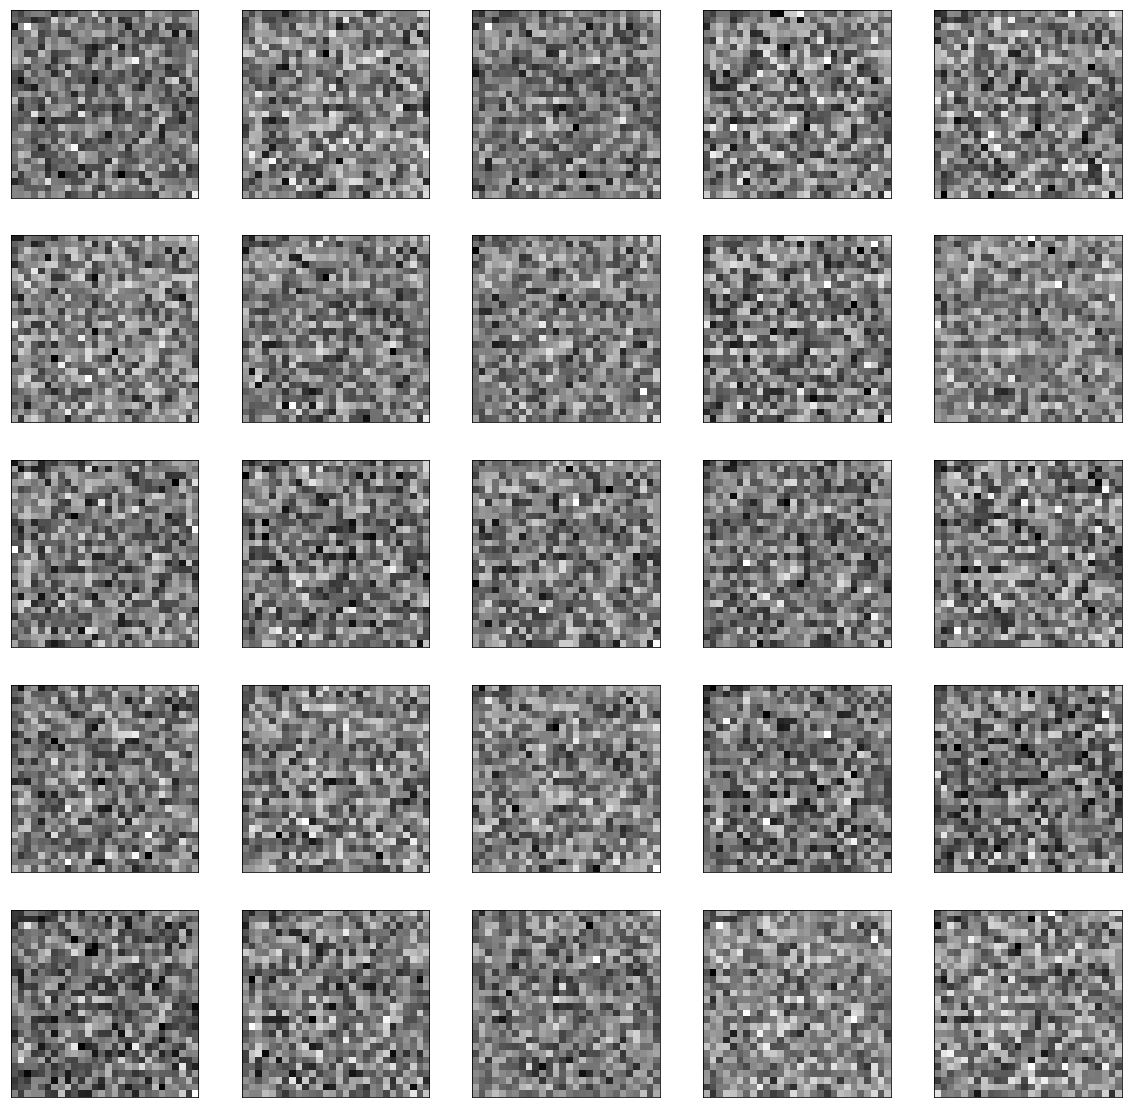

[Epoch 0/10] [Batch 1/938] [Generator loss: 0.711183] [Discriminator loss: 0.641772]
[Epoch 0/10] [Batch 2/938] [Generator loss: 0.708326] [Discriminator loss: 0.563926]
[Epoch 0/10] [Batch 3/938] [Generator loss: 0.705551] [Discriminator loss: 0.506488]
[Epoch 0/10] [Batch 4/938] [Generator loss: 0.702464] [Discriminator loss: 0.456934]
[Epoch 0/10] [Batch 5/938] [Generator loss: 0.698027] [Discriminator loss: 0.423030]
[Epoch 0/10] [Batch 6/938] [Generator loss: 0.693383] [Discriminator loss: 0.399218]
[Epoch 0/10] [Batch 7/938] [Generator loss: 0.687105] [Discriminator loss: 0.384363]
[Epoch 0/10] [Batch 8/938] [Generator loss: 0.680599] [Discriminator loss: 0.376312]
[Epoch 0/10] [Batch 9/938] [Generator loss: 0.671429] [Discriminator loss: 0.376242]
[Epoch 0/10] [Batch 10/938] [Generator loss: 0.660925] [Discriminator loss: 0.378116]
[Epoch 0/10] [Batch 11/938] [Generator loss: 0.648976] [Discriminator loss: 0.382489]
[Epoch 0/10] [Batch 12/938] [Generator loss: 0.637238] [Discrim

[Epoch 0/10] [Batch 106/938] [Generator loss: 0.777194] [Discriminator loss: 0.453379]
[Epoch 0/10] [Batch 107/938] [Generator loss: 0.954282] [Discriminator loss: 0.445143]
[Epoch 0/10] [Batch 108/938] [Generator loss: 1.007596] [Discriminator loss: 0.452614]
[Epoch 0/10] [Batch 109/938] [Generator loss: 0.904499] [Discriminator loss: 0.453449]
[Epoch 0/10] [Batch 110/938] [Generator loss: 0.854840] [Discriminator loss: 0.479532]
[Epoch 0/10] [Batch 111/938] [Generator loss: 0.969117] [Discriminator loss: 0.482896]
[Epoch 0/10] [Batch 112/938] [Generator loss: 0.826917] [Discriminator loss: 0.510178]
[Epoch 0/10] [Batch 113/938] [Generator loss: 0.828543] [Discriminator loss: 0.495930]
[Epoch 0/10] [Batch 114/938] [Generator loss: 0.892036] [Discriminator loss: 0.534090]
[Epoch 0/10] [Batch 115/938] [Generator loss: 0.698105] [Discriminator loss: 0.556759]
[Epoch 0/10] [Batch 116/938] [Generator loss: 0.824529] [Discriminator loss: 0.565881]
[Epoch 0/10] [Batch 117/938] [Generator los

[Epoch 0/10] [Batch 206/938] [Generator loss: 0.928190] [Discriminator loss: 0.527229]
[Epoch 0/10] [Batch 207/938] [Generator loss: 0.743173] [Discriminator loss: 0.554159]
[Epoch 0/10] [Batch 208/938] [Generator loss: 0.731369] [Discriminator loss: 0.603715]
[Epoch 0/10] [Batch 209/938] [Generator loss: 0.640535] [Discriminator loss: 0.646768]
[Epoch 0/10] [Batch 210/938] [Generator loss: 0.704054] [Discriminator loss: 0.632363]
[Epoch 0/10] [Batch 211/938] [Generator loss: 0.634256] [Discriminator loss: 0.646753]
[Epoch 0/10] [Batch 212/938] [Generator loss: 0.690358] [Discriminator loss: 0.599092]
[Epoch 0/10] [Batch 213/938] [Generator loss: 0.771583] [Discriminator loss: 0.627313]
[Epoch 0/10] [Batch 214/938] [Generator loss: 0.573750] [Discriminator loss: 0.597446]
[Epoch 0/10] [Batch 215/938] [Generator loss: 1.037793] [Discriminator loss: 0.601045]
[Epoch 0/10] [Batch 216/938] [Generator loss: 0.565337] [Discriminator loss: 0.593756]
[Epoch 0/10] [Batch 217/938] [Generator los

[Epoch 0/10] [Batch 307/938] [Generator loss: 0.815788] [Discriminator loss: 0.486685]
[Epoch 0/10] [Batch 308/938] [Generator loss: 1.065132] [Discriminator loss: 0.488991]
[Epoch 0/10] [Batch 309/938] [Generator loss: 0.687398] [Discriminator loss: 0.519595]
[Epoch 0/10] [Batch 310/938] [Generator loss: 1.098218] [Discriminator loss: 0.528181]
[Epoch 0/10] [Batch 311/938] [Generator loss: 0.607957] [Discriminator loss: 0.563738]
[Epoch 0/10] [Batch 312/938] [Generator loss: 1.080388] [Discriminator loss: 0.555943]
[Epoch 0/10] [Batch 313/938] [Generator loss: 0.605703] [Discriminator loss: 0.550009]
[Epoch 0/10] [Batch 314/938] [Generator loss: 1.191941] [Discriminator loss: 0.583328]
[Epoch 0/10] [Batch 315/938] [Generator loss: 0.481204] [Discriminator loss: 0.606352]
[Epoch 0/10] [Batch 316/938] [Generator loss: 1.226635] [Discriminator loss: 0.515642]
[Epoch 0/10] [Batch 317/938] [Generator loss: 0.692035] [Discriminator loss: 0.522945]
[Epoch 0/10] [Batch 318/938] [Generator los

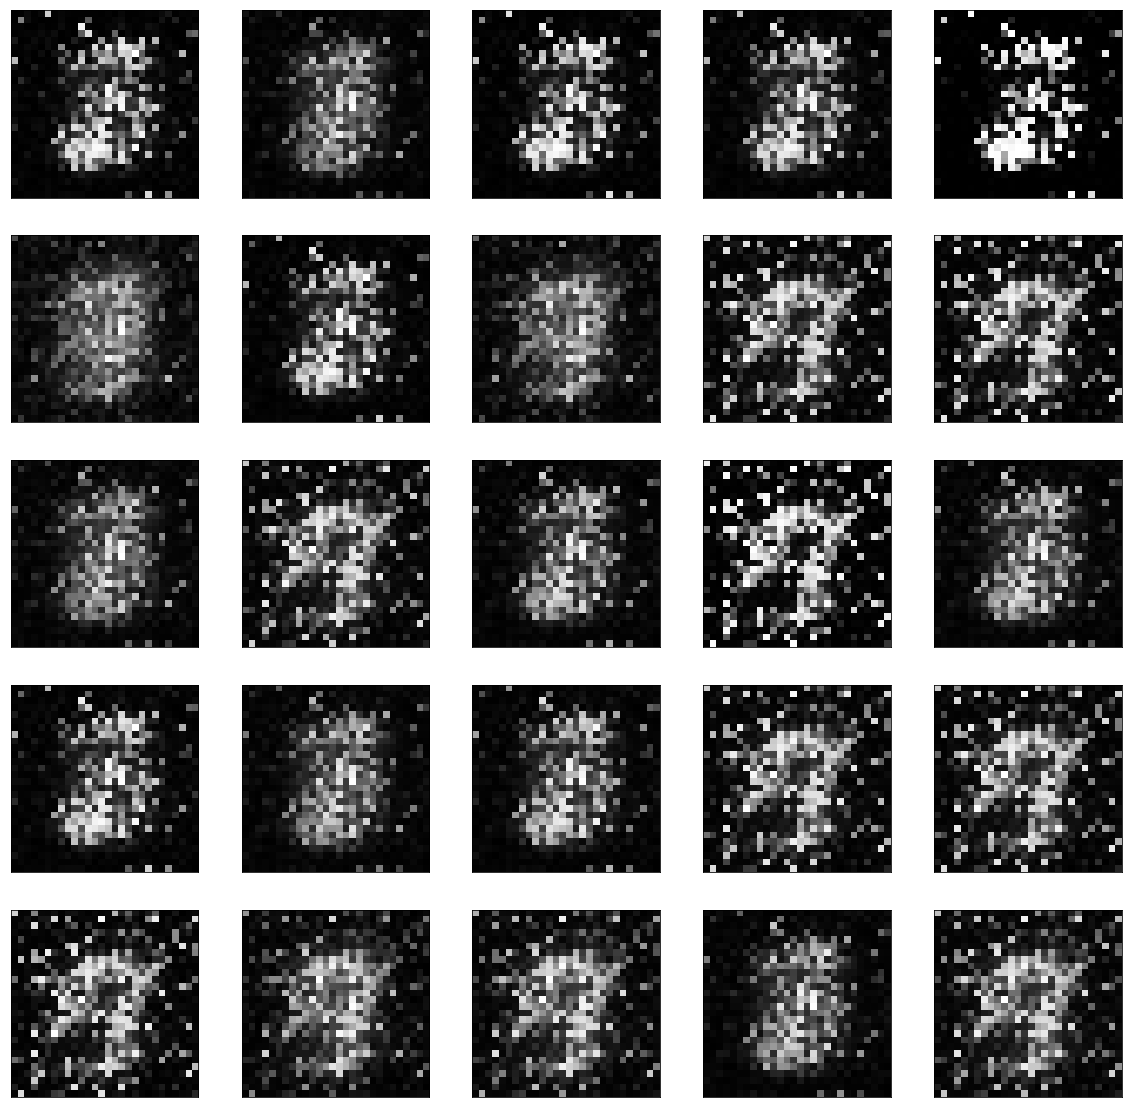

[Epoch 0/10] [Batch 401/938] [Generator loss: 0.789001] [Discriminator loss: 0.502810]
[Epoch 0/10] [Batch 402/938] [Generator loss: 1.074633] [Discriminator loss: 0.546929]
[Epoch 0/10] [Batch 403/938] [Generator loss: 0.514957] [Discriminator loss: 0.579838]
[Epoch 0/10] [Batch 404/938] [Generator loss: 1.529664] [Discriminator loss: 0.639387]
[Epoch 0/10] [Batch 405/938] [Generator loss: 0.272606] [Discriminator loss: 0.795107]
[Epoch 0/10] [Batch 406/938] [Generator loss: 1.272548] [Discriminator loss: 0.520684]
[Epoch 0/10] [Batch 407/938] [Generator loss: 0.870168] [Discriminator loss: 0.504739]
[Epoch 0/10] [Batch 408/938] [Generator loss: 0.700469] [Discriminator loss: 0.522211]
[Epoch 0/10] [Batch 409/938] [Generator loss: 1.155346] [Discriminator loss: 0.530749]
[Epoch 0/10] [Batch 410/938] [Generator loss: 0.612612] [Discriminator loss: 0.550983]
[Epoch 0/10] [Batch 411/938] [Generator loss: 1.233142] [Discriminator loss: 0.518814]
[Epoch 0/10] [Batch 412/938] [Generator los

[Epoch 0/10] [Batch 500/938] [Generator loss: 1.234841] [Discriminator loss: 0.462399]
[Epoch 0/10] [Batch 501/938] [Generator loss: 0.787205] [Discriminator loss: 0.488947]
[Epoch 0/10] [Batch 502/938] [Generator loss: 0.965812] [Discriminator loss: 0.494336]
[Epoch 0/10] [Batch 503/938] [Generator loss: 0.752503] [Discriminator loss: 0.522573]
[Epoch 0/10] [Batch 504/938] [Generator loss: 1.192682] [Discriminator loss: 0.546197]
[Epoch 0/10] [Batch 505/938] [Generator loss: 0.405832] [Discriminator loss: 0.682282]
[Epoch 0/10] [Batch 506/938] [Generator loss: 1.898737] [Discriminator loss: 0.690188]
[Epoch 0/10] [Batch 507/938] [Generator loss: 0.406939] [Discriminator loss: 0.666984]
[Epoch 0/10] [Batch 508/938] [Generator loss: 0.978353] [Discriminator loss: 0.488029]
[Epoch 0/10] [Batch 509/938] [Generator loss: 1.115937] [Discriminator loss: 0.575068]
[Epoch 0/10] [Batch 510/938] [Generator loss: 0.454664] [Discriminator loss: 0.615276]
[Epoch 0/10] [Batch 511/938] [Generator los

[Epoch 0/10] [Batch 606/938] [Generator loss: 0.483495] [Discriminator loss: 0.620374]
[Epoch 0/10] [Batch 607/938] [Generator loss: 1.631085] [Discriminator loss: 0.528328]
[Epoch 0/10] [Batch 608/938] [Generator loss: 0.467409] [Discriminator loss: 0.613742]
[Epoch 0/10] [Batch 609/938] [Generator loss: 1.678157] [Discriminator loss: 0.607979]
[Epoch 0/10] [Batch 610/938] [Generator loss: 0.301804] [Discriminator loss: 0.760299]
[Epoch 0/10] [Batch 611/938] [Generator loss: 1.757246] [Discriminator loss: 0.591896]
[Epoch 0/10] [Batch 612/938] [Generator loss: 0.550012] [Discriminator loss: 0.554574]
[Epoch 0/10] [Batch 613/938] [Generator loss: 1.259566] [Discriminator loss: 0.441995]
[Epoch 0/10] [Batch 614/938] [Generator loss: 0.937318] [Discriminator loss: 0.487363]
[Epoch 0/10] [Batch 615/938] [Generator loss: 0.778985] [Discriminator loss: 0.489700]
[Epoch 0/10] [Batch 616/938] [Generator loss: 1.233150] [Discriminator loss: 0.483493]
[Epoch 0/10] [Batch 617/938] [Generator los

[Epoch 0/10] [Batch 701/938] [Generator loss: 0.734640] [Discriminator loss: 0.458434]
[Epoch 0/10] [Batch 702/938] [Generator loss: 1.832107] [Discriminator loss: 0.481496]
[Epoch 0/10] [Batch 703/938] [Generator loss: 0.394061] [Discriminator loss: 0.638520]
[Epoch 0/10] [Batch 704/938] [Generator loss: 2.203583] [Discriminator loss: 0.553081]
[Epoch 0/10] [Batch 705/938] [Generator loss: 0.487652] [Discriminator loss: 0.553377]
[Epoch 0/10] [Batch 706/938] [Generator loss: 1.648916] [Discriminator loss: 0.402612]
[Epoch 0/10] [Batch 707/938] [Generator loss: 0.936053] [Discriminator loss: 0.441390]
[Epoch 0/10] [Batch 708/938] [Generator loss: 0.928326] [Discriminator loss: 0.422693]
[Epoch 0/10] [Batch 709/938] [Generator loss: 1.463917] [Discriminator loss: 0.528351]
[Epoch 0/10] [Batch 710/938] [Generator loss: 0.354553] [Discriminator loss: 0.695892]
[Epoch 0/10] [Batch 711/938] [Generator loss: 2.420499] [Discriminator loss: 0.652164]
[Epoch 0/10] [Batch 712/938] [Generator los

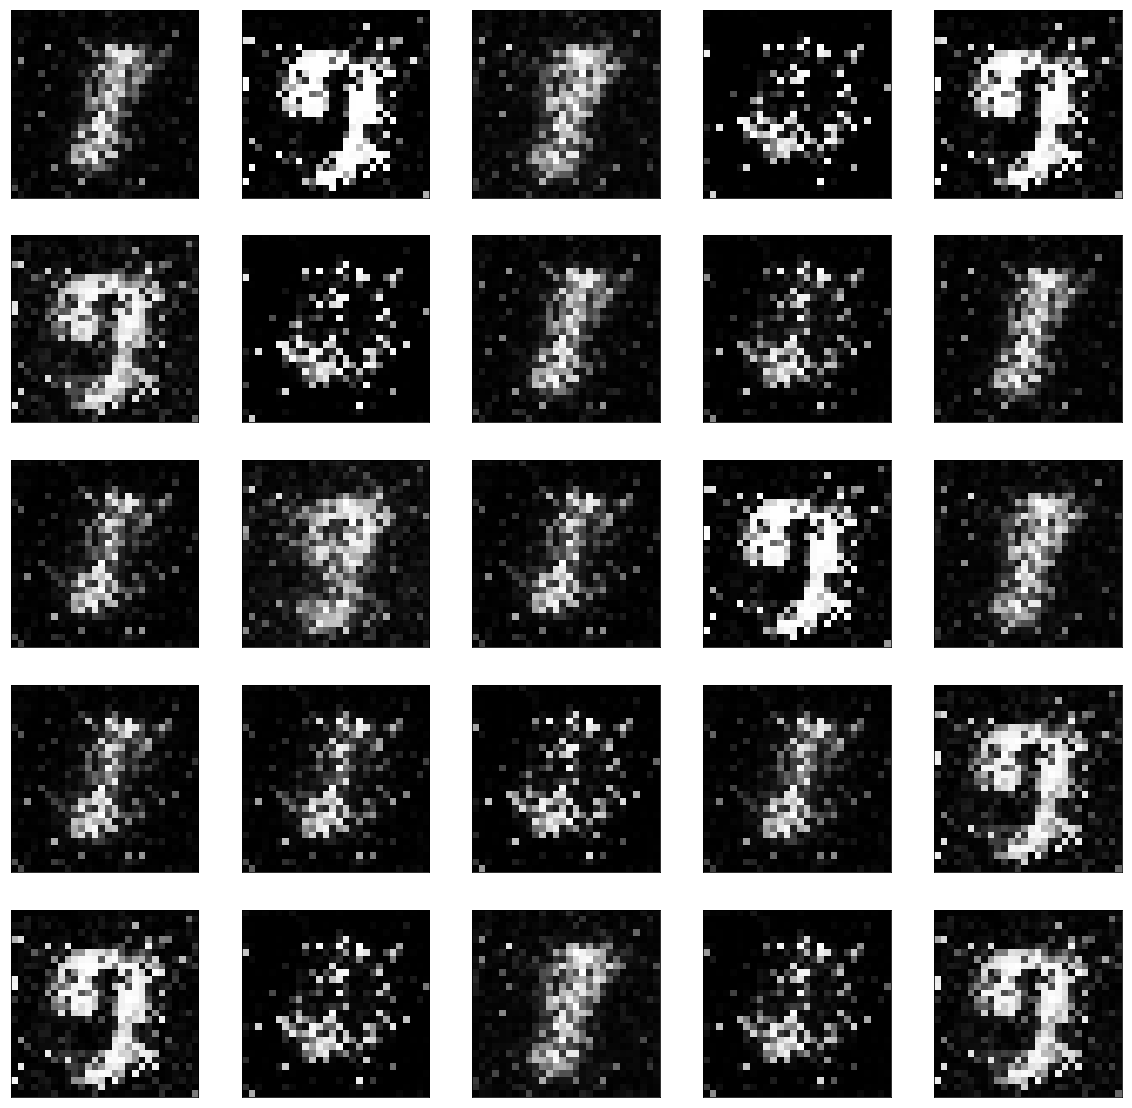

[Epoch 0/10] [Batch 801/938] [Generator loss: 1.174392] [Discriminator loss: 0.365502]
[Epoch 0/10] [Batch 802/938] [Generator loss: 1.279489] [Discriminator loss: 0.363380]
[Epoch 0/10] [Batch 803/938] [Generator loss: 1.079763] [Discriminator loss: 0.402415]
[Epoch 0/10] [Batch 804/938] [Generator loss: 1.164623] [Discriminator loss: 0.493355]
[Epoch 0/10] [Batch 805/938] [Generator loss: 0.653964] [Discriminator loss: 0.483242]
[Epoch 0/10] [Batch 806/938] [Generator loss: 2.177269] [Discriminator loss: 0.566029]
[Epoch 0/10] [Batch 807/938] [Generator loss: 0.399195] [Discriminator loss: 0.666427]
[Epoch 0/10] [Batch 808/938] [Generator loss: 1.891507] [Discriminator loss: 0.502723]
[Epoch 0/10] [Batch 809/938] [Generator loss: 0.768327] [Discriminator loss: 0.481621]
[Epoch 0/10] [Batch 810/938] [Generator loss: 1.173780] [Discriminator loss: 0.406981]
[Epoch 0/10] [Batch 811/938] [Generator loss: 1.151219] [Discriminator loss: 0.372346]
[Epoch 0/10] [Batch 812/938] [Generator los

[Epoch 0/10] [Batch 898/938] [Generator loss: 1.145932] [Discriminator loss: 0.349517]
[Epoch 0/10] [Batch 899/938] [Generator loss: 1.270183] [Discriminator loss: 0.329980]
[Epoch 0/10] [Batch 900/938] [Generator loss: 1.196859] [Discriminator loss: 0.358002]
[Epoch 0/10] [Batch 901/938] [Generator loss: 1.173379] [Discriminator loss: 0.445533]
[Epoch 0/10] [Batch 902/938] [Generator loss: 0.777738] [Discriminator loss: 0.489743]
[Epoch 0/10] [Batch 903/938] [Generator loss: 1.562623] [Discriminator loss: 0.446400]
[Epoch 0/10] [Batch 904/938] [Generator loss: 0.614427] [Discriminator loss: 0.486719]
[Epoch 0/10] [Batch 905/938] [Generator loss: 1.835994] [Discriminator loss: 0.430509]
[Epoch 0/10] [Batch 906/938] [Generator loss: 0.756614] [Discriminator loss: 0.450190]
[Epoch 0/10] [Batch 907/938] [Generator loss: 1.629345] [Discriminator loss: 0.335791]
[Epoch 0/10] [Batch 908/938] [Generator loss: 1.184129] [Discriminator loss: 0.369970]
[Epoch 0/10] [Batch 909/938] [Generator los

[Epoch 1/10] [Batch 58/938] [Generator loss: 1.590914] [Discriminator loss: 0.492637]
[Epoch 1/10] [Batch 59/938] [Generator loss: 0.822173] [Discriminator loss: 0.469964]
[Epoch 1/10] [Batch 60/938] [Generator loss: 1.072951] [Discriminator loss: 0.425113]
[Epoch 1/10] [Batch 61/938] [Generator loss: 1.308003] [Discriminator loss: 0.463480]
[Epoch 1/10] [Batch 62/938] [Generator loss: 0.644999] [Discriminator loss: 0.497160]
[Epoch 1/10] [Batch 63/938] [Generator loss: 1.806490] [Discriminator loss: 0.475152]
[Epoch 1/10] [Batch 64/938] [Generator loss: 0.682402] [Discriminator loss: 0.468333]
[Epoch 1/10] [Batch 65/938] [Generator loss: 1.354869] [Discriminator loss: 0.468927]
[Epoch 1/10] [Batch 66/938] [Generator loss: 0.806193] [Discriminator loss: 0.475418]
[Epoch 1/10] [Batch 67/938] [Generator loss: 1.111815] [Discriminator loss: 0.427083]
[Epoch 1/10] [Batch 68/938] [Generator loss: 1.114693] [Discriminator loss: 0.429278]
[Epoch 1/10] [Batch 69/938] [Generator loss: 0.892251]

[Epoch 1/10] [Batch 156/938] [Generator loss: 2.063698] [Discriminator loss: 0.499603]
[Epoch 1/10] [Batch 157/938] [Generator loss: 0.694553] [Discriminator loss: 0.466025]
[Epoch 1/10] [Batch 158/938] [Generator loss: 1.430410] [Discriminator loss: 0.387495]
[Epoch 1/10] [Batch 159/938] [Generator loss: 1.024838] [Discriminator loss: 0.413601]
[Epoch 1/10] [Batch 160/938] [Generator loss: 0.915267] [Discriminator loss: 0.426958]
[Epoch 1/10] [Batch 161/938] [Generator loss: 1.233341] [Discriminator loss: 0.491897]
[Epoch 1/10] [Batch 162/938] [Generator loss: 0.604517] [Discriminator loss: 0.572265]
[Epoch 1/10] [Batch 163/938] [Generator loss: 1.565247] [Discriminator loss: 0.600539]
[Epoch 1/10] [Batch 164/938] [Generator loss: 0.396122] [Discriminator loss: 0.658650]
[Epoch 1/10] [Batch 165/938] [Generator loss: 1.950783] [Discriminator loss: 0.648087]
[Epoch 1/10] [Batch 166/938] [Generator loss: 0.457689] [Discriminator loss: 0.598800]
[Epoch 1/10] [Batch 167/938] [Generator los

[Epoch 1/10] [Batch 251/938] [Generator loss: 0.505687] [Discriminator loss: 0.563375]
[Epoch 1/10] [Batch 252/938] [Generator loss: 1.735990] [Discriminator loss: 0.447783]
[Epoch 1/10] [Batch 253/938] [Generator loss: 0.905308] [Discriminator loss: 0.417531]
[Epoch 1/10] [Batch 254/938] [Generator loss: 1.154071] [Discriminator loss: 0.437406]
[Epoch 1/10] [Batch 255/938] [Generator loss: 1.068132] [Discriminator loss: 0.424534]
[Epoch 1/10] [Batch 256/938] [Generator loss: 0.968413] [Discriminator loss: 0.417515]
[Epoch 1/10] [Batch 257/938] [Generator loss: 1.322817] [Discriminator loss: 0.492209]
[Epoch 1/10] [Batch 258/938] [Generator loss: 0.635749] [Discriminator loss: 0.507169]
[Epoch 1/10] [Batch 259/938] [Generator loss: 1.991942] [Discriminator loss: 0.561703]
[Epoch 1/10] [Batch 260/938] [Generator loss: 0.481129] [Discriminator loss: 0.558646]
[Epoch 1/10] [Batch 261/938] [Generator loss: 1.975449] [Discriminator loss: 0.430304]
[Epoch 1/10] [Batch 262/938] [Generator los

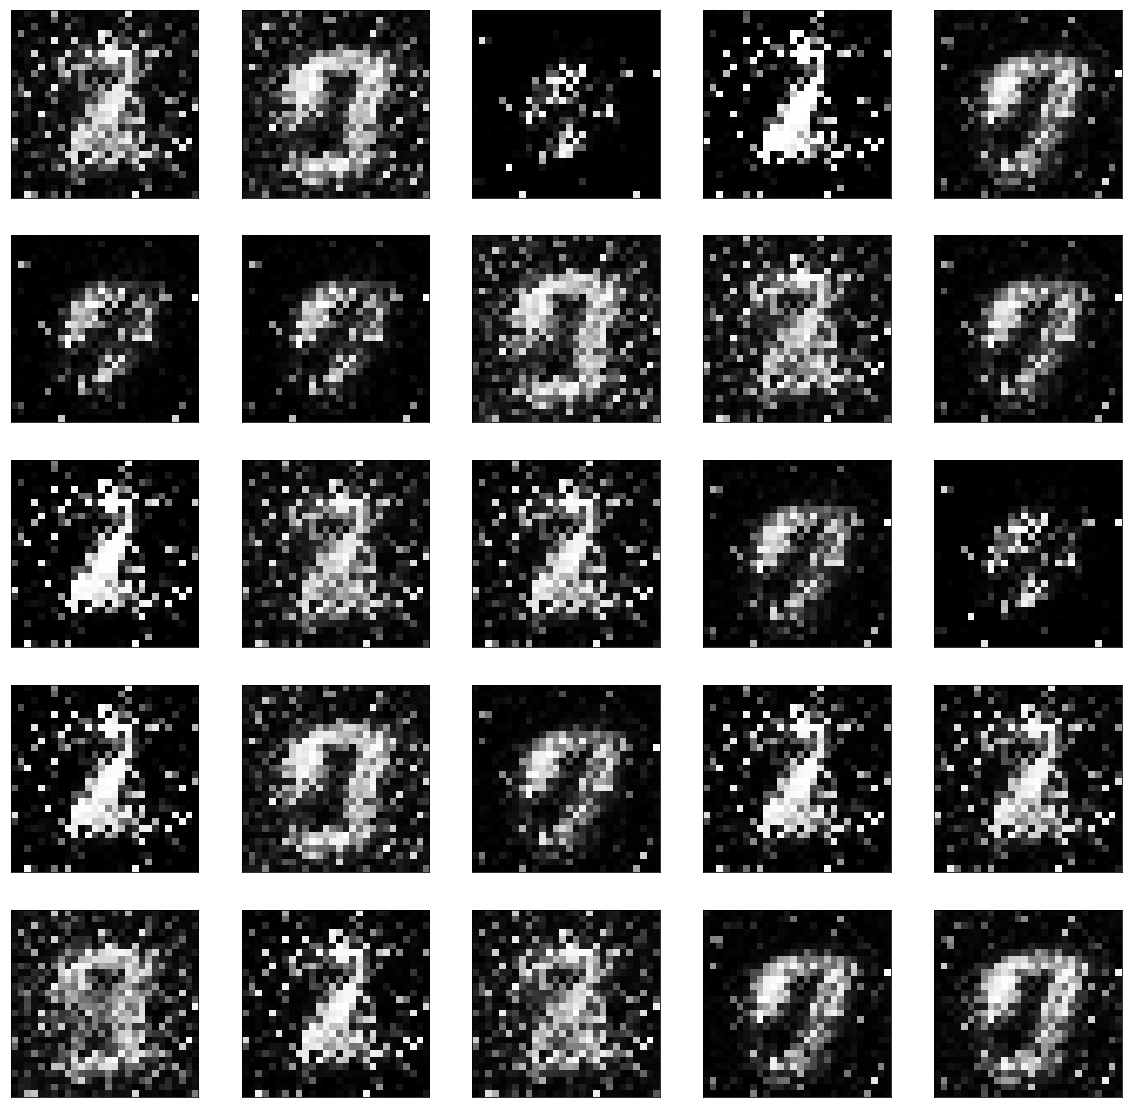

[Epoch 1/10] [Batch 263/938] [Generator loss: 1.184814] [Discriminator loss: 0.381336]
[Epoch 1/10] [Batch 264/938] [Generator loss: 1.202745] [Discriminator loss: 0.385101]
[Epoch 1/10] [Batch 265/938] [Generator loss: 0.977049] [Discriminator loss: 0.405579]
[Epoch 1/10] [Batch 266/938] [Generator loss: 1.186515] [Discriminator loss: 0.426884]
[Epoch 1/10] [Batch 267/938] [Generator loss: 0.794045] [Discriminator loss: 0.438717]
[Epoch 1/10] [Batch 268/938] [Generator loss: 1.660876] [Discriminator loss: 0.467505]
[Epoch 1/10] [Batch 269/938] [Generator loss: 0.459492] [Discriminator loss: 0.592957]
[Epoch 1/10] [Batch 270/938] [Generator loss: 2.067556] [Discriminator loss: 0.521407]
[Epoch 1/10] [Batch 271/938] [Generator loss: 0.615196] [Discriminator loss: 0.501480]
[Epoch 1/10] [Batch 272/938] [Generator loss: 1.361477] [Discriminator loss: 0.396298]
[Epoch 1/10] [Batch 273/938] [Generator loss: 1.097674] [Discriminator loss: 0.392447]
[Epoch 1/10] [Batch 274/938] [Generator los

[Epoch 1/10] [Batch 369/938] [Generator loss: 0.784229] [Discriminator loss: 0.458811]
[Epoch 1/10] [Batch 370/938] [Generator loss: 2.171853] [Discriminator loss: 0.585037]
[Epoch 1/10] [Batch 371/938] [Generator loss: 0.222798] [Discriminator loss: 0.852155]
[Epoch 1/10] [Batch 372/938] [Generator loss: 3.354197] [Discriminator loss: 0.980786]
[Epoch 1/10] [Batch 373/938] [Generator loss: 0.468361] [Discriminator loss: 0.569044]
[Epoch 1/10] [Batch 374/938] [Generator loss: 1.385359] [Discriminator loss: 0.350607]
[Epoch 1/10] [Batch 375/938] [Generator loss: 1.462042] [Discriminator loss: 0.382613]
[Epoch 1/10] [Batch 376/938] [Generator loss: 0.839277] [Discriminator loss: 0.393888]
[Epoch 1/10] [Batch 377/938] [Generator loss: 1.610165] [Discriminator loss: 0.416763]
[Epoch 1/10] [Batch 378/938] [Generator loss: 0.828994] [Discriminator loss: 0.409486]
[Epoch 1/10] [Batch 379/938] [Generator loss: 1.477817] [Discriminator loss: 0.400916]
[Epoch 1/10] [Batch 380/938] [Generator los

[Epoch 1/10] [Batch 474/938] [Generator loss: 1.724650] [Discriminator loss: 0.310747]
[Epoch 1/10] [Batch 475/938] [Generator loss: 0.893858] [Discriminator loss: 0.358866]
[Epoch 1/10] [Batch 476/938] [Generator loss: 2.261405] [Discriminator loss: 0.373867]
[Epoch 1/10] [Batch 477/938] [Generator loss: 0.580793] [Discriminator loss: 0.496720]
[Epoch 1/10] [Batch 478/938] [Generator loss: 3.107188] [Discriminator loss: 0.598831]
[Epoch 1/10] [Batch 479/938] [Generator loss: 0.349577] [Discriminator loss: 0.682788]
[Epoch 1/10] [Batch 480/938] [Generator loss: 3.480577] [Discriminator loss: 0.468412]
[Epoch 1/10] [Batch 481/938] [Generator loss: 1.096917] [Discriminator loss: 0.274940]
[Epoch 1/10] [Batch 482/938] [Generator loss: 1.429311] [Discriminator loss: 0.254458]
[Epoch 1/10] [Batch 483/938] [Generator loss: 1.745164] [Discriminator loss: 0.294889]
[Epoch 1/10] [Batch 484/938] [Generator loss: 0.941571] [Discriminator loss: 0.374821]
[Epoch 1/10] [Batch 485/938] [Generator los

[Epoch 1/10] [Batch 579/938] [Generator loss: 1.354775] [Discriminator loss: 0.339624]
[Epoch 1/10] [Batch 580/938] [Generator loss: 1.083835] [Discriminator loss: 0.356264]
[Epoch 1/10] [Batch 581/938] [Generator loss: 1.664403] [Discriminator loss: 0.297939]
[Epoch 1/10] [Batch 582/938] [Generator loss: 0.992718] [Discriminator loss: 0.312239]
[Epoch 1/10] [Batch 583/938] [Generator loss: 2.409164] [Discriminator loss: 0.355854]
[Epoch 1/10] [Batch 584/938] [Generator loss: 0.543098] [Discriminator loss: 0.503159]
[Epoch 1/10] [Batch 585/938] [Generator loss: 3.136099] [Discriminator loss: 0.525700]
[Epoch 1/10] [Batch 586/938] [Generator loss: 0.628143] [Discriminator loss: 0.446004]
[Epoch 1/10] [Batch 587/938] [Generator loss: 2.379148] [Discriminator loss: 0.201180]
[Epoch 1/10] [Batch 588/938] [Generator loss: 1.957969] [Discriminator loss: 0.273861]
[Epoch 1/10] [Batch 589/938] [Generator loss: 0.591327] [Discriminator loss: 0.456935]
[Epoch 1/10] [Batch 590/938] [Generator los

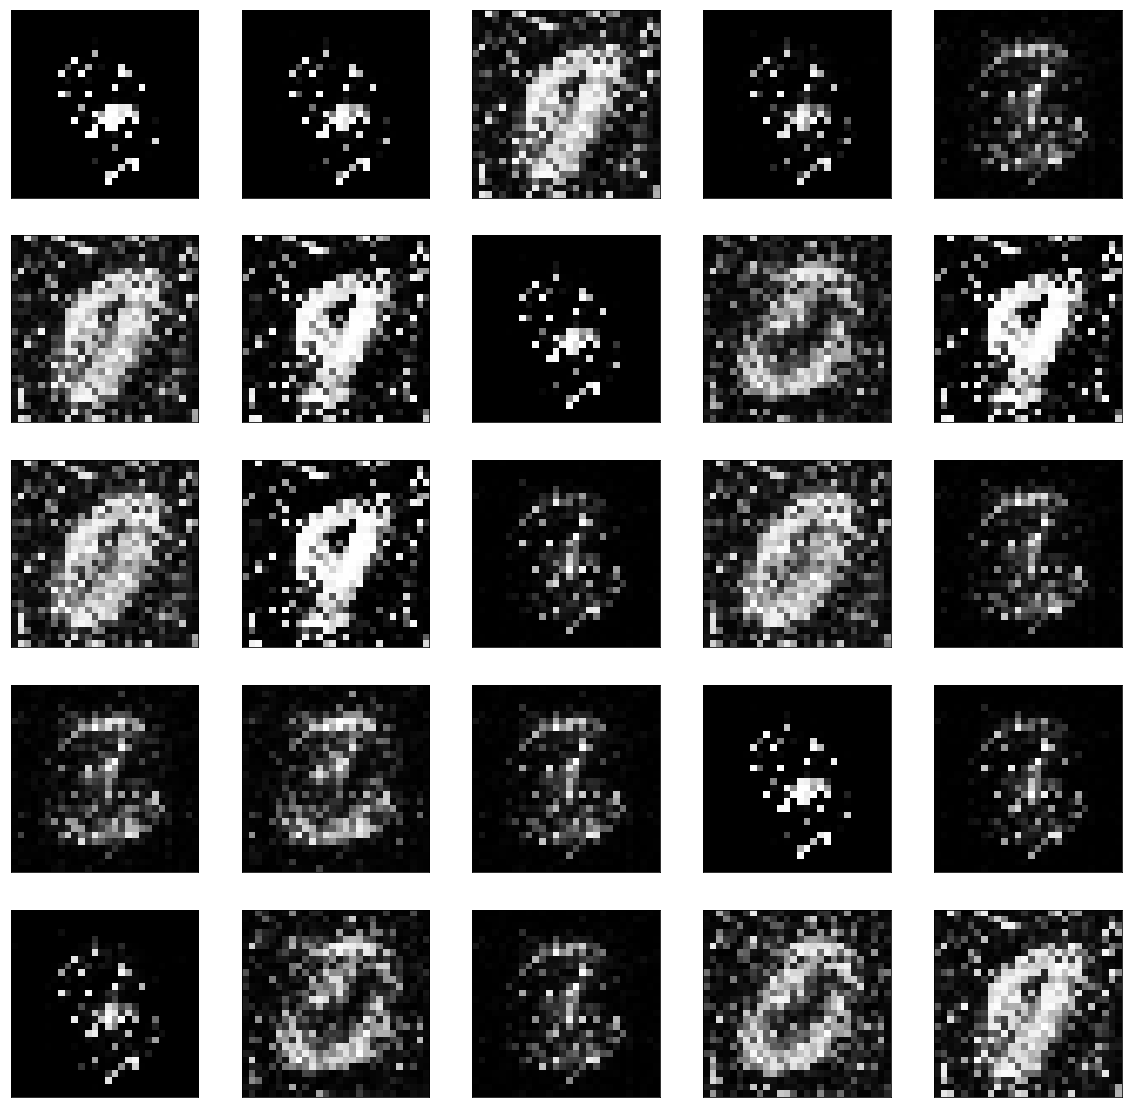

[Epoch 1/10] [Batch 663/938] [Generator loss: 1.060491] [Discriminator loss: 0.366811]
[Epoch 1/10] [Batch 664/938] [Generator loss: 1.344058] [Discriminator loss: 0.363070]
[Epoch 1/10] [Batch 665/938] [Generator loss: 1.091142] [Discriminator loss: 0.428707]
[Epoch 1/10] [Batch 666/938] [Generator loss: 1.024093] [Discriminator loss: 0.369735]
[Epoch 1/10] [Batch 667/938] [Generator loss: 1.656734] [Discriminator loss: 0.303152]
[Epoch 1/10] [Batch 668/938] [Generator loss: 1.101186] [Discriminator loss: 0.340713]
[Epoch 1/10] [Batch 669/938] [Generator loss: 1.271754] [Discriminator loss: 0.350978]
[Epoch 1/10] [Batch 670/938] [Generator loss: 1.131111] [Discriminator loss: 0.356464]
[Epoch 1/10] [Batch 671/938] [Generator loss: 1.376093] [Discriminator loss: 0.325840]
[Epoch 1/10] [Batch 672/938] [Generator loss: 1.134596] [Discriminator loss: 0.352629]
[Epoch 1/10] [Batch 673/938] [Generator loss: 1.332741] [Discriminator loss: 0.359380]
[Epoch 1/10] [Batch 674/938] [Generator los

[Epoch 1/10] [Batch 758/938] [Generator loss: 1.312490] [Discriminator loss: 0.253173]
[Epoch 1/10] [Batch 759/938] [Generator loss: 1.178929] [Discriminator loss: 0.275527]
[Epoch 1/10] [Batch 760/938] [Generator loss: 1.907340] [Discriminator loss: 0.269428]
[Epoch 1/10] [Batch 761/938] [Generator loss: 1.137026] [Discriminator loss: 0.309914]
[Epoch 1/10] [Batch 762/938] [Generator loss: 1.498966] [Discriminator loss: 0.362731]
[Epoch 1/10] [Batch 763/938] [Generator loss: 0.875440] [Discriminator loss: 0.379788]
[Epoch 1/10] [Batch 764/938] [Generator loss: 2.260341] [Discriminator loss: 0.528744]
[Epoch 1/10] [Batch 765/938] [Generator loss: 0.327069] [Discriminator loss: 0.743453]
[Epoch 1/10] [Batch 766/938] [Generator loss: 3.156334] [Discriminator loss: 0.512974]
[Epoch 1/10] [Batch 767/938] [Generator loss: 1.082306] [Discriminator loss: 0.300179]
[Epoch 1/10] [Batch 768/938] [Generator loss: 1.220904] [Discriminator loss: 0.254200]
[Epoch 1/10] [Batch 769/938] [Generator los

[Epoch 1/10] [Batch 853/938] [Generator loss: 1.734891] [Discriminator loss: 0.427205]
[Epoch 1/10] [Batch 854/938] [Generator loss: 0.489189] [Discriminator loss: 0.551554]
[Epoch 1/10] [Batch 855/938] [Generator loss: 3.197413] [Discriminator loss: 0.877516]
[Epoch 1/10] [Batch 856/938] [Generator loss: 0.268183] [Discriminator loss: 0.780886]
[Epoch 1/10] [Batch 857/938] [Generator loss: 2.588298] [Discriminator loss: 0.460168]
[Epoch 1/10] [Batch 858/938] [Generator loss: 1.155676] [Discriminator loss: 0.322958]
[Epoch 1/10] [Batch 859/938] [Generator loss: 1.127455] [Discriminator loss: 0.333319]
[Epoch 1/10] [Batch 860/938] [Generator loss: 1.682459] [Discriminator loss: 0.327610]
[Epoch 1/10] [Batch 861/938] [Generator loss: 1.054264] [Discriminator loss: 0.390296]
[Epoch 1/10] [Batch 862/938] [Generator loss: 1.244968] [Discriminator loss: 0.382089]
[Epoch 1/10] [Batch 863/938] [Generator loss: 1.085588] [Discriminator loss: 0.396393]
[Epoch 1/10] [Batch 864/938] [Generator los

[Epoch 2/10] [Batch 14/938] [Generator loss: 2.539859] [Discriminator loss: 0.337534]
[Epoch 2/10] [Batch 15/938] [Generator loss: 0.705652] [Discriminator loss: 0.386381]
[Epoch 2/10] [Batch 16/938] [Generator loss: 3.681659] [Discriminator loss: 0.524959]
[Epoch 2/10] [Batch 17/938] [Generator loss: 0.496704] [Discriminator loss: 0.518035]
[Epoch 2/10] [Batch 18/938] [Generator loss: 3.872772] [Discriminator loss: 0.497616]
[Epoch 2/10] [Batch 19/938] [Generator loss: 1.194742] [Discriminator loss: 0.234785]
[Epoch 2/10] [Batch 20/938] [Generator loss: 1.651673] [Discriminator loss: 0.247023]
[Epoch 2/10] [Batch 21/938] [Generator loss: 1.493129] [Discriminator loss: 0.207915]
[Epoch 2/10] [Batch 22/938] [Generator loss: 1.982521] [Discriminator loss: 0.240883]
[Epoch 2/10] [Batch 23/938] [Generator loss: 1.194880] [Discriminator loss: 0.304002]
[Epoch 2/10] [Batch 24/938] [Generator loss: 2.135656] [Discriminator loss: 0.252390]
[Epoch 2/10] [Batch 25/938] [Generator loss: 1.147995]

[Epoch 2/10] [Batch 112/938] [Generator loss: 2.648160] [Discriminator loss: 0.397872]
[Epoch 2/10] [Batch 113/938] [Generator loss: 0.771386] [Discriminator loss: 0.413735]
[Epoch 2/10] [Batch 114/938] [Generator loss: 2.592049] [Discriminator loss: 0.282483]
[Epoch 2/10] [Batch 115/938] [Generator loss: 1.225177] [Discriminator loss: 0.265210]
[Epoch 2/10] [Batch 116/938] [Generator loss: 1.658556] [Discriminator loss: 0.238868]
[Epoch 2/10] [Batch 117/938] [Generator loss: 1.619111] [Discriminator loss: 0.287308]
[Epoch 2/10] [Batch 118/938] [Generator loss: 1.328854] [Discriminator loss: 0.336019]
[Epoch 2/10] [Batch 119/938] [Generator loss: 1.237217] [Discriminator loss: 0.320371]
[Epoch 2/10] [Batch 120/938] [Generator loss: 1.703133] [Discriminator loss: 0.331242]
[Epoch 2/10] [Batch 121/938] [Generator loss: 0.689878] [Discriminator loss: 0.487351]
[Epoch 2/10] [Batch 122/938] [Generator loss: 2.953043] [Discriminator loss: 0.547382]
[Epoch 2/10] [Batch 123/938] [Generator los

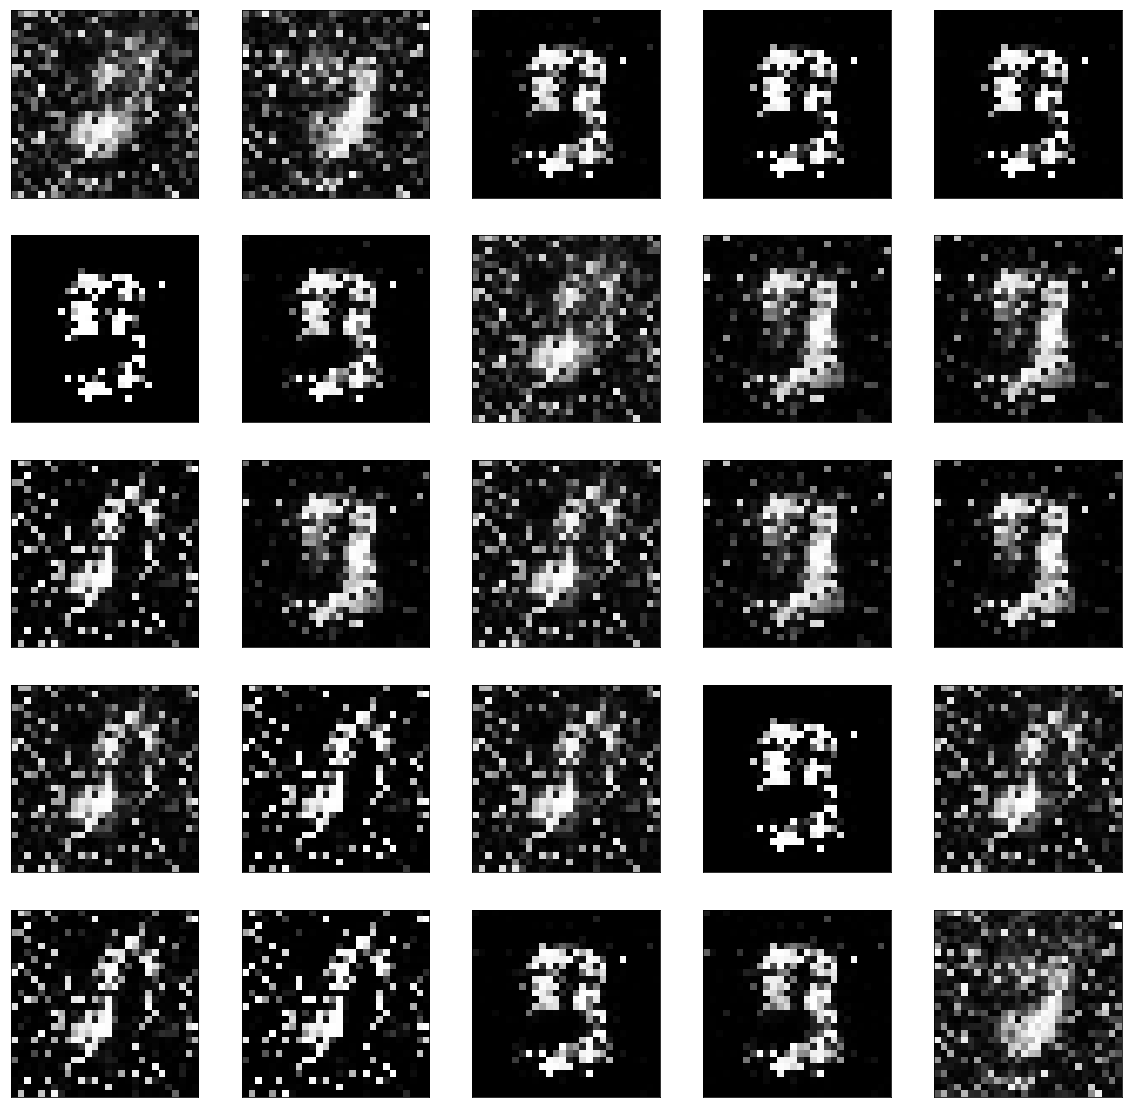

[Epoch 2/10] [Batch 125/938] [Generator loss: 1.175886] [Discriminator loss: 0.268176]
[Epoch 2/10] [Batch 126/938] [Generator loss: 0.965068] [Discriminator loss: 0.288477]
[Epoch 2/10] [Batch 127/938] [Generator loss: 2.758066] [Discriminator loss: 0.480420]
[Epoch 2/10] [Batch 128/938] [Generator loss: 0.448563] [Discriminator loss: 0.573821]
[Epoch 2/10] [Batch 129/938] [Generator loss: 2.795703] [Discriminator loss: 0.404735]
[Epoch 2/10] [Batch 130/938] [Generator loss: 1.167438] [Discriminator loss: 0.338800]
[Epoch 2/10] [Batch 131/938] [Generator loss: 1.288818] [Discriminator loss: 0.330113]
[Epoch 2/10] [Batch 132/938] [Generator loss: 1.399127] [Discriminator loss: 0.340739]
[Epoch 2/10] [Batch 133/938] [Generator loss: 1.039993] [Discriminator loss: 0.413262]
[Epoch 2/10] [Batch 134/938] [Generator loss: 1.370526] [Discriminator loss: 0.376669]
[Epoch 2/10] [Batch 135/938] [Generator loss: 1.225049] [Discriminator loss: 0.397359]
[Epoch 2/10] [Batch 136/938] [Generator los

[Epoch 2/10] [Batch 230/938] [Generator loss: 2.027536] [Discriminator loss: 0.232582]
[Epoch 2/10] [Batch 231/938] [Generator loss: 1.248179] [Discriminator loss: 0.280159]
[Epoch 2/10] [Batch 232/938] [Generator loss: 2.124959] [Discriminator loss: 0.342450]
[Epoch 2/10] [Batch 233/938] [Generator loss: 0.676688] [Discriminator loss: 0.412580]
[Epoch 2/10] [Batch 234/938] [Generator loss: 3.968717] [Discriminator loss: 0.515092]
[Epoch 2/10] [Batch 235/938] [Generator loss: 0.989035] [Discriminator loss: 0.319020]
[Epoch 2/10] [Batch 236/938] [Generator loss: 2.014761] [Discriminator loss: 0.152467]
[Epoch 2/10] [Batch 237/938] [Generator loss: 2.541798] [Discriminator loss: 0.205119]
[Epoch 2/10] [Batch 238/938] [Generator loss: 1.228729] [Discriminator loss: 0.235641]
[Epoch 2/10] [Batch 239/938] [Generator loss: 2.417431] [Discriminator loss: 0.277419]
[Epoch 2/10] [Batch 240/938] [Generator loss: 1.125623] [Discriminator loss: 0.302954]
[Epoch 2/10] [Batch 241/938] [Generator los

[Epoch 2/10] [Batch 335/938] [Generator loss: 2.665713] [Discriminator loss: 0.294219]
[Epoch 2/10] [Batch 336/938] [Generator loss: 1.747366] [Discriminator loss: 0.221512]
[Epoch 2/10] [Batch 337/938] [Generator loss: 0.980339] [Discriminator loss: 0.281033]
[Epoch 2/10] [Batch 338/938] [Generator loss: 2.343164] [Discriminator loss: 0.352531]
[Epoch 2/10] [Batch 339/938] [Generator loss: 0.908759] [Discriminator loss: 0.350571]
[Epoch 2/10] [Batch 340/938] [Generator loss: 1.908990] [Discriminator loss: 0.306313]
[Epoch 2/10] [Batch 341/938] [Generator loss: 1.082049] [Discriminator loss: 0.329286]
[Epoch 2/10] [Batch 342/938] [Generator loss: 1.840709] [Discriminator loss: 0.343567]
[Epoch 2/10] [Batch 343/938] [Generator loss: 0.926959] [Discriminator loss: 0.389996]
[Epoch 2/10] [Batch 344/938] [Generator loss: 1.893966] [Discriminator loss: 0.361795]
[Epoch 2/10] [Batch 345/938] [Generator loss: 0.993481] [Discriminator loss: 0.395155]
[Epoch 2/10] [Batch 346/938] [Generator los

[Epoch 2/10] [Batch 438/938] [Generator loss: 1.272285] [Discriminator loss: 0.289149]
[Epoch 2/10] [Batch 439/938] [Generator loss: 1.640942] [Discriminator loss: 0.330224]
[Epoch 2/10] [Batch 440/938] [Generator loss: 0.828473] [Discriminator loss: 0.404723]
[Epoch 2/10] [Batch 441/938] [Generator loss: 2.403476] [Discriminator loss: 0.394623]
[Epoch 2/10] [Batch 442/938] [Generator loss: 0.466983] [Discriminator loss: 0.561008]
[Epoch 2/10] [Batch 443/938] [Generator loss: 3.575174] [Discriminator loss: 0.690894]
[Epoch 2/10] [Batch 444/938] [Generator loss: 0.432588] [Discriminator loss: 0.549087]
[Epoch 2/10] [Batch 445/938] [Generator loss: 3.132044] [Discriminator loss: 0.452964]
[Epoch 2/10] [Batch 446/938] [Generator loss: 1.064931] [Discriminator loss: 0.298043]
[Epoch 2/10] [Batch 447/938] [Generator loss: 1.633362] [Discriminator loss: 0.193518]
[Epoch 2/10] [Batch 448/938] [Generator loss: 2.195922] [Discriminator loss: 0.247764]
[Epoch 2/10] [Batch 449/938] [Generator los

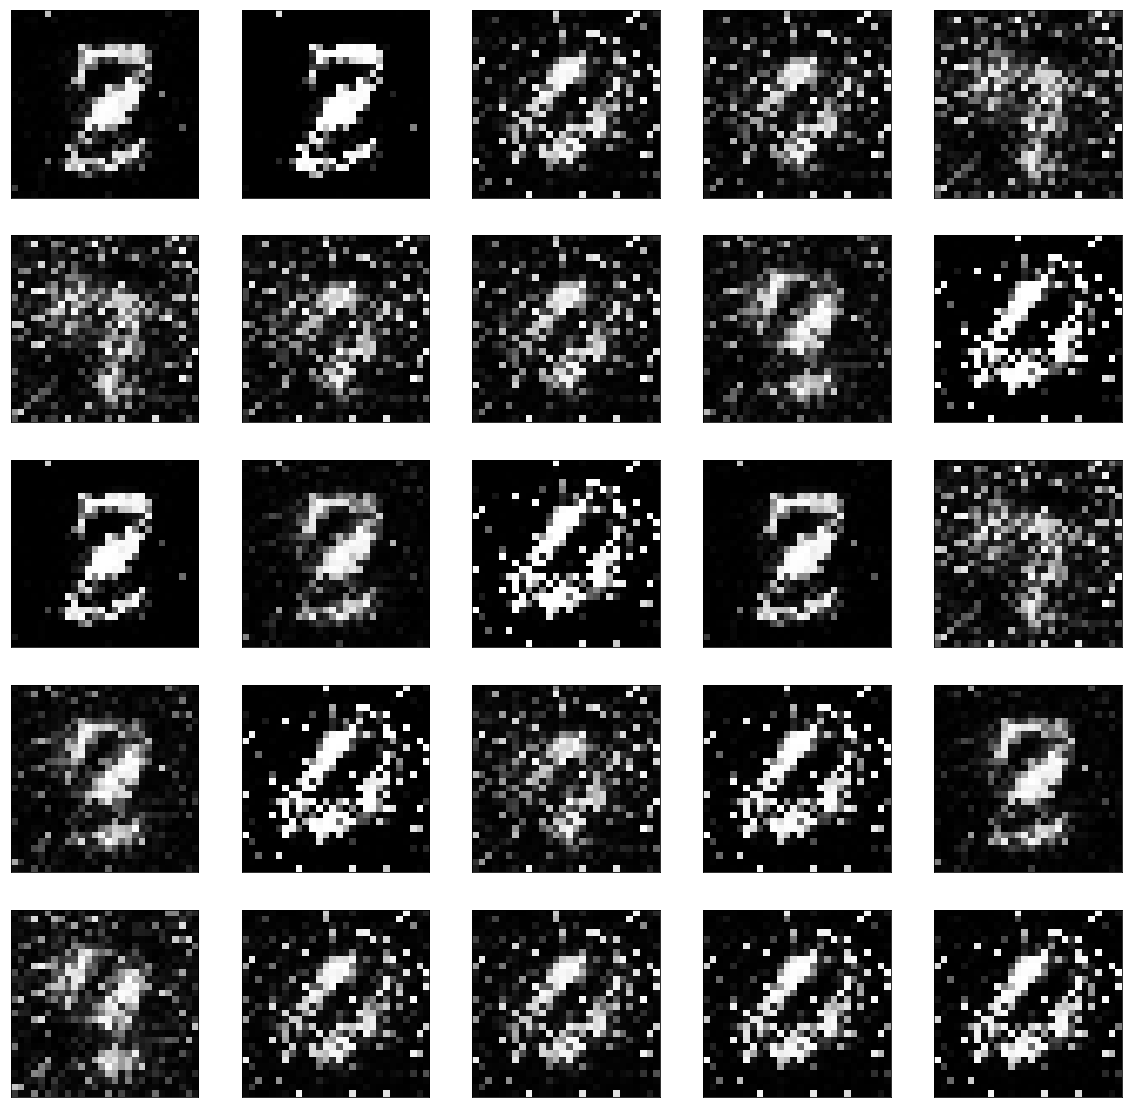

[Epoch 2/10] [Batch 525/938] [Generator loss: 1.785258] [Discriminator loss: 0.177904]
[Epoch 2/10] [Batch 526/938] [Generator loss: 1.434054] [Discriminator loss: 0.250896]
[Epoch 2/10] [Batch 527/938] [Generator loss: 1.768403] [Discriminator loss: 0.231057]
[Epoch 2/10] [Batch 528/938] [Generator loss: 1.393249] [Discriminator loss: 0.281343]
[Epoch 2/10] [Batch 529/938] [Generator loss: 1.518883] [Discriminator loss: 0.270350]
[Epoch 2/10] [Batch 530/938] [Generator loss: 1.373942] [Discriminator loss: 0.277043]
[Epoch 2/10] [Batch 531/938] [Generator loss: 1.768159] [Discriminator loss: 0.268177]
[Epoch 2/10] [Batch 532/938] [Generator loss: 1.331828] [Discriminator loss: 0.216839]
[Epoch 2/10] [Batch 533/938] [Generator loss: 2.517159] [Discriminator loss: 0.288930]
[Epoch 2/10] [Batch 534/938] [Generator loss: 0.757914] [Discriminator loss: 0.357432]
[Epoch 2/10] [Batch 535/938] [Generator loss: 3.781183] [Discriminator loss: 0.348648]
[Epoch 2/10] [Batch 536/938] [Generator los

[Epoch 2/10] [Batch 620/938] [Generator loss: 0.563751] [Discriminator loss: 0.527882]
[Epoch 2/10] [Batch 621/938] [Generator loss: 4.176016] [Discriminator loss: 0.634600]
[Epoch 2/10] [Batch 622/938] [Generator loss: 0.655424] [Discriminator loss: 0.437206]
[Epoch 2/10] [Batch 623/938] [Generator loss: 3.063221] [Discriminator loss: 0.258433]
[Epoch 2/10] [Batch 624/938] [Generator loss: 1.946797] [Discriminator loss: 0.242966]
[Epoch 2/10] [Batch 625/938] [Generator loss: 0.895745] [Discriminator loss: 0.317221]
[Epoch 2/10] [Batch 626/938] [Generator loss: 3.206811] [Discriminator loss: 0.391165]
[Epoch 2/10] [Batch 627/938] [Generator loss: 0.846362] [Discriminator loss: 0.379343]
[Epoch 2/10] [Batch 628/938] [Generator loss: 2.655408] [Discriminator loss: 0.444710]
[Epoch 2/10] [Batch 629/938] [Generator loss: 0.560530] [Discriminator loss: 0.529795]
[Epoch 2/10] [Batch 630/938] [Generator loss: 3.267325] [Discriminator loss: 0.394646]
[Epoch 2/10] [Batch 631/938] [Generator los

[Epoch 2/10] [Batch 715/938] [Generator loss: 3.109195] [Discriminator loss: 0.163466]
[Epoch 2/10] [Batch 716/938] [Generator loss: 1.122770] [Discriminator loss: 0.268275]
[Epoch 2/10] [Batch 717/938] [Generator loss: 2.490527] [Discriminator loss: 0.224980]
[Epoch 2/10] [Batch 718/938] [Generator loss: 1.564631] [Discriminator loss: 0.232103]
[Epoch 2/10] [Batch 719/938] [Generator loss: 1.327273] [Discriminator loss: 0.220537]
[Epoch 2/10] [Batch 720/938] [Generator loss: 2.834282] [Discriminator loss: 0.330703]
[Epoch 2/10] [Batch 721/938] [Generator loss: 0.771511] [Discriminator loss: 0.381749]
[Epoch 2/10] [Batch 722/938] [Generator loss: 3.667348] [Discriminator loss: 0.528288]
[Epoch 2/10] [Batch 723/938] [Generator loss: 0.609280] [Discriminator loss: 0.430703]
[Epoch 2/10] [Batch 724/938] [Generator loss: 3.958007] [Discriminator loss: 0.412048]
[Epoch 2/10] [Batch 725/938] [Generator loss: 1.556974] [Discriminator loss: 0.185435]
[Epoch 2/10] [Batch 726/938] [Generator los

[Epoch 2/10] [Batch 820/938] [Generator loss: 0.921724] [Discriminator loss: 0.396557]
[Epoch 2/10] [Batch 821/938] [Generator loss: 3.143588] [Discriminator loss: 0.320923]
[Epoch 2/10] [Batch 822/938] [Generator loss: 1.132574] [Discriminator loss: 0.371048]
[Epoch 2/10] [Batch 823/938] [Generator loss: 3.587103] [Discriminator loss: 0.398138]
[Epoch 2/10] [Batch 824/938] [Generator loss: 0.970384] [Discriminator loss: 0.338582]
[Epoch 2/10] [Batch 825/938] [Generator loss: 2.333032] [Discriminator loss: 0.183678]
[Epoch 2/10] [Batch 826/938] [Generator loss: 1.926743] [Discriminator loss: 0.194808]
[Epoch 2/10] [Batch 827/938] [Generator loss: 1.605429] [Discriminator loss: 0.240408]
[Epoch 2/10] [Batch 828/938] [Generator loss: 1.384686] [Discriminator loss: 0.307947]
[Epoch 2/10] [Batch 829/938] [Generator loss: 1.490655] [Discriminator loss: 0.259497]
[Epoch 2/10] [Batch 830/938] [Generator loss: 1.801121] [Discriminator loss: 0.262046]
[Epoch 2/10] [Batch 831/938] [Generator los

[Epoch 2/10] [Batch 922/938] [Generator loss: 3.276912] [Discriminator loss: 0.408909]
[Epoch 2/10] [Batch 923/938] [Generator loss: 0.830935] [Discriminator loss: 0.370822]
[Epoch 2/10] [Batch 924/938] [Generator loss: 2.837620] [Discriminator loss: 0.409883]


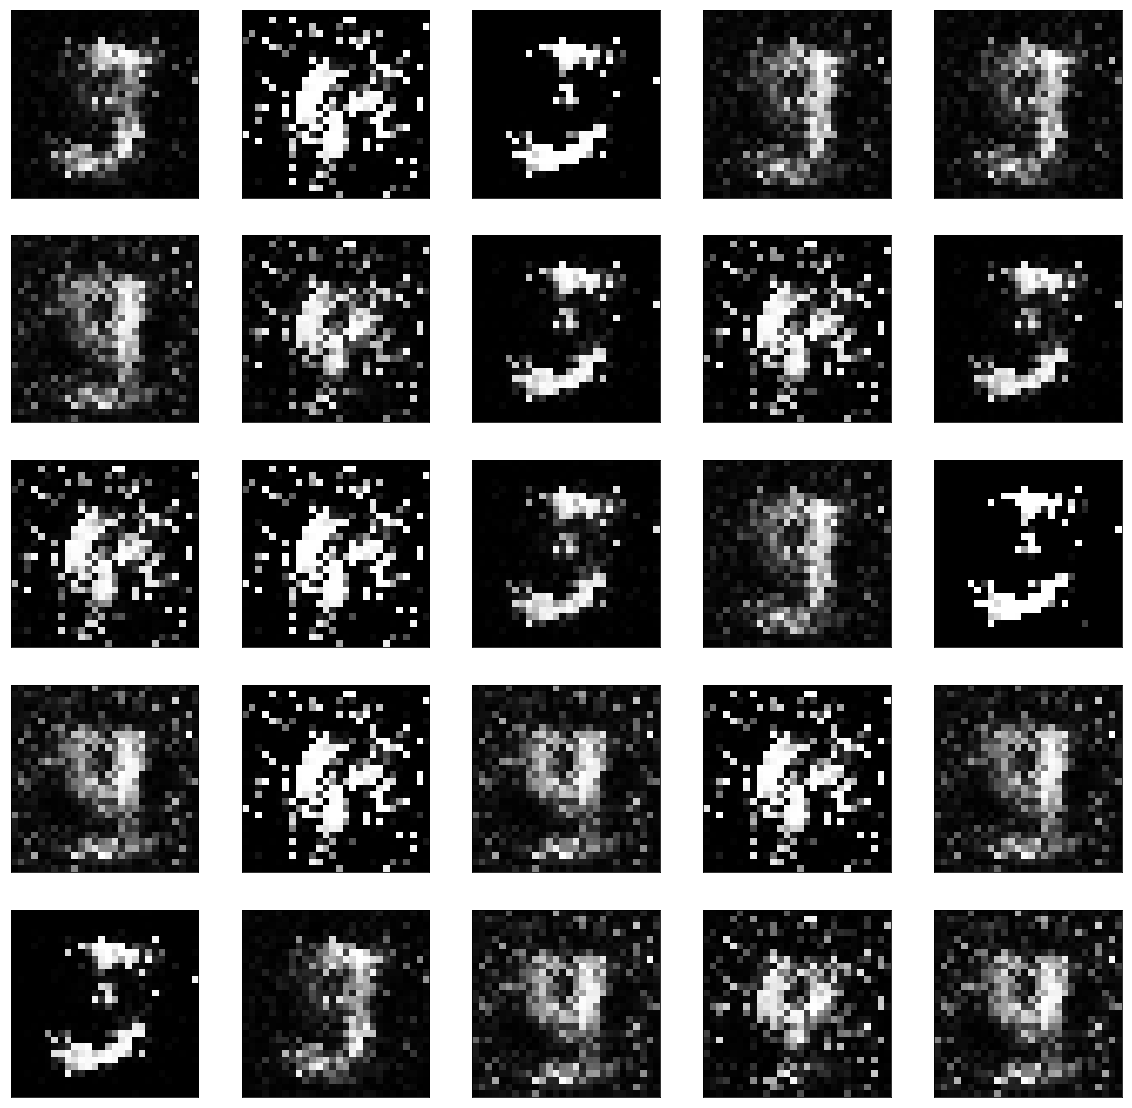

[Epoch 2/10] [Batch 925/938] [Generator loss: 0.729723] [Discriminator loss: 0.407207]
[Epoch 2/10] [Batch 926/938] [Generator loss: 3.081152] [Discriminator loss: 0.348321]
[Epoch 2/10] [Batch 927/938] [Generator loss: 1.194329] [Discriminator loss: 0.245370]
[Epoch 2/10] [Batch 928/938] [Generator loss: 1.930223] [Discriminator loss: 0.238432]
[Epoch 2/10] [Batch 929/938] [Generator loss: 1.471097] [Discriminator loss: 0.261861]
[Epoch 2/10] [Batch 930/938] [Generator loss: 1.441114] [Discriminator loss: 0.301016]
[Epoch 2/10] [Batch 931/938] [Generator loss: 1.647328] [Discriminator loss: 0.315473]
[Epoch 2/10] [Batch 932/938] [Generator loss: 1.040596] [Discriminator loss: 0.346782]
[Epoch 2/10] [Batch 933/938] [Generator loss: 2.542705] [Discriminator loss: 0.314077]
[Epoch 2/10] [Batch 934/938] [Generator loss: 0.668567] [Discriminator loss: 0.453957]
[Epoch 2/10] [Batch 935/938] [Generator loss: 4.271016] [Discriminator loss: 0.651352]
[Epoch 2/10] [Batch 936/938] [Generator los

[Epoch 3/10] [Batch 93/938] [Generator loss: 1.573139] [Discriminator loss: 0.264751]
[Epoch 3/10] [Batch 94/938] [Generator loss: 1.442007] [Discriminator loss: 0.362857]
[Epoch 3/10] [Batch 95/938] [Generator loss: 0.772849] [Discriminator loss: 0.503823]
[Epoch 3/10] [Batch 96/938] [Generator loss: 2.090372] [Discriminator loss: 0.501897]
[Epoch 3/10] [Batch 97/938] [Generator loss: 0.345036] [Discriminator loss: 0.725318]
[Epoch 3/10] [Batch 98/938] [Generator loss: 3.859883] [Discriminator loss: 0.959367]
[Epoch 3/10] [Batch 99/938] [Generator loss: 0.499941] [Discriminator loss: 0.527038]
[Epoch 3/10] [Batch 100/938] [Generator loss: 2.341772] [Discriminator loss: 0.316127]
[Epoch 3/10] [Batch 101/938] [Generator loss: 1.593659] [Discriminator loss: 0.231099]
[Epoch 3/10] [Batch 102/938] [Generator loss: 1.270566] [Discriminator loss: 0.239876]
[Epoch 3/10] [Batch 103/938] [Generator loss: 2.014062] [Discriminator loss: 0.265972]
[Epoch 3/10] [Batch 104/938] [Generator loss: 1.18

[Epoch 3/10] [Batch 195/938] [Generator loss: 3.918174] [Discriminator loss: 0.445529]
[Epoch 3/10] [Batch 196/938] [Generator loss: 1.105187] [Discriminator loss: 0.268497]
[Epoch 3/10] [Batch 197/938] [Generator loss: 1.462433] [Discriminator loss: 0.286275]
[Epoch 3/10] [Batch 198/938] [Generator loss: 1.785781] [Discriminator loss: 0.260870]
[Epoch 3/10] [Batch 199/938] [Generator loss: 1.201779] [Discriminator loss: 0.277520]
[Epoch 3/10] [Batch 200/938] [Generator loss: 2.004995] [Discriminator loss: 0.310645]
[Epoch 3/10] [Batch 201/938] [Generator loss: 1.001594] [Discriminator loss: 0.339828]
[Epoch 3/10] [Batch 202/938] [Generator loss: 2.298949] [Discriminator loss: 0.406324]
[Epoch 3/10] [Batch 203/938] [Generator loss: 0.461891] [Discriminator loss: 0.553532]
[Epoch 3/10] [Batch 204/938] [Generator loss: 4.560075] [Discriminator loss: 0.916201]
[Epoch 3/10] [Batch 205/938] [Generator loss: 0.541764] [Discriminator loss: 0.485457]
[Epoch 3/10] [Batch 206/938] [Generator los

[Epoch 3/10] [Batch 301/938] [Generator loss: 1.613849] [Discriminator loss: 0.282284]
[Epoch 3/10] [Batch 302/938] [Generator loss: 1.434205] [Discriminator loss: 0.292713]
[Epoch 3/10] [Batch 303/938] [Generator loss: 1.664002] [Discriminator loss: 0.272331]
[Epoch 3/10] [Batch 304/938] [Generator loss: 1.459210] [Discriminator loss: 0.241738]
[Epoch 3/10] [Batch 305/938] [Generator loss: 1.810976] [Discriminator loss: 0.230393]
[Epoch 3/10] [Batch 306/938] [Generator loss: 1.484500] [Discriminator loss: 0.245531]
[Epoch 3/10] [Batch 307/938] [Generator loss: 1.905041] [Discriminator loss: 0.273645]
[Epoch 3/10] [Batch 308/938] [Generator loss: 1.225868] [Discriminator loss: 0.276695]
[Epoch 3/10] [Batch 309/938] [Generator loss: 2.153770] [Discriminator loss: 0.269105]
[Epoch 3/10] [Batch 310/938] [Generator loss: 1.084691] [Discriminator loss: 0.305117]
[Epoch 3/10] [Batch 311/938] [Generator loss: 2.213278] [Discriminator loss: 0.330910]
[Epoch 3/10] [Batch 312/938] [Generator los

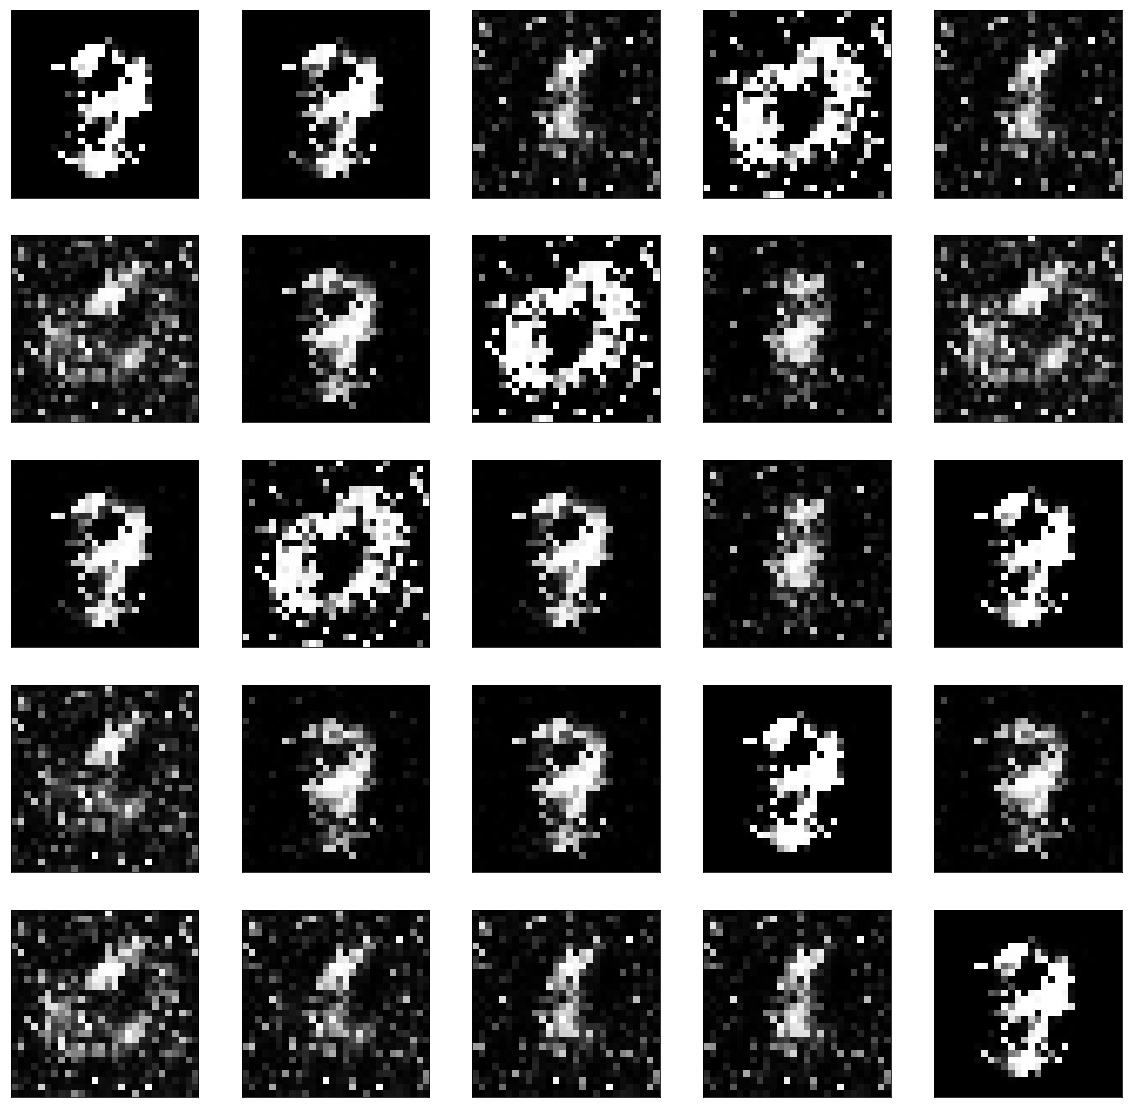

[Epoch 3/10] [Batch 387/938] [Generator loss: 2.836144] [Discriminator loss: 0.449704]
[Epoch 3/10] [Batch 388/938] [Generator loss: 0.790632] [Discriminator loss: 0.409671]
[Epoch 3/10] [Batch 389/938] [Generator loss: 2.405627] [Discriminator loss: 0.310295]
[Epoch 3/10] [Batch 390/938] [Generator loss: 1.221366] [Discriminator loss: 0.269333]
[Epoch 3/10] [Batch 391/938] [Generator loss: 2.043532] [Discriminator loss: 0.241183]
[Epoch 3/10] [Batch 392/938] [Generator loss: 1.436171] [Discriminator loss: 0.260898]
[Epoch 3/10] [Batch 393/938] [Generator loss: 1.494506] [Discriminator loss: 0.252914]
[Epoch 3/10] [Batch 394/938] [Generator loss: 1.592767] [Discriminator loss: 0.275577]
[Epoch 3/10] [Batch 395/938] [Generator loss: 1.269234] [Discriminator loss: 0.392543]
[Epoch 3/10] [Batch 396/938] [Generator loss: 1.160623] [Discriminator loss: 0.363182]
[Epoch 3/10] [Batch 397/938] [Generator loss: 1.987745] [Discriminator loss: 0.424110]
[Epoch 3/10] [Batch 398/938] [Generator los

[Epoch 3/10] [Batch 490/938] [Generator loss: 4.440222] [Discriminator loss: 0.723503]
[Epoch 3/10] [Batch 491/938] [Generator loss: 0.427575] [Discriminator loss: 0.644305]
[Epoch 3/10] [Batch 492/938] [Generator loss: 4.212635] [Discriminator loss: 0.474463]
[Epoch 3/10] [Batch 493/938] [Generator loss: 1.790367] [Discriminator loss: 0.310430]
[Epoch 3/10] [Batch 494/938] [Generator loss: 1.443276] [Discriminator loss: 0.203666]
[Epoch 3/10] [Batch 495/938] [Generator loss: 2.492648] [Discriminator loss: 0.293294]
[Epoch 3/10] [Batch 496/938] [Generator loss: 1.227462] [Discriminator loss: 0.313817]
[Epoch 3/10] [Batch 497/938] [Generator loss: 2.425543] [Discriminator loss: 0.256049]
[Epoch 3/10] [Batch 498/938] [Generator loss: 1.462120] [Discriminator loss: 0.286578]
[Epoch 3/10] [Batch 499/938] [Generator loss: 1.802015] [Discriminator loss: 0.313797]
[Epoch 3/10] [Batch 500/938] [Generator loss: 1.282154] [Discriminator loss: 0.270051]
[Epoch 3/10] [Batch 501/938] [Generator los

[Epoch 3/10] [Batch 589/938] [Generator loss: 1.312033] [Discriminator loss: 0.311827]
[Epoch 3/10] [Batch 590/938] [Generator loss: 1.878137] [Discriminator loss: 0.269714]
[Epoch 3/10] [Batch 591/938] [Generator loss: 1.173765] [Discriminator loss: 0.328631]
[Epoch 3/10] [Batch 592/938] [Generator loss: 1.564133] [Discriminator loss: 0.297679]
[Epoch 3/10] [Batch 593/938] [Generator loss: 1.373365] [Discriminator loss: 0.376751]
[Epoch 3/10] [Batch 594/938] [Generator loss: 1.001257] [Discriminator loss: 0.361855]
[Epoch 3/10] [Batch 595/938] [Generator loss: 2.350165] [Discriminator loss: 0.463870]
[Epoch 3/10] [Batch 596/938] [Generator loss: 0.315922] [Discriminator loss: 0.700016]
[Epoch 3/10] [Batch 597/938] [Generator loss: 5.124576] [Discriminator loss: 1.004741]
[Epoch 3/10] [Batch 598/938] [Generator loss: 1.525541] [Discriminator loss: 0.225780]
[Epoch 3/10] [Batch 599/938] [Generator loss: 0.641002] [Discriminator loss: 0.421855]
[Epoch 3/10] [Batch 600/938] [Generator los

[Epoch 3/10] [Batch 692/938] [Generator loss: 3.658088] [Discriminator loss: 0.550522]
[Epoch 3/10] [Batch 693/938] [Generator loss: 0.799993] [Discriminator loss: 0.368192]
[Epoch 3/10] [Batch 694/938] [Generator loss: 2.463179] [Discriminator loss: 0.214095]
[Epoch 3/10] [Batch 695/938] [Generator loss: 1.783762] [Discriminator loss: 0.236297]
[Epoch 3/10] [Batch 696/938] [Generator loss: 1.063442] [Discriminator loss: 0.327937]
[Epoch 3/10] [Batch 697/938] [Generator loss: 2.550884] [Discriminator loss: 0.319736]
[Epoch 3/10] [Batch 698/938] [Generator loss: 1.017794] [Discriminator loss: 0.344152]
[Epoch 3/10] [Batch 699/938] [Generator loss: 2.427684] [Discriminator loss: 0.324344]
[Epoch 3/10] [Batch 700/938] [Generator loss: 1.044845] [Discriminator loss: 0.380913]
[Epoch 3/10] [Batch 701/938] [Generator loss: 2.510237] [Discriminator loss: 0.481110]
[Epoch 3/10] [Batch 702/938] [Generator loss: 0.644883] [Discriminator loss: 0.517919]
[Epoch 3/10] [Batch 703/938] [Generator los

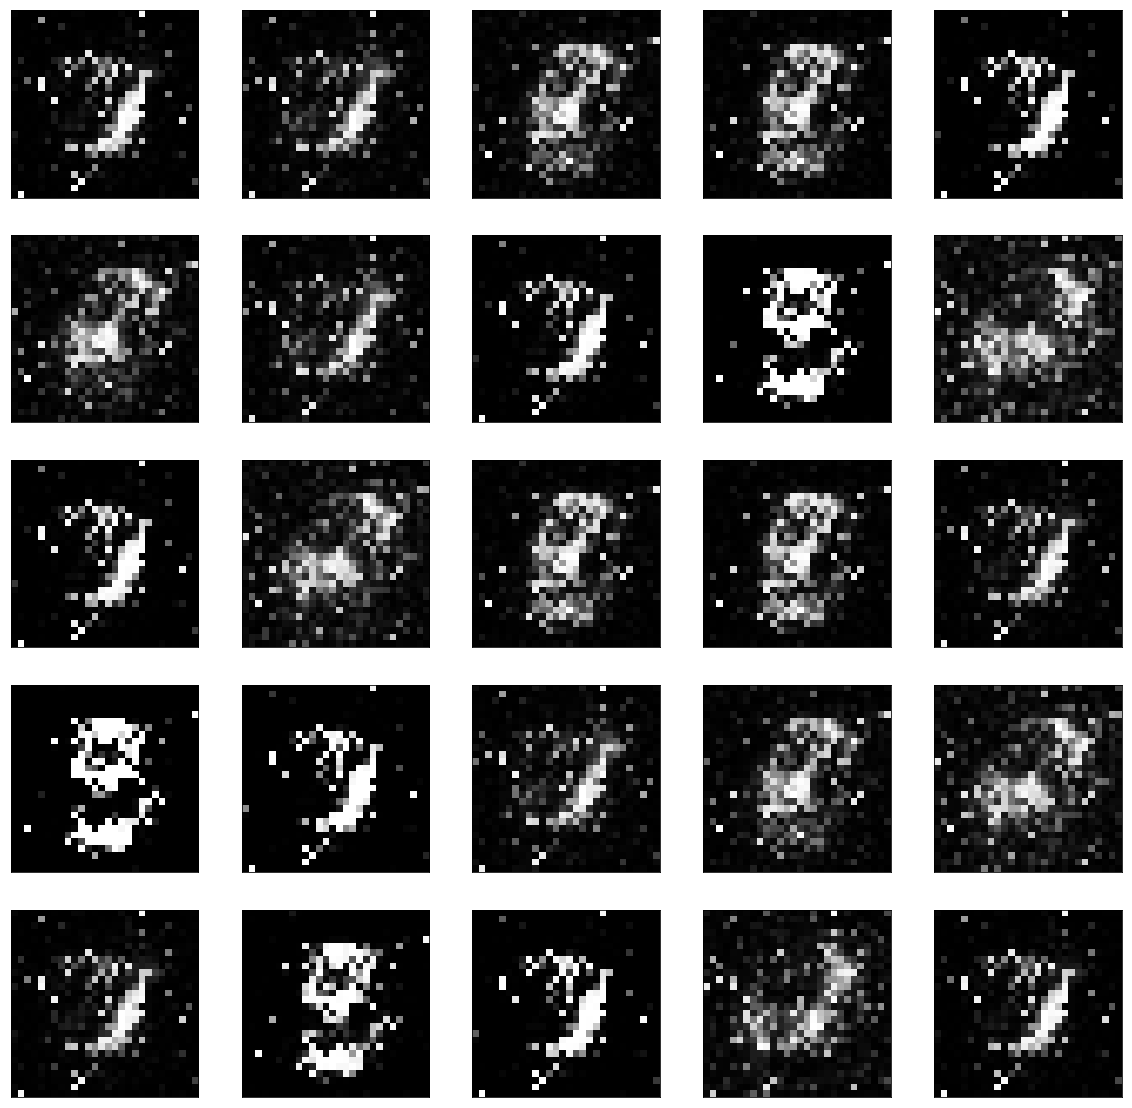

[Epoch 3/10] [Batch 787/938] [Generator loss: 1.317646] [Discriminator loss: 0.325970]
[Epoch 3/10] [Batch 788/938] [Generator loss: 1.565354] [Discriminator loss: 0.345882]
[Epoch 3/10] [Batch 789/938] [Generator loss: 1.149389] [Discriminator loss: 0.284458]
[Epoch 3/10] [Batch 790/938] [Generator loss: 2.539822] [Discriminator loss: 0.324638]
[Epoch 3/10] [Batch 791/938] [Generator loss: 1.087183] [Discriminator loss: 0.326993]
[Epoch 3/10] [Batch 792/938] [Generator loss: 1.863256] [Discriminator loss: 0.340491]
[Epoch 3/10] [Batch 793/938] [Generator loss: 1.117182] [Discriminator loss: 0.337961]
[Epoch 3/10] [Batch 794/938] [Generator loss: 2.087389] [Discriminator loss: 0.305597]
[Epoch 3/10] [Batch 795/938] [Generator loss: 1.054777] [Discriminator loss: 0.332238]
[Epoch 3/10] [Batch 796/938] [Generator loss: 2.373461] [Discriminator loss: 0.319175]
[Epoch 3/10] [Batch 797/938] [Generator loss: 1.181639] [Discriminator loss: 0.296271]
[Epoch 3/10] [Batch 798/938] [Generator los

[Epoch 3/10] [Batch 893/938] [Generator loss: 1.458593] [Discriminator loss: 0.298285]
[Epoch 3/10] [Batch 894/938] [Generator loss: 1.231230] [Discriminator loss: 0.260473]
[Epoch 3/10] [Batch 895/938] [Generator loss: 2.939794] [Discriminator loss: 0.222394]
[Epoch 3/10] [Batch 896/938] [Generator loss: 1.808875] [Discriminator loss: 0.224426]
[Epoch 3/10] [Batch 897/938] [Generator loss: 1.139665] [Discriminator loss: 0.281050]
[Epoch 3/10] [Batch 898/938] [Generator loss: 2.812702] [Discriminator loss: 0.281327]
[Epoch 3/10] [Batch 899/938] [Generator loss: 1.030520] [Discriminator loss: 0.354381]
[Epoch 3/10] [Batch 900/938] [Generator loss: 2.184372] [Discriminator loss: 0.230688]
[Epoch 3/10] [Batch 901/938] [Generator loss: 1.896640] [Discriminator loss: 0.175177]
[Epoch 3/10] [Batch 902/938] [Generator loss: 1.725564] [Discriminator loss: 0.277043]
[Epoch 3/10] [Batch 903/938] [Generator loss: 1.721854] [Discriminator loss: 0.254238]
[Epoch 3/10] [Batch 904/938] [Generator los

[Epoch 4/10] [Batch 51/938] [Generator loss: 0.814785] [Discriminator loss: 0.449910]
[Epoch 4/10] [Batch 52/938] [Generator loss: 2.493453] [Discriminator loss: 0.341116]
[Epoch 4/10] [Batch 53/938] [Generator loss: 0.935677] [Discriminator loss: 0.401998]
[Epoch 4/10] [Batch 54/938] [Generator loss: 3.079921] [Discriminator loss: 0.455275]
[Epoch 4/10] [Batch 55/938] [Generator loss: 0.676181] [Discriminator loss: 0.421268]
[Epoch 4/10] [Batch 56/938] [Generator loss: 3.604458] [Discriminator loss: 0.378466]
[Epoch 4/10] [Batch 57/938] [Generator loss: 1.014976] [Discriminator loss: 0.301503]
[Epoch 4/10] [Batch 58/938] [Generator loss: 2.213922] [Discriminator loss: 0.256588]
[Epoch 4/10] [Batch 59/938] [Generator loss: 1.181336] [Discriminator loss: 0.298170]
[Epoch 4/10] [Batch 60/938] [Generator loss: 2.105662] [Discriminator loss: 0.304915]
[Epoch 4/10] [Batch 61/938] [Generator loss: 0.778105] [Discriminator loss: 0.386225]
[Epoch 4/10] [Batch 62/938] [Generator loss: 3.439023]

[Epoch 4/10] [Batch 155/938] [Generator loss: 0.619773] [Discriminator loss: 0.578419]
[Epoch 4/10] [Batch 156/938] [Generator loss: 3.606907] [Discriminator loss: 0.380214]
[Epoch 4/10] [Batch 157/938] [Generator loss: 1.703339] [Discriminator loss: 0.222418]
[Epoch 4/10] [Batch 158/938] [Generator loss: 1.313323] [Discriminator loss: 0.267730]
[Epoch 4/10] [Batch 159/938] [Generator loss: 2.324495] [Discriminator loss: 0.181442]
[Epoch 4/10] [Batch 160/938] [Generator loss: 1.966938] [Discriminator loss: 0.338586]
[Epoch 4/10] [Batch 161/938] [Generator loss: 0.690766] [Discriminator loss: 0.463330]
[Epoch 4/10] [Batch 162/938] [Generator loss: 3.542169] [Discriminator loss: 0.565685]
[Epoch 4/10] [Batch 163/938] [Generator loss: 0.747764] [Discriminator loss: 0.413218]
[Epoch 4/10] [Batch 164/938] [Generator loss: 2.838562] [Discriminator loss: 0.259640]
[Epoch 4/10] [Batch 165/938] [Generator loss: 2.061790] [Discriminator loss: 0.240816]
[Epoch 4/10] [Batch 166/938] [Generator los

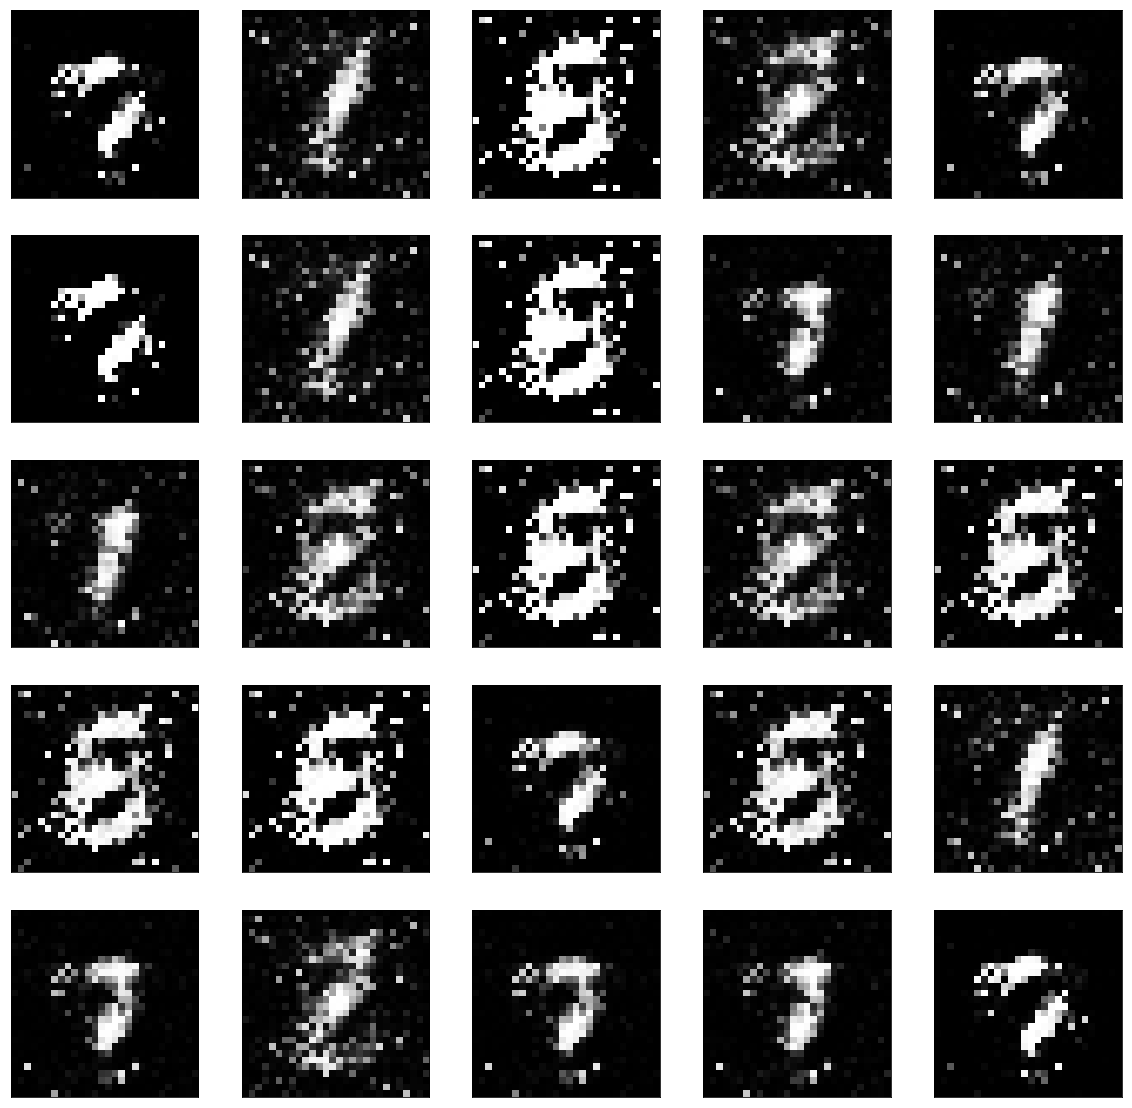

[Epoch 4/10] [Batch 249/938] [Generator loss: 4.259560] [Discriminator loss: 0.722431]
[Epoch 4/10] [Batch 250/938] [Generator loss: 1.468670] [Discriminator loss: 0.303687]
[Epoch 4/10] [Batch 251/938] [Generator loss: 0.785414] [Discriminator loss: 0.410824]
[Epoch 4/10] [Batch 252/938] [Generator loss: 3.323535] [Discriminator loss: 0.318113]
[Epoch 4/10] [Batch 253/938] [Generator loss: 1.865735] [Discriminator loss: 0.220558]
[Epoch 4/10] [Batch 254/938] [Generator loss: 1.079909] [Discriminator loss: 0.310325]
[Epoch 4/10] [Batch 255/938] [Generator loss: 2.441334] [Discriminator loss: 0.224791]
[Epoch 4/10] [Batch 256/938] [Generator loss: 1.825706] [Discriminator loss: 0.211505]
[Epoch 4/10] [Batch 257/938] [Generator loss: 1.461311] [Discriminator loss: 0.240993]
[Epoch 4/10] [Batch 258/938] [Generator loss: 1.935990] [Discriminator loss: 0.262503]
[Epoch 4/10] [Batch 259/938] [Generator loss: 1.397501] [Discriminator loss: 0.240070]
[Epoch 4/10] [Batch 260/938] [Generator los

[Epoch 4/10] [Batch 353/938] [Generator loss: 1.974946] [Discriminator loss: 0.150452]
[Epoch 4/10] [Batch 354/938] [Generator loss: 1.924916] [Discriminator loss: 0.182291]
[Epoch 4/10] [Batch 355/938] [Generator loss: 2.048497] [Discriminator loss: 0.147727]
[Epoch 4/10] [Batch 356/938] [Generator loss: 2.117859] [Discriminator loss: 0.213272]
[Epoch 4/10] [Batch 357/938] [Generator loss: 1.463833] [Discriminator loss: 0.235707]
[Epoch 4/10] [Batch 358/938] [Generator loss: 2.632477] [Discriminator loss: 0.250566]
[Epoch 4/10] [Batch 359/938] [Generator loss: 1.189887] [Discriminator loss: 0.281635]
[Epoch 4/10] [Batch 360/938] [Generator loss: 3.254761] [Discriminator loss: 0.280957]
[Epoch 4/10] [Batch 361/938] [Generator loss: 1.200342] [Discriminator loss: 0.256250]
[Epoch 4/10] [Batch 362/938] [Generator loss: 3.328010] [Discriminator loss: 0.253319]
[Epoch 4/10] [Batch 363/938] [Generator loss: 1.231879] [Discriminator loss: 0.285150]
[Epoch 4/10] [Batch 364/938] [Generator los

[Epoch 4/10] [Batch 459/938] [Generator loss: 1.124967] [Discriminator loss: 0.277879]
[Epoch 4/10] [Batch 460/938] [Generator loss: 3.100622] [Discriminator loss: 0.351975]
[Epoch 4/10] [Batch 461/938] [Generator loss: 1.210753] [Discriminator loss: 0.304614]
[Epoch 4/10] [Batch 462/938] [Generator loss: 1.757149] [Discriminator loss: 0.233628]
[Epoch 4/10] [Batch 463/938] [Generator loss: 2.370935] [Discriminator loss: 0.186356]
[Epoch 4/10] [Batch 464/938] [Generator loss: 1.628591] [Discriminator loss: 0.266215]
[Epoch 4/10] [Batch 465/938] [Generator loss: 1.500933] [Discriminator loss: 0.258641]
[Epoch 4/10] [Batch 466/938] [Generator loss: 2.417448] [Discriminator loss: 0.290193]
[Epoch 4/10] [Batch 467/938] [Generator loss: 0.805949] [Discriminator loss: 0.412109]
[Epoch 4/10] [Batch 468/938] [Generator loss: 4.124017] [Discriminator loss: 0.569084]
[Epoch 4/10] [Batch 469/938] [Generator loss: 0.940300] [Discriminator loss: 0.352328]
[Epoch 4/10] [Batch 470/938] [Generator los

[Epoch 4/10] [Batch 561/938] [Generator loss: 1.681566] [Discriminator loss: 0.275307]
[Epoch 4/10] [Batch 562/938] [Generator loss: 1.365647] [Discriminator loss: 0.299921]
[Epoch 4/10] [Batch 563/938] [Generator loss: 1.455889] [Discriminator loss: 0.247894]
[Epoch 4/10] [Batch 564/938] [Generator loss: 2.093431] [Discriminator loss: 0.376125]
[Epoch 4/10] [Batch 565/938] [Generator loss: 0.638681] [Discriminator loss: 0.516584]
[Epoch 4/10] [Batch 566/938] [Generator loss: 3.451819] [Discriminator loss: 0.566771]
[Epoch 4/10] [Batch 567/938] [Generator loss: 0.672830] [Discriminator loss: 0.398120]
[Epoch 4/10] [Batch 568/938] [Generator loss: 3.295637] [Discriminator loss: 0.344115]
[Epoch 4/10] [Batch 569/938] [Generator loss: 1.282340] [Discriminator loss: 0.281021]
[Epoch 4/10] [Batch 570/938] [Generator loss: 1.603257] [Discriminator loss: 0.163877]
[Epoch 4/10] [Batch 571/938] [Generator loss: 2.735000] [Discriminator loss: 0.233746]
[Epoch 4/10] [Batch 572/938] [Generator los

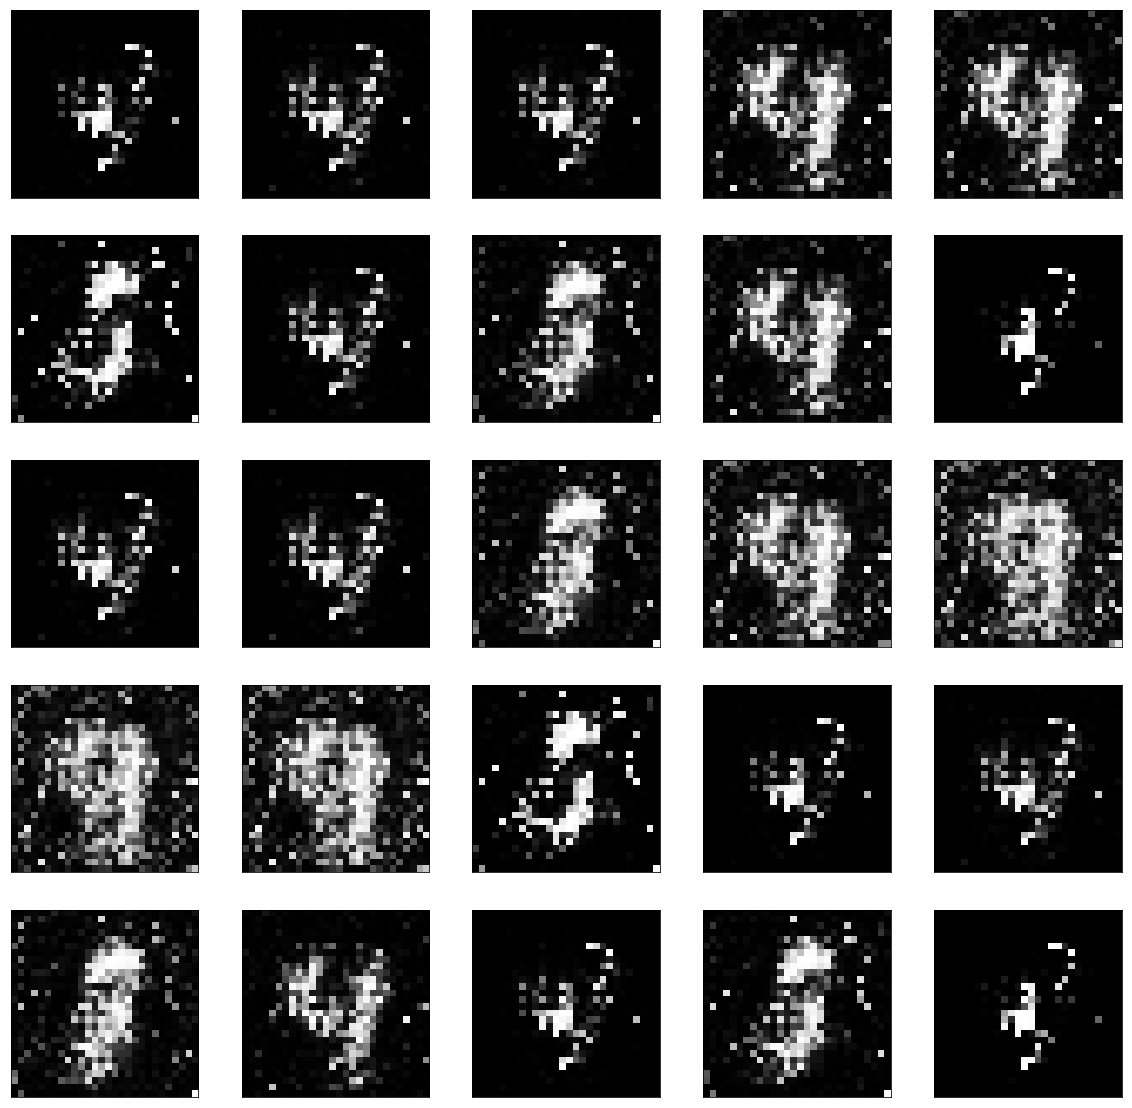

[Epoch 4/10] [Batch 649/938] [Generator loss: 1.040475] [Discriminator loss: 0.374539]
[Epoch 4/10] [Batch 650/938] [Generator loss: 2.180243] [Discriminator loss: 0.198570]
[Epoch 4/10] [Batch 651/938] [Generator loss: 1.739693] [Discriminator loss: 0.276165]
[Epoch 4/10] [Batch 652/938] [Generator loss: 1.377750] [Discriminator loss: 0.298123]
[Epoch 4/10] [Batch 653/938] [Generator loss: 1.792895] [Discriminator loss: 0.334926]
[Epoch 4/10] [Batch 654/938] [Generator loss: 1.084241] [Discriminator loss: 0.428721]
[Epoch 4/10] [Batch 655/938] [Generator loss: 1.397394] [Discriminator loss: 0.297899]
[Epoch 4/10] [Batch 656/938] [Generator loss: 2.144943] [Discriminator loss: 0.361719]
[Epoch 4/10] [Batch 657/938] [Generator loss: 0.502483] [Discriminator loss: 0.559138]
[Epoch 4/10] [Batch 658/938] [Generator loss: 4.904681] [Discriminator loss: 0.898805]
[Epoch 4/10] [Batch 659/938] [Generator loss: 0.688471] [Discriminator loss: 0.433887]
[Epoch 4/10] [Batch 660/938] [Generator los

[Epoch 4/10] [Batch 757/938] [Generator loss: 2.450070] [Discriminator loss: 0.404191]
[Epoch 4/10] [Batch 758/938] [Generator loss: 0.568933] [Discriminator loss: 0.504107]
[Epoch 4/10] [Batch 759/938] [Generator loss: 4.785302] [Discriminator loss: 0.776254]
[Epoch 4/10] [Batch 760/938] [Generator loss: 1.176620] [Discriminator loss: 0.276375]
[Epoch 4/10] [Batch 761/938] [Generator loss: 1.615803] [Discriminator loss: 0.219744]
[Epoch 4/10] [Batch 762/938] [Generator loss: 2.868399] [Discriminator loss: 0.198522]
[Epoch 4/10] [Batch 763/938] [Generator loss: 2.037756] [Discriminator loss: 0.172548]
[Epoch 4/10] [Batch 764/938] [Generator loss: 1.412528] [Discriminator loss: 0.208754]
[Epoch 4/10] [Batch 765/938] [Generator loss: 2.448250] [Discriminator loss: 0.206536]
[Epoch 4/10] [Batch 766/938] [Generator loss: 1.626274] [Discriminator loss: 0.251315]
[Epoch 4/10] [Batch 767/938] [Generator loss: 1.555544] [Discriminator loss: 0.284620]
[Epoch 4/10] [Batch 768/938] [Generator los

[Epoch 4/10] [Batch 862/938] [Generator loss: 0.660828] [Discriminator loss: 0.462700]
[Epoch 4/10] [Batch 863/938] [Generator loss: 3.682045] [Discriminator loss: 0.598173]
[Epoch 4/10] [Batch 864/938] [Generator loss: 1.268267] [Discriminator loss: 0.380417]
[Epoch 4/10] [Batch 865/938] [Generator loss: 0.828383] [Discriminator loss: 0.394488]
[Epoch 4/10] [Batch 866/938] [Generator loss: 2.881978] [Discriminator loss: 0.535426]
[Epoch 4/10] [Batch 867/938] [Generator loss: 0.636534] [Discriminator loss: 0.462114]
[Epoch 4/10] [Batch 868/938] [Generator loss: 2.672535] [Discriminator loss: 0.384883]
[Epoch 4/10] [Batch 869/938] [Generator loss: 1.174879] [Discriminator loss: 0.294468]
[Epoch 4/10] [Batch 870/938] [Generator loss: 1.600106] [Discriminator loss: 0.287490]
[Epoch 4/10] [Batch 871/938] [Generator loss: 1.445401] [Discriminator loss: 0.329730]
[Epoch 4/10] [Batch 872/938] [Generator loss: 1.139769] [Discriminator loss: 0.356476]
[Epoch 4/10] [Batch 873/938] [Generator los

[Epoch 5/10] [Batch 27/938] [Generator loss: 2.397673] [Discriminator loss: 0.195935]
[Epoch 5/10] [Batch 28/938] [Generator loss: 2.678450] [Discriminator loss: 0.307868]
[Epoch 5/10] [Batch 29/938] [Generator loss: 1.189550] [Discriminator loss: 0.299667]
[Epoch 5/10] [Batch 30/938] [Generator loss: 2.351314] [Discriminator loss: 0.294397]
[Epoch 5/10] [Batch 31/938] [Generator loss: 1.447016] [Discriminator loss: 0.224244]
[Epoch 5/10] [Batch 32/938] [Generator loss: 2.503242] [Discriminator loss: 0.249978]
[Epoch 5/10] [Batch 33/938] [Generator loss: 1.601734] [Discriminator loss: 0.254323]
[Epoch 5/10] [Batch 34/938] [Generator loss: 1.568041] [Discriminator loss: 0.372470]
[Epoch 5/10] [Batch 35/938] [Generator loss: 1.738670] [Discriminator loss: 0.345393]
[Epoch 5/10] [Batch 36/938] [Generator loss: 1.332236] [Discriminator loss: 0.262561]
[Epoch 5/10] [Batch 37/938] [Generator loss: 2.856620] [Discriminator loss: 0.327061]
[Epoch 5/10] [Batch 38/938] [Generator loss: 1.217081]

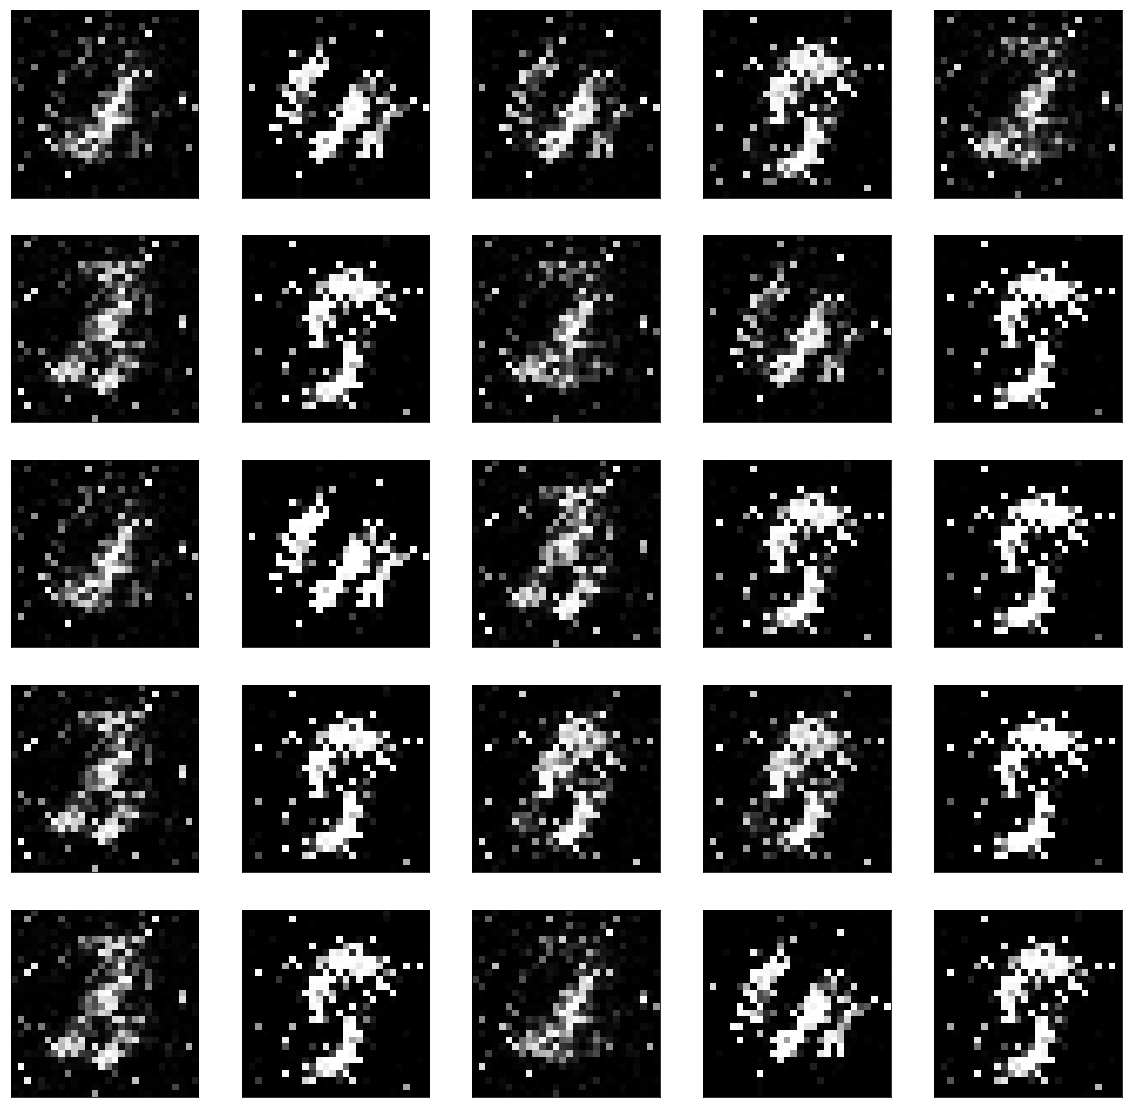

[Epoch 5/10] [Batch 111/938] [Generator loss: 1.480610] [Discriminator loss: 0.182469]
[Epoch 5/10] [Batch 112/938] [Generator loss: 2.537721] [Discriminator loss: 0.120516]
[Epoch 5/10] [Batch 113/938] [Generator loss: 2.203759] [Discriminator loss: 0.151374]
[Epoch 5/10] [Batch 114/938] [Generator loss: 1.699376] [Discriminator loss: 0.185342]
[Epoch 5/10] [Batch 115/938] [Generator loss: 2.741980] [Discriminator loss: 0.274285]
[Epoch 5/10] [Batch 116/938] [Generator loss: 0.814424] [Discriminator loss: 0.328064]
[Epoch 5/10] [Batch 117/938] [Generator loss: 6.060043] [Discriminator loss: 0.812180]
[Epoch 5/10] [Batch 118/938] [Generator loss: 0.459327] [Discriminator loss: 0.606011]
[Epoch 5/10] [Batch 119/938] [Generator loss: 6.406755] [Discriminator loss: 0.583331]
[Epoch 5/10] [Batch 120/938] [Generator loss: 2.851436] [Discriminator loss: 0.068465]
[Epoch 5/10] [Batch 121/938] [Generator loss: 1.264239] [Discriminator loss: 0.218626]
[Epoch 5/10] [Batch 122/938] [Generator los

[Epoch 5/10] [Batch 215/938] [Generator loss: 1.698219] [Discriminator loss: 0.162547]
[Epoch 5/10] [Batch 216/938] [Generator loss: 3.132381] [Discriminator loss: 0.216027]
[Epoch 5/10] [Batch 217/938] [Generator loss: 1.405557] [Discriminator loss: 0.223856]
[Epoch 5/10] [Batch 218/938] [Generator loss: 2.660972] [Discriminator loss: 0.141144]
[Epoch 5/10] [Batch 219/938] [Generator loss: 2.500485] [Discriminator loss: 0.230362]
[Epoch 5/10] [Batch 220/938] [Generator loss: 0.878803] [Discriminator loss: 0.341476]
[Epoch 5/10] [Batch 221/938] [Generator loss: 4.687715] [Discriminator loss: 0.499862]
[Epoch 5/10] [Batch 222/938] [Generator loss: 0.905320] [Discriminator loss: 0.315022]
[Epoch 5/10] [Batch 223/938] [Generator loss: 3.543704] [Discriminator loss: 0.261351]
[Epoch 5/10] [Batch 224/938] [Generator loss: 1.687095] [Discriminator loss: 0.172327]
[Epoch 5/10] [Batch 225/938] [Generator loss: 2.310122] [Discriminator loss: 0.238940]
[Epoch 5/10] [Batch 226/938] [Generator los

[Epoch 5/10] [Batch 316/938] [Generator loss: 2.344706] [Discriminator loss: 0.122124]
[Epoch 5/10] [Batch 317/938] [Generator loss: 2.336166] [Discriminator loss: 0.189447]
[Epoch 5/10] [Batch 318/938] [Generator loss: 1.379349] [Discriminator loss: 0.187060]
[Epoch 5/10] [Batch 319/938] [Generator loss: 3.433275] [Discriminator loss: 0.284089]
[Epoch 5/10] [Batch 320/938] [Generator loss: 1.088423] [Discriminator loss: 0.268961]
[Epoch 5/10] [Batch 321/938] [Generator loss: 3.303557] [Discriminator loss: 0.294089]
[Epoch 5/10] [Batch 322/938] [Generator loss: 1.237605] [Discriminator loss: 0.213452]
[Epoch 5/10] [Batch 323/938] [Generator loss: 3.060865] [Discriminator loss: 0.199391]
[Epoch 5/10] [Batch 324/938] [Generator loss: 2.122596] [Discriminator loss: 0.096660]
[Epoch 5/10] [Batch 325/938] [Generator loss: 2.259930] [Discriminator loss: 0.146096]
[Epoch 5/10] [Batch 326/938] [Generator loss: 1.917658] [Discriminator loss: 0.200734]
[Epoch 5/10] [Batch 327/938] [Generator los

[Epoch 5/10] [Batch 417/938] [Generator loss: 1.108811] [Discriminator loss: 0.258331]
[Epoch 5/10] [Batch 418/938] [Generator loss: 3.377968] [Discriminator loss: 0.415319]
[Epoch 5/10] [Batch 419/938] [Generator loss: 0.428604] [Discriminator loss: 0.594101]
[Epoch 5/10] [Batch 420/938] [Generator loss: 8.516335] [Discriminator loss: 1.596096]
[Epoch 5/10] [Batch 421/938] [Generator loss: 1.262727] [Discriminator loss: 0.272872]
[Epoch 5/10] [Batch 422/938] [Generator loss: 2.021850] [Discriminator loss: 0.135039]
[Epoch 5/10] [Batch 423/938] [Generator loss: 3.796300] [Discriminator loss: 0.119359]
[Epoch 5/10] [Batch 424/938] [Generator loss: 2.817726] [Discriminator loss: 0.088566]
[Epoch 5/10] [Batch 425/938] [Generator loss: 2.847270] [Discriminator loss: 0.133863]
[Epoch 5/10] [Batch 426/938] [Generator loss: 2.079736] [Discriminator loss: 0.206961]
[Epoch 5/10] [Batch 427/938] [Generator loss: 2.030517] [Discriminator loss: 0.231399]
[Epoch 5/10] [Batch 428/938] [Generator los

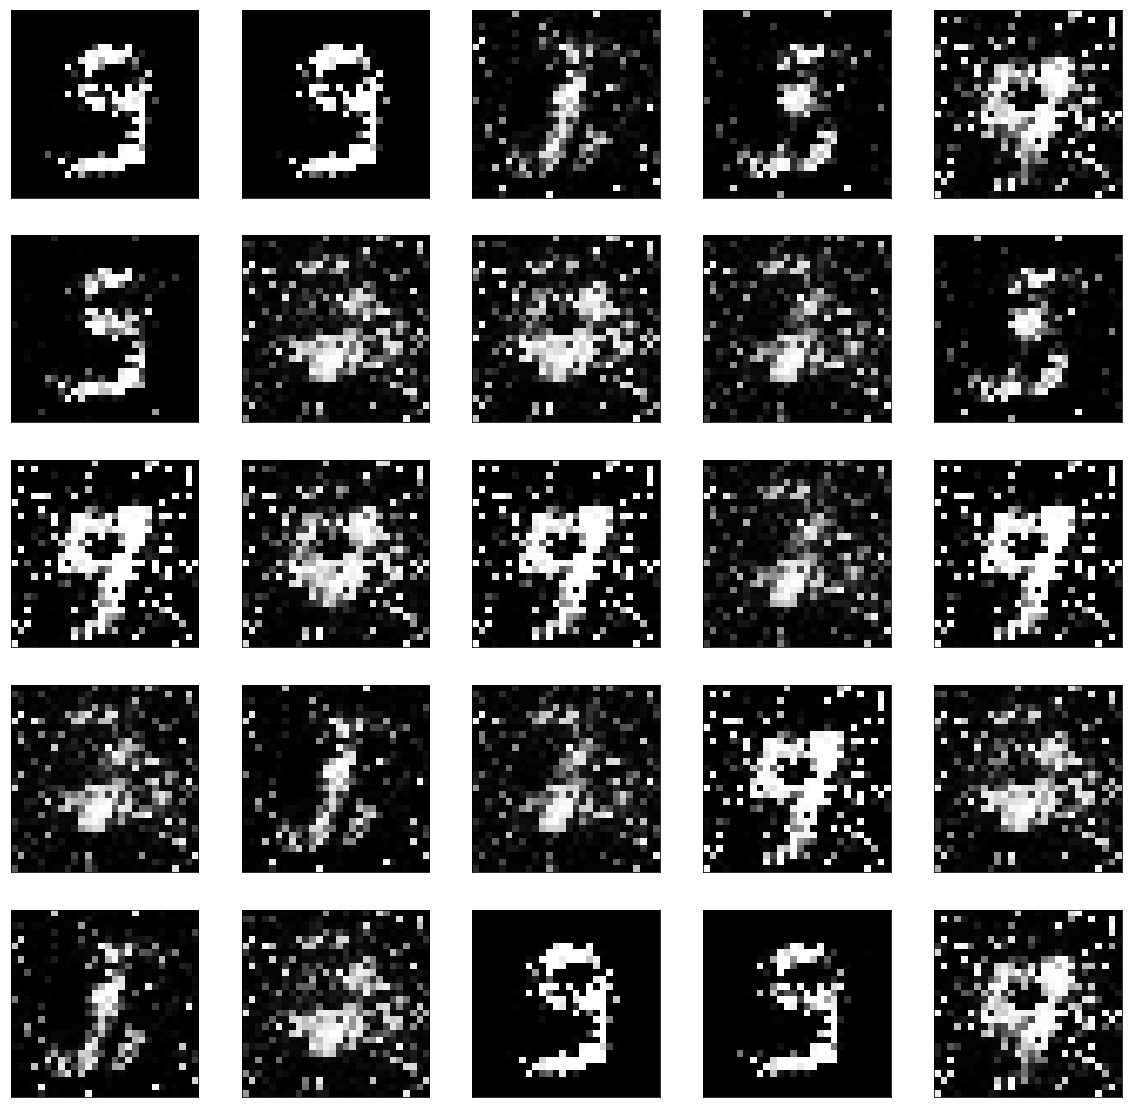

[Epoch 5/10] [Batch 511/938] [Generator loss: 1.956122] [Discriminator loss: 0.183445]
[Epoch 5/10] [Batch 512/938] [Generator loss: 2.334502] [Discriminator loss: 0.186580]
[Epoch 5/10] [Batch 513/938] [Generator loss: 1.883658] [Discriminator loss: 0.176646]
[Epoch 5/10] [Batch 514/938] [Generator loss: 2.176666] [Discriminator loss: 0.185058]
[Epoch 5/10] [Batch 515/938] [Generator loss: 1.987779] [Discriminator loss: 0.145893]
[Epoch 5/10] [Batch 516/938] [Generator loss: 2.524692] [Discriminator loss: 0.177483]
[Epoch 5/10] [Batch 517/938] [Generator loss: 1.579757] [Discriminator loss: 0.208269]
[Epoch 5/10] [Batch 518/938] [Generator loss: 2.023108] [Discriminator loss: 0.168179]
[Epoch 5/10] [Batch 519/938] [Generator loss: 2.134160] [Discriminator loss: 0.199786]
[Epoch 5/10] [Batch 520/938] [Generator loss: 1.271923] [Discriminator loss: 0.243795]
[Epoch 5/10] [Batch 521/938] [Generator loss: 3.202636] [Discriminator loss: 0.335774]
[Epoch 5/10] [Batch 522/938] [Generator los

[Epoch 5/10] [Batch 613/938] [Generator loss: 3.764175] [Discriminator loss: 0.314950]
[Epoch 5/10] [Batch 614/938] [Generator loss: 1.675543] [Discriminator loss: 0.210640]
[Epoch 5/10] [Batch 615/938] [Generator loss: 1.470735] [Discriminator loss: 0.266976]
[Epoch 5/10] [Batch 616/938] [Generator loss: 2.025132] [Discriminator loss: 0.227373]
[Epoch 5/10] [Batch 617/938] [Generator loss: 2.076944] [Discriminator loss: 0.190434]
[Epoch 5/10] [Batch 618/938] [Generator loss: 1.348473] [Discriminator loss: 0.266433]
[Epoch 5/10] [Batch 619/938] [Generator loss: 2.205823] [Discriminator loss: 0.245601]
[Epoch 5/10] [Batch 620/938] [Generator loss: 1.063855] [Discriminator loss: 0.382640]
[Epoch 5/10] [Batch 621/938] [Generator loss: 2.333035] [Discriminator loss: 0.256625]
[Epoch 5/10] [Batch 622/938] [Generator loss: 1.170814] [Discriminator loss: 0.321709]
[Epoch 5/10] [Batch 623/938] [Generator loss: 2.373497] [Discriminator loss: 0.311166]
[Epoch 5/10] [Batch 624/938] [Generator los

[Epoch 5/10] [Batch 718/938] [Generator loss: 1.936824] [Discriminator loss: 0.269576]
[Epoch 5/10] [Batch 719/938] [Generator loss: 1.461701] [Discriminator loss: 0.319080]
[Epoch 5/10] [Batch 720/938] [Generator loss: 1.601027] [Discriminator loss: 0.352670]
[Epoch 5/10] [Batch 721/938] [Generator loss: 1.231023] [Discriminator loss: 0.322007]
[Epoch 5/10] [Batch 722/938] [Generator loss: 2.174732] [Discriminator loss: 0.314873]
[Epoch 5/10] [Batch 723/938] [Generator loss: 0.981069] [Discriminator loss: 0.407064]
[Epoch 5/10] [Batch 724/938] [Generator loss: 2.482943] [Discriminator loss: 0.284042]
[Epoch 5/10] [Batch 725/938] [Generator loss: 0.817415] [Discriminator loss: 0.369157]
[Epoch 5/10] [Batch 726/938] [Generator loss: 3.655940] [Discriminator loss: 0.448011]
[Epoch 5/10] [Batch 727/938] [Generator loss: 0.992430] [Discriminator loss: 0.362139]
[Epoch 5/10] [Batch 728/938] [Generator loss: 2.045201] [Discriminator loss: 0.221289]
[Epoch 5/10] [Batch 729/938] [Generator los

[Epoch 5/10] [Batch 822/938] [Generator loss: 1.857126] [Discriminator loss: 0.262762]
[Epoch 5/10] [Batch 823/938] [Generator loss: 2.010453] [Discriminator loss: 0.246958]
[Epoch 5/10] [Batch 824/938] [Generator loss: 1.558075] [Discriminator loss: 0.225221]
[Epoch 5/10] [Batch 825/938] [Generator loss: 2.409966] [Discriminator loss: 0.224857]
[Epoch 5/10] [Batch 826/938] [Generator loss: 1.714384] [Discriminator loss: 0.232933]
[Epoch 5/10] [Batch 827/938] [Generator loss: 1.643943] [Discriminator loss: 0.242895]
[Epoch 5/10] [Batch 828/938] [Generator loss: 2.175662] [Discriminator loss: 0.287073]
[Epoch 5/10] [Batch 829/938] [Generator loss: 1.310890] [Discriminator loss: 0.258036]
[Epoch 5/10] [Batch 830/938] [Generator loss: 2.276051] [Discriminator loss: 0.311431]
[Epoch 5/10] [Batch 831/938] [Generator loss: 1.275711] [Discriminator loss: 0.273856]
[Epoch 5/10] [Batch 832/938] [Generator loss: 2.264575] [Discriminator loss: 0.257462]
[Epoch 5/10] [Batch 833/938] [Generator los

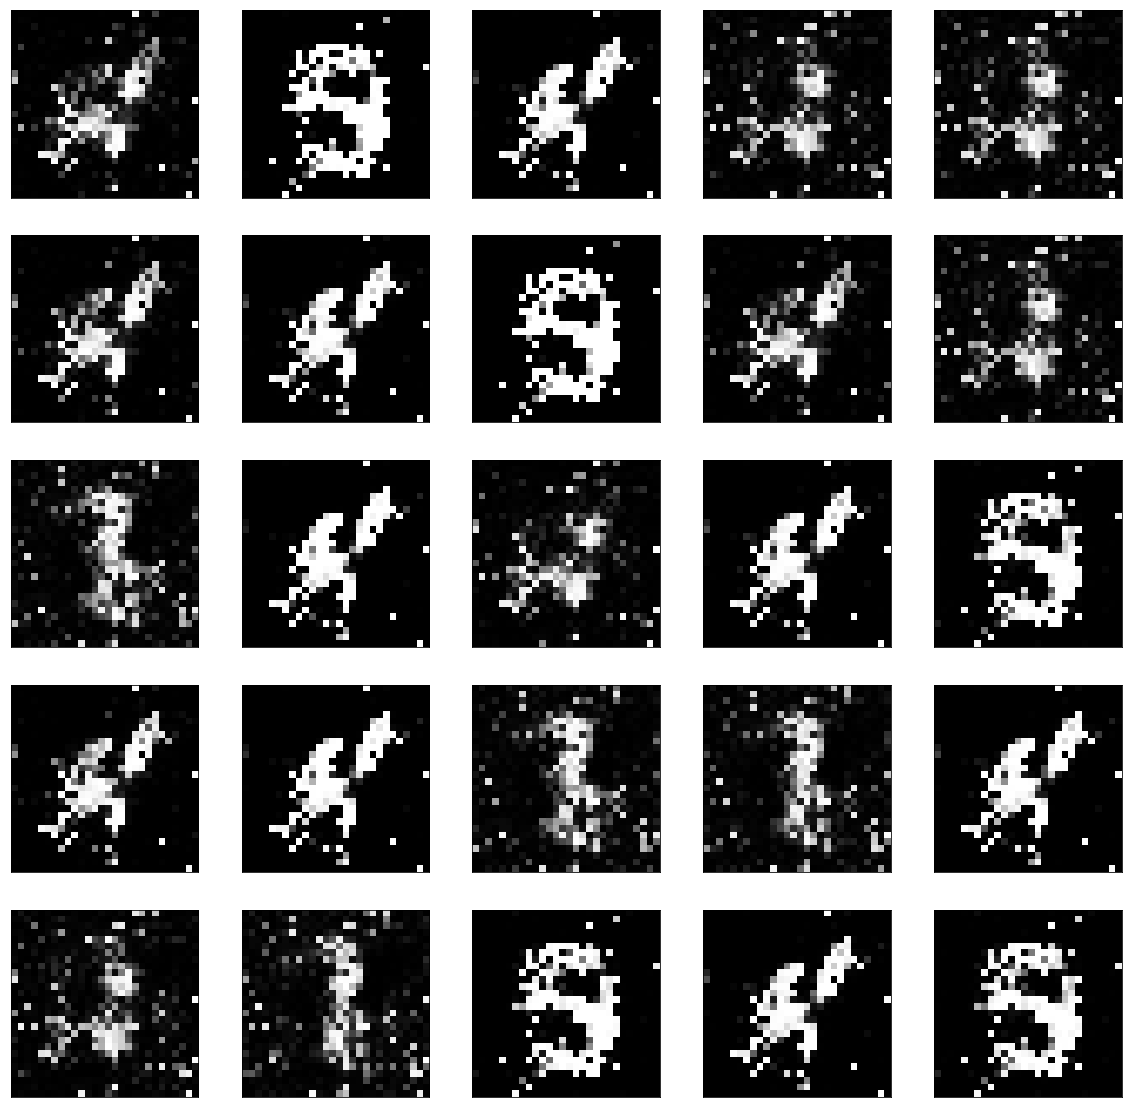

[Epoch 5/10] [Batch 911/938] [Generator loss: 2.491556] [Discriminator loss: 0.131358]
[Epoch 5/10] [Batch 912/938] [Generator loss: 1.684595] [Discriminator loss: 0.159011]
[Epoch 5/10] [Batch 913/938] [Generator loss: 3.512583] [Discriminator loss: 0.183320]
[Epoch 5/10] [Batch 914/938] [Generator loss: 1.618620] [Discriminator loss: 0.181623]
[Epoch 5/10] [Batch 915/938] [Generator loss: 2.698411] [Discriminator loss: 0.122141]
[Epoch 5/10] [Batch 916/938] [Generator loss: 2.362537] [Discriminator loss: 0.200750]
[Epoch 5/10] [Batch 917/938] [Generator loss: 1.070863] [Discriminator loss: 0.310245]
[Epoch 5/10] [Batch 918/938] [Generator loss: 5.234834] [Discriminator loss: 0.512712]
[Epoch 5/10] [Batch 919/938] [Generator loss: 1.038881] [Discriminator loss: 0.270360]
[Epoch 5/10] [Batch 920/938] [Generator loss: 3.713540] [Discriminator loss: 0.156902]
[Epoch 5/10] [Batch 921/938] [Generator loss: 2.405345] [Discriminator loss: 0.094691]
[Epoch 5/10] [Batch 922/938] [Generator los

[Epoch 6/10] [Batch 73/938] [Generator loss: 4.806281] [Discriminator loss: 0.524069]
[Epoch 6/10] [Batch 74/938] [Generator loss: 1.052538] [Discriminator loss: 0.342169]
[Epoch 6/10] [Batch 75/938] [Generator loss: 3.691609] [Discriminator loss: 0.269544]
[Epoch 6/10] [Batch 76/938] [Generator loss: 1.894319] [Discriminator loss: 0.176108]
[Epoch 6/10] [Batch 77/938] [Generator loss: 2.299846] [Discriminator loss: 0.134555]
[Epoch 6/10] [Batch 78/938] [Generator loss: 2.156281] [Discriminator loss: 0.157793]
[Epoch 6/10] [Batch 79/938] [Generator loss: 2.137041] [Discriminator loss: 0.162937]
[Epoch 6/10] [Batch 80/938] [Generator loss: 1.798935] [Discriminator loss: 0.181708]
[Epoch 6/10] [Batch 81/938] [Generator loss: 2.522366] [Discriminator loss: 0.220204]
[Epoch 6/10] [Batch 82/938] [Generator loss: 1.168366] [Discriminator loss: 0.279642]
[Epoch 6/10] [Batch 83/938] [Generator loss: 3.592435] [Discriminator loss: 0.334515]
[Epoch 6/10] [Batch 84/938] [Generator loss: 1.064348]

[Epoch 6/10] [Batch 175/938] [Generator loss: 1.855492] [Discriminator loss: 0.295573]
[Epoch 6/10] [Batch 176/938] [Generator loss: 1.585473] [Discriminator loss: 0.260298]
[Epoch 6/10] [Batch 177/938] [Generator loss: 1.817963] [Discriminator loss: 0.367102]
[Epoch 6/10] [Batch 178/938] [Generator loss: 1.264118] [Discriminator loss: 0.410272]
[Epoch 6/10] [Batch 179/938] [Generator loss: 2.273027] [Discriminator loss: 0.252963]
[Epoch 6/10] [Batch 180/938] [Generator loss: 1.360994] [Discriminator loss: 0.334065]
[Epoch 6/10] [Batch 181/938] [Generator loss: 2.267154] [Discriminator loss: 0.311734]
[Epoch 6/10] [Batch 182/938] [Generator loss: 1.350068] [Discriminator loss: 0.227844]
[Epoch 6/10] [Batch 183/938] [Generator loss: 3.396704] [Discriminator loss: 0.273624]
[Epoch 6/10] [Batch 184/938] [Generator loss: 1.603199] [Discriminator loss: 0.199641]
[Epoch 6/10] [Batch 185/938] [Generator loss: 1.659439] [Discriminator loss: 0.207813]
[Epoch 6/10] [Batch 186/938] [Generator los

[Epoch 6/10] [Batch 279/938] [Generator loss: 3.366779] [Discriminator loss: 0.143734]
[Epoch 6/10] [Batch 280/938] [Generator loss: 3.505935] [Discriminator loss: 0.195911]
[Epoch 6/10] [Batch 281/938] [Generator loss: 2.091674] [Discriminator loss: 0.184366]
[Epoch 6/10] [Batch 282/938] [Generator loss: 2.004752] [Discriminator loss: 0.216103]
[Epoch 6/10] [Batch 283/938] [Generator loss: 2.045274] [Discriminator loss: 0.134319]
[Epoch 6/10] [Batch 284/938] [Generator loss: 2.399225] [Discriminator loss: 0.243070]
[Epoch 6/10] [Batch 285/938] [Generator loss: 1.008376] [Discriminator loss: 0.299831]
[Epoch 6/10] [Batch 286/938] [Generator loss: 3.579456] [Discriminator loss: 0.407786]
[Epoch 6/10] [Batch 287/938] [Generator loss: 1.631886] [Discriminator loss: 0.204648]
[Epoch 6/10] [Batch 288/938] [Generator loss: 1.616975] [Discriminator loss: 0.269820]
[Epoch 6/10] [Batch 289/938] [Generator loss: 2.157707] [Discriminator loss: 0.227156]
[Epoch 6/10] [Batch 290/938] [Generator los

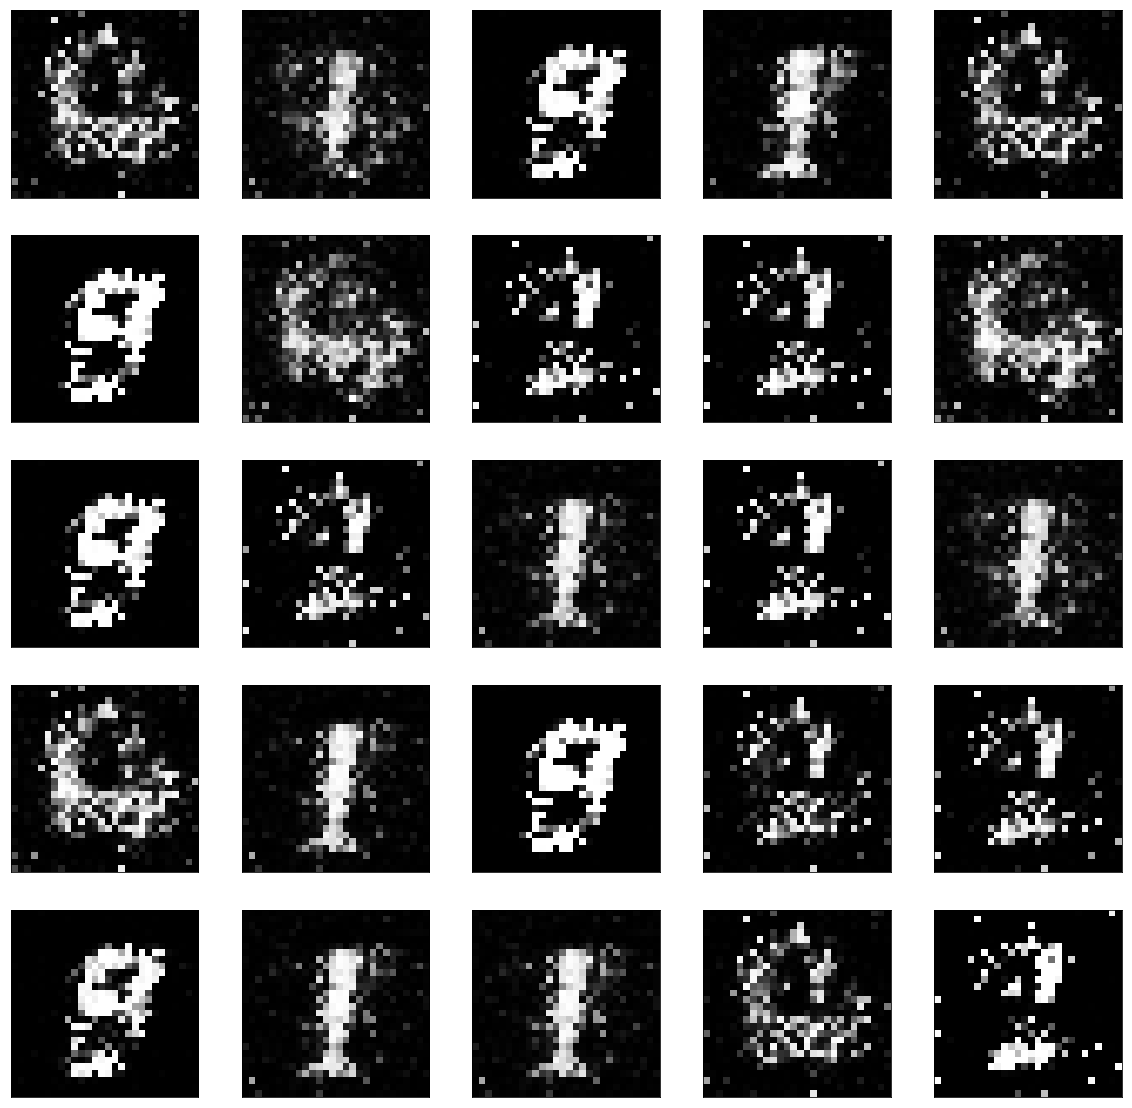

[Epoch 6/10] [Batch 373/938] [Generator loss: 1.567448] [Discriminator loss: 0.264722]
[Epoch 6/10] [Batch 374/938] [Generator loss: 1.915599] [Discriminator loss: 0.272251]
[Epoch 6/10] [Batch 375/938] [Generator loss: 1.432431] [Discriminator loss: 0.321072]
[Epoch 6/10] [Batch 376/938] [Generator loss: 1.821026] [Discriminator loss: 0.327828]
[Epoch 6/10] [Batch 377/938] [Generator loss: 1.254031] [Discriminator loss: 0.277116]
[Epoch 6/10] [Batch 378/938] [Generator loss: 2.857956] [Discriminator loss: 0.360199]
[Epoch 6/10] [Batch 379/938] [Generator loss: 0.568146] [Discriminator loss: 0.547482]
[Epoch 6/10] [Batch 380/938] [Generator loss: 4.851908] [Discriminator loss: 0.715217]
[Epoch 6/10] [Batch 381/938] [Generator loss: 0.928550] [Discriminator loss: 0.334047]
[Epoch 6/10] [Batch 382/938] [Generator loss: 2.860575] [Discriminator loss: 0.273210]
[Epoch 6/10] [Batch 383/938] [Generator loss: 1.357784] [Discriminator loss: 0.306374]
[Epoch 6/10] [Batch 384/938] [Generator los

[Epoch 6/10] [Batch 481/938] [Generator loss: 2.715347] [Discriminator loss: 0.117921]
[Epoch 6/10] [Batch 482/938] [Generator loss: 1.854739] [Discriminator loss: 0.153658]
[Epoch 6/10] [Batch 483/938] [Generator loss: 2.070898] [Discriminator loss: 0.151876]
[Epoch 6/10] [Batch 484/938] [Generator loss: 2.403402] [Discriminator loss: 0.119522]
[Epoch 6/10] [Batch 485/938] [Generator loss: 2.396800] [Discriminator loss: 0.206111]
[Epoch 6/10] [Batch 486/938] [Generator loss: 1.507519] [Discriminator loss: 0.192494]
[Epoch 6/10] [Batch 487/938] [Generator loss: 2.675876] [Discriminator loss: 0.289343]
[Epoch 6/10] [Batch 488/938] [Generator loss: 1.245032] [Discriminator loss: 0.248646]
[Epoch 6/10] [Batch 489/938] [Generator loss: 2.783312] [Discriminator loss: 0.247865]
[Epoch 6/10] [Batch 490/938] [Generator loss: 1.580593] [Discriminator loss: 0.230610]
[Epoch 6/10] [Batch 491/938] [Generator loss: 1.726107] [Discriminator loss: 0.265584]
[Epoch 6/10] [Batch 492/938] [Generator los

[Epoch 6/10] [Batch 582/938] [Generator loss: 2.341548] [Discriminator loss: 0.240775]
[Epoch 6/10] [Batch 583/938] [Generator loss: 1.570422] [Discriminator loss: 0.280953]
[Epoch 6/10] [Batch 584/938] [Generator loss: 1.610936] [Discriminator loss: 0.165641]
[Epoch 6/10] [Batch 585/938] [Generator loss: 3.177876] [Discriminator loss: 0.234291]
[Epoch 6/10] [Batch 586/938] [Generator loss: 1.161179] [Discriminator loss: 0.259624]
[Epoch 6/10] [Batch 587/938] [Generator loss: 2.741331] [Discriminator loss: 0.343500]
[Epoch 6/10] [Batch 588/938] [Generator loss: 0.639024] [Discriminator loss: 0.489301]
[Epoch 6/10] [Batch 589/938] [Generator loss: 5.125952] [Discriminator loss: 0.713924]
[Epoch 6/10] [Batch 590/938] [Generator loss: 1.151296] [Discriminator loss: 0.247779]
[Epoch 6/10] [Batch 591/938] [Generator loss: 2.237211] [Discriminator loss: 0.180731]
[Epoch 6/10] [Batch 592/938] [Generator loss: 2.133575] [Discriminator loss: 0.166086]
[Epoch 6/10] [Batch 593/938] [Generator los

[Epoch 6/10] [Batch 688/938] [Generator loss: 2.128041] [Discriminator loss: 0.157113]
[Epoch 6/10] [Batch 689/938] [Generator loss: 1.969018] [Discriminator loss: 0.167337]
[Epoch 6/10] [Batch 690/938] [Generator loss: 1.655564] [Discriminator loss: 0.142227]
[Epoch 6/10] [Batch 691/938] [Generator loss: 2.946445] [Discriminator loss: 0.365785]
[Epoch 6/10] [Batch 692/938] [Generator loss: 0.582455] [Discriminator loss: 0.498809]
[Epoch 6/10] [Batch 693/938] [Generator loss: 5.244895] [Discriminator loss: 0.586833]
[Epoch 6/10] [Batch 694/938] [Generator loss: 2.519307] [Discriminator loss: 0.155496]
[Epoch 6/10] [Batch 695/938] [Generator loss: 0.761646] [Discriminator loss: 0.412896]
[Epoch 6/10] [Batch 696/938] [Generator loss: 5.136410] [Discriminator loss: 0.346162]
[Epoch 6/10] [Batch 697/938] [Generator loss: 2.952380] [Discriminator loss: 0.139946]
[Epoch 6/10] [Batch 698/938] [Generator loss: 1.068280] [Discriminator loss: 0.280826]
[Epoch 6/10] [Batch 699/938] [Generator los

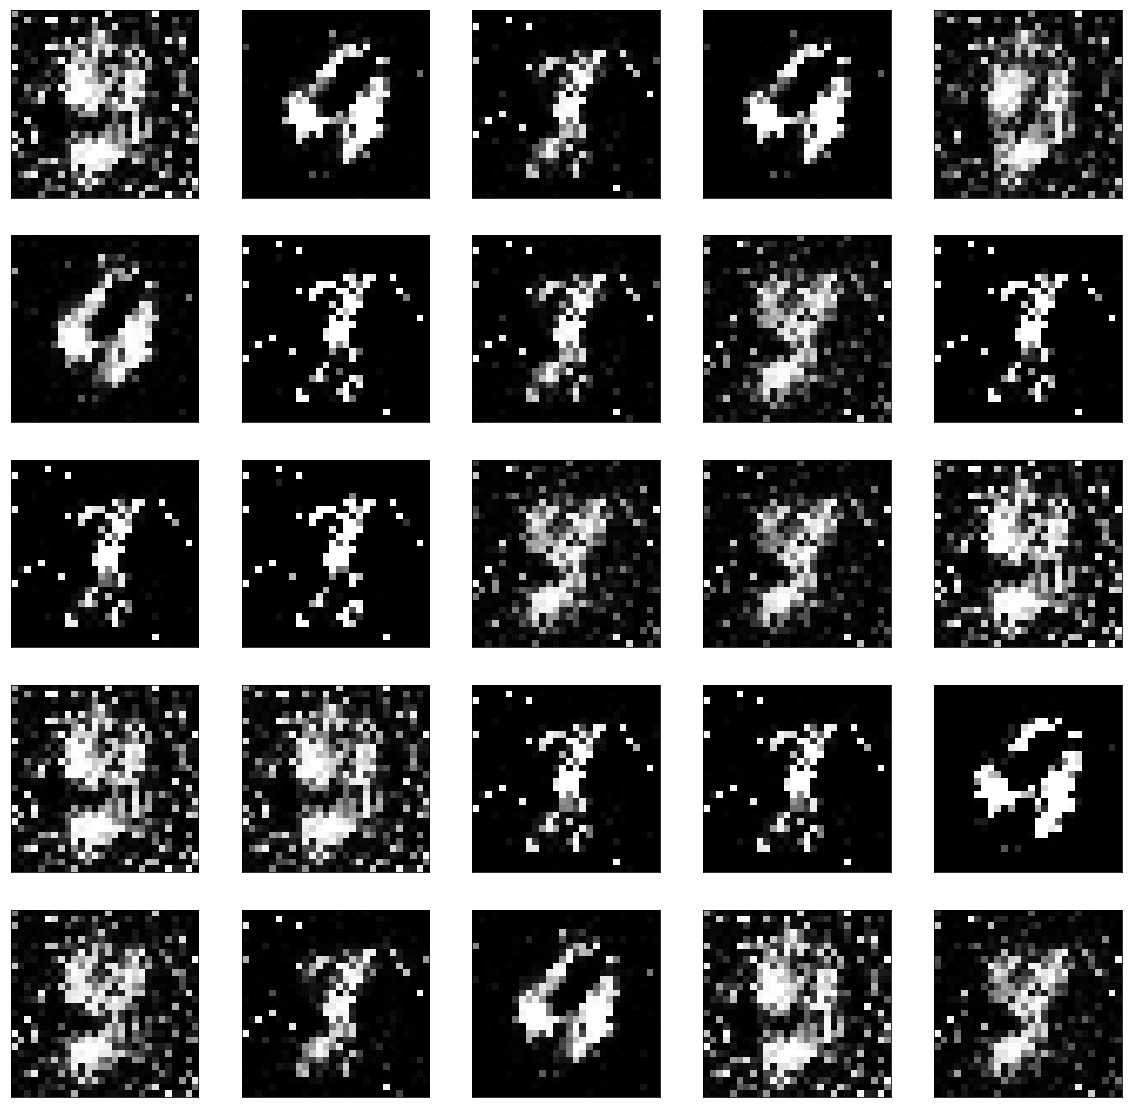

[Epoch 6/10] [Batch 773/938] [Generator loss: 1.692961] [Discriminator loss: 0.220732]
[Epoch 6/10] [Batch 774/938] [Generator loss: 1.973446] [Discriminator loss: 0.197094]
[Epoch 6/10] [Batch 775/938] [Generator loss: 1.848501] [Discriminator loss: 0.200075]
[Epoch 6/10] [Batch 776/938] [Generator loss: 2.065160] [Discriminator loss: 0.155298]
[Epoch 6/10] [Batch 777/938] [Generator loss: 2.296462] [Discriminator loss: 0.152511]
[Epoch 6/10] [Batch 778/938] [Generator loss: 1.650296] [Discriminator loss: 0.297483]
[Epoch 6/10] [Batch 779/938] [Generator loss: 1.437872] [Discriminator loss: 0.287537]
[Epoch 6/10] [Batch 780/938] [Generator loss: 2.677095] [Discriminator loss: 0.303773]
[Epoch 6/10] [Batch 781/938] [Generator loss: 0.670389] [Discriminator loss: 0.427372]
[Epoch 6/10] [Batch 782/938] [Generator loss: 6.326191] [Discriminator loss: 0.893086]
[Epoch 6/10] [Batch 783/938] [Generator loss: 1.238975] [Discriminator loss: 0.257048]
[Epoch 6/10] [Batch 784/938] [Generator los

[Epoch 6/10] [Batch 869/938] [Generator loss: 2.175529] [Discriminator loss: 0.349367]
[Epoch 6/10] [Batch 870/938] [Generator loss: 0.969155] [Discriminator loss: 0.392016]
[Epoch 6/10] [Batch 871/938] [Generator loss: 3.660476] [Discriminator loss: 0.353741]
[Epoch 6/10] [Batch 872/938] [Generator loss: 1.434108] [Discriminator loss: 0.292639]
[Epoch 6/10] [Batch 873/938] [Generator loss: 1.566170] [Discriminator loss: 0.259594]
[Epoch 6/10] [Batch 874/938] [Generator loss: 2.498731] [Discriminator loss: 0.200098]
[Epoch 6/10] [Batch 875/938] [Generator loss: 2.046983] [Discriminator loss: 0.213077]
[Epoch 6/10] [Batch 876/938] [Generator loss: 1.581835] [Discriminator loss: 0.269504]
[Epoch 6/10] [Batch 877/938] [Generator loss: 1.590059] [Discriminator loss: 0.288975]
[Epoch 6/10] [Batch 878/938] [Generator loss: 1.684704] [Discriminator loss: 0.225918]
[Epoch 6/10] [Batch 879/938] [Generator loss: 2.172483] [Discriminator loss: 0.371911]
[Epoch 6/10] [Batch 880/938] [Generator los

[Epoch 7/10] [Batch 38/938] [Generator loss: 3.312766] [Discriminator loss: 0.097494]
[Epoch 7/10] [Batch 39/938] [Generator loss: 3.125093] [Discriminator loss: 0.128854]
[Epoch 7/10] [Batch 40/938] [Generator loss: 2.289435] [Discriminator loss: 0.142321]
[Epoch 7/10] [Batch 41/938] [Generator loss: 2.092348] [Discriminator loss: 0.113557]
[Epoch 7/10] [Batch 42/938] [Generator loss: 2.471386] [Discriminator loss: 0.113547]
[Epoch 7/10] [Batch 43/938] [Generator loss: 2.584958] [Discriminator loss: 0.126659]
[Epoch 7/10] [Batch 44/938] [Generator loss: 1.807601] [Discriminator loss: 0.181773]
[Epoch 7/10] [Batch 45/938] [Generator loss: 2.316224] [Discriminator loss: 0.228410]
[Epoch 7/10] [Batch 46/938] [Generator loss: 1.924114] [Discriminator loss: 0.162114]
[Epoch 7/10] [Batch 47/938] [Generator loss: 2.339865] [Discriminator loss: 0.107097]
[Epoch 7/10] [Batch 48/938] [Generator loss: 2.442537] [Discriminator loss: 0.269190]
[Epoch 7/10] [Batch 49/938] [Generator loss: 1.453786]

[Epoch 7/10] [Batch 137/938] [Generator loss: 2.191888] [Discriminator loss: 0.186959]
[Epoch 7/10] [Batch 138/938] [Generator loss: 1.388479] [Discriminator loss: 0.195900]
[Epoch 7/10] [Batch 139/938] [Generator loss: 4.033969] [Discriminator loss: 0.317347]
[Epoch 7/10] [Batch 140/938] [Generator loss: 1.092422] [Discriminator loss: 0.235171]
[Epoch 7/10] [Batch 141/938] [Generator loss: 3.747880] [Discriminator loss: 0.289019]
[Epoch 7/10] [Batch 142/938] [Generator loss: 1.617721] [Discriminator loss: 0.203219]
[Epoch 7/10] [Batch 143/938] [Generator loss: 2.206001] [Discriminator loss: 0.132121]
[Epoch 7/10] [Batch 144/938] [Generator loss: 2.750216] [Discriminator loss: 0.155117]
[Epoch 7/10] [Batch 145/938] [Generator loss: 1.788573] [Discriminator loss: 0.131302]
[Epoch 7/10] [Batch 146/938] [Generator loss: 2.850372] [Discriminator loss: 0.159123]
[Epoch 7/10] [Batch 147/938] [Generator loss: 1.914799] [Discriminator loss: 0.192470]
[Epoch 7/10] [Batch 148/938] [Generator los

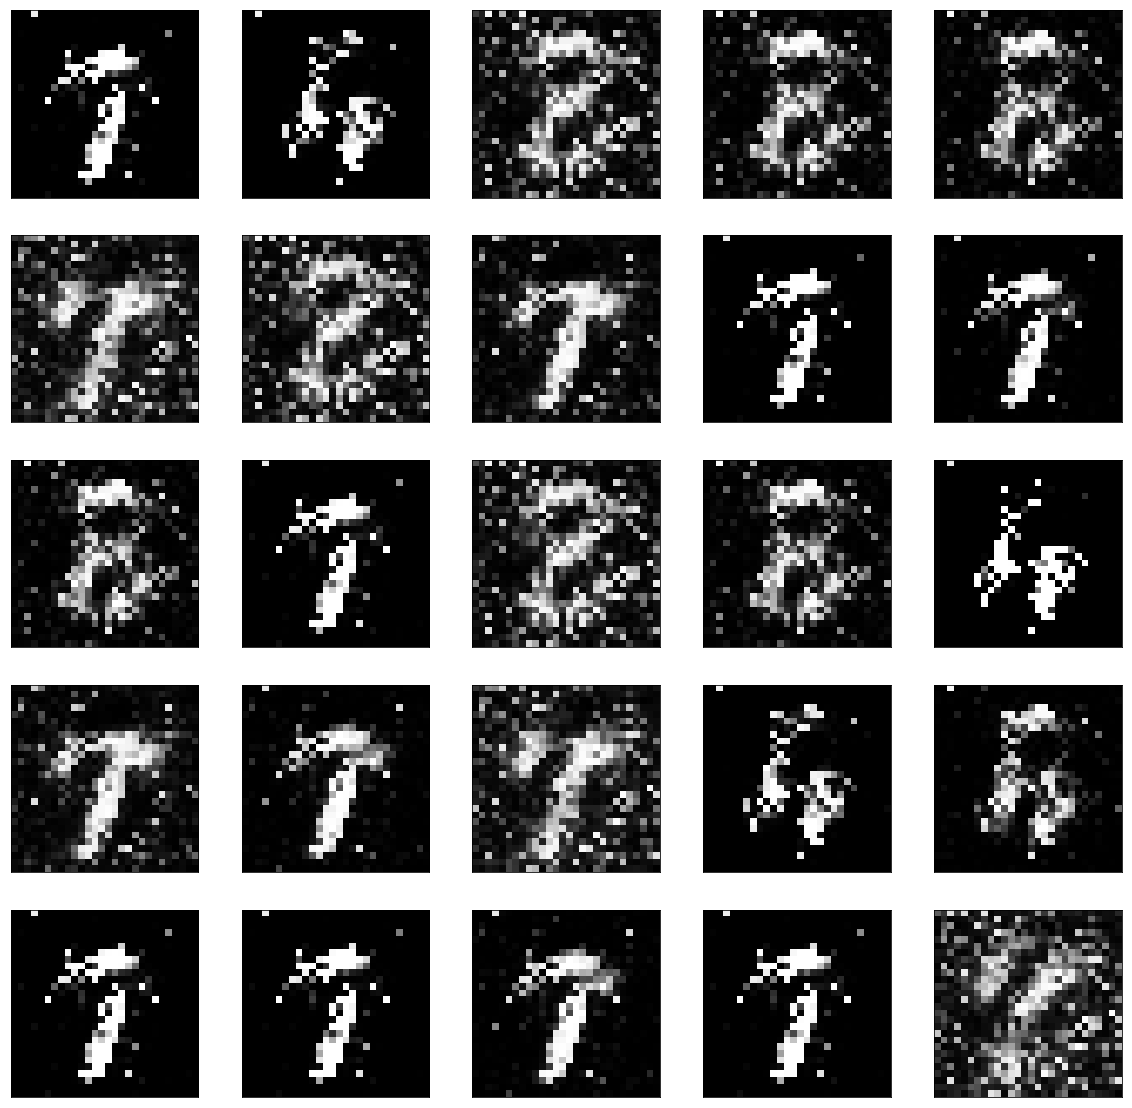

[Epoch 7/10] [Batch 235/938] [Generator loss: 1.664008] [Discriminator loss: 0.220137]
[Epoch 7/10] [Batch 236/938] [Generator loss: 2.219722] [Discriminator loss: 0.218069]
[Epoch 7/10] [Batch 237/938] [Generator loss: 1.547439] [Discriminator loss: 0.279845]
[Epoch 7/10] [Batch 238/938] [Generator loss: 1.632368] [Discriminator loss: 0.298313]
[Epoch 7/10] [Batch 239/938] [Generator loss: 1.819707] [Discriminator loss: 0.282969]
[Epoch 7/10] [Batch 240/938] [Generator loss: 1.530980] [Discriminator loss: 0.213141]
[Epoch 7/10] [Batch 241/938] [Generator loss: 2.416101] [Discriminator loss: 0.221881]
[Epoch 7/10] [Batch 242/938] [Generator loss: 1.534095] [Discriminator loss: 0.285647]
[Epoch 7/10] [Batch 243/938] [Generator loss: 1.519794] [Discriminator loss: 0.242181]
[Epoch 7/10] [Batch 244/938] [Generator loss: 2.179403] [Discriminator loss: 0.193994]
[Epoch 7/10] [Batch 245/938] [Generator loss: 1.531838] [Discriminator loss: 0.234215]
[Epoch 7/10] [Batch 246/938] [Generator los

[Epoch 7/10] [Batch 336/938] [Generator loss: 3.562317] [Discriminator loss: 0.423163]
[Epoch 7/10] [Batch 337/938] [Generator loss: 0.784709] [Discriminator loss: 0.377233]
[Epoch 7/10] [Batch 338/938] [Generator loss: 3.847227] [Discriminator loss: 0.447592]
[Epoch 7/10] [Batch 339/938] [Generator loss: 1.363655] [Discriminator loss: 0.264646]
[Epoch 7/10] [Batch 340/938] [Generator loss: 1.897582] [Discriminator loss: 0.276115]
[Epoch 7/10] [Batch 341/938] [Generator loss: 1.570691] [Discriminator loss: 0.287690]
[Epoch 7/10] [Batch 342/938] [Generator loss: 2.134393] [Discriminator loss: 0.293211]
[Epoch 7/10] [Batch 343/938] [Generator loss: 1.199231] [Discriminator loss: 0.331568]
[Epoch 7/10] [Batch 344/938] [Generator loss: 2.799001] [Discriminator loss: 0.350119]
[Epoch 7/10] [Batch 345/938] [Generator loss: 1.352139] [Discriminator loss: 0.331773]
[Epoch 7/10] [Batch 346/938] [Generator loss: 2.285460] [Discriminator loss: 0.211147]
[Epoch 7/10] [Batch 347/938] [Generator los

[Epoch 7/10] [Batch 436/938] [Generator loss: 0.742737] [Discriminator loss: 0.415937]
[Epoch 7/10] [Batch 437/938] [Generator loss: 5.061913] [Discriminator loss: 0.796165]
[Epoch 7/10] [Batch 438/938] [Generator loss: 0.494094] [Discriminator loss: 0.589293]
[Epoch 7/10] [Batch 439/938] [Generator loss: 4.774967] [Discriminator loss: 0.383306]
[Epoch 7/10] [Batch 440/938] [Generator loss: 2.515097] [Discriminator loss: 0.165051]
[Epoch 7/10] [Batch 441/938] [Generator loss: 0.795424] [Discriminator loss: 0.356980]
[Epoch 7/10] [Batch 442/938] [Generator loss: 4.605306] [Discriminator loss: 0.596683]
[Epoch 7/10] [Batch 443/938] [Generator loss: 1.470883] [Discriminator loss: 0.216147]
[Epoch 7/10] [Batch 444/938] [Generator loss: 1.555664] [Discriminator loss: 0.216441]
[Epoch 7/10] [Batch 445/938] [Generator loss: 2.836440] [Discriminator loss: 0.138337]
[Epoch 7/10] [Batch 446/938] [Generator loss: 2.290875] [Discriminator loss: 0.215456]
[Epoch 7/10] [Batch 447/938] [Generator los

[Epoch 7/10] [Batch 537/938] [Generator loss: 1.095646] [Discriminator loss: 0.299503]
[Epoch 7/10] [Batch 538/938] [Generator loss: 3.441282] [Discriminator loss: 0.266537]
[Epoch 7/10] [Batch 539/938] [Generator loss: 1.832673] [Discriminator loss: 0.194245]
[Epoch 7/10] [Batch 540/938] [Generator loss: 1.454811] [Discriminator loss: 0.232708]
[Epoch 7/10] [Batch 541/938] [Generator loss: 2.711439] [Discriminator loss: 0.246205]
[Epoch 7/10] [Batch 542/938] [Generator loss: 1.339156] [Discriminator loss: 0.282202]
[Epoch 7/10] [Batch 543/938] [Generator loss: 1.963881] [Discriminator loss: 0.234130]
[Epoch 7/10] [Batch 544/938] [Generator loss: 2.034050] [Discriminator loss: 0.221802]
[Epoch 7/10] [Batch 545/938] [Generator loss: 1.478884] [Discriminator loss: 0.220080]
[Epoch 7/10] [Batch 546/938] [Generator loss: 2.628131] [Discriminator loss: 0.304456]
[Epoch 7/10] [Batch 547/938] [Generator loss: 1.164098] [Discriminator loss: 0.272315]
[Epoch 7/10] [Batch 548/938] [Generator los

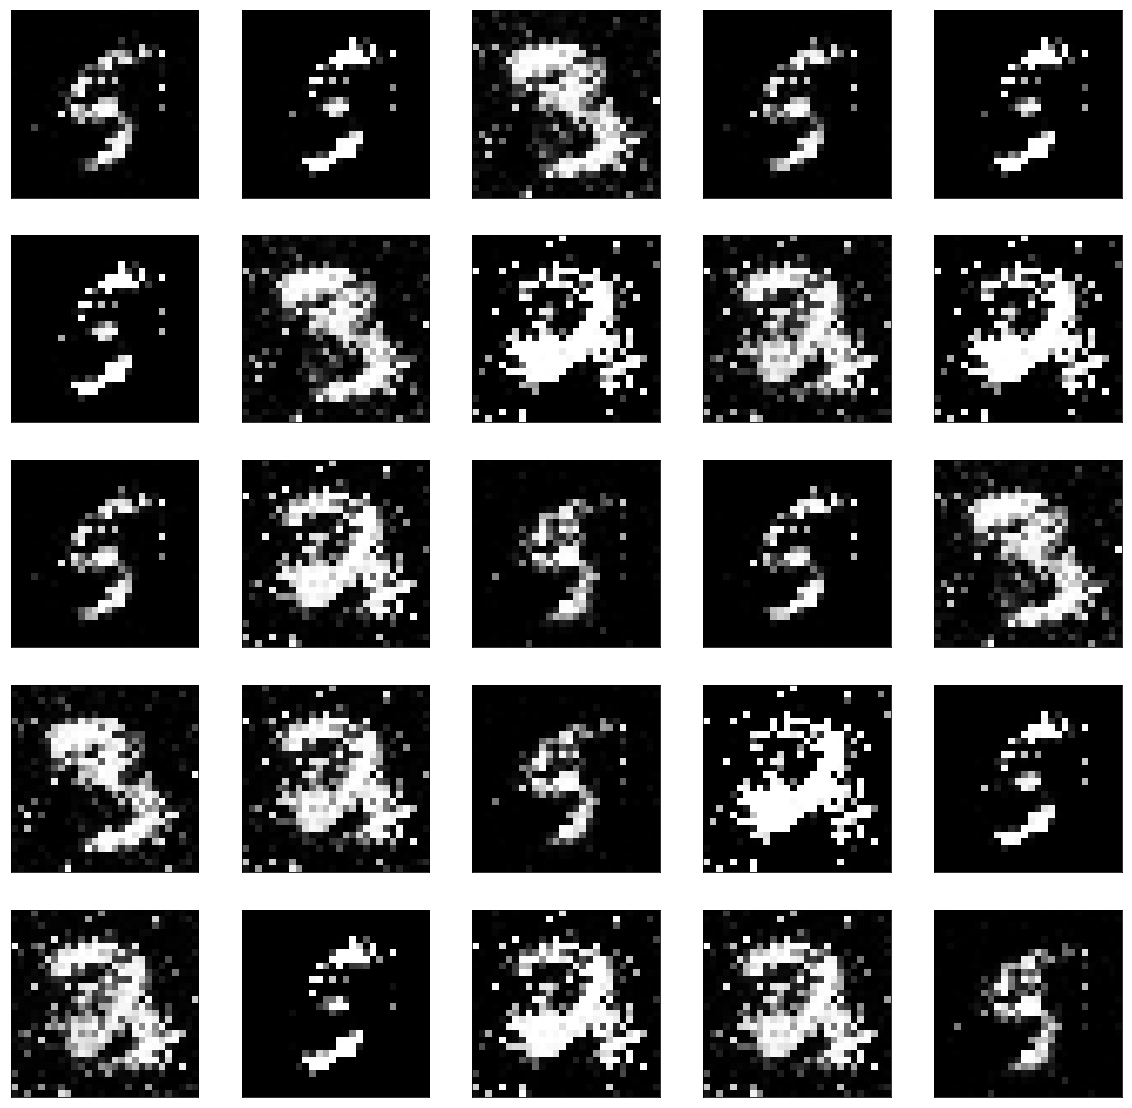

[Epoch 7/10] [Batch 635/938] [Generator loss: 3.285450] [Discriminator loss: 0.310255]
[Epoch 7/10] [Batch 636/938] [Generator loss: 0.961251] [Discriminator loss: 0.289116]
[Epoch 7/10] [Batch 637/938] [Generator loss: 3.992058] [Discriminator loss: 0.299377]
[Epoch 7/10] [Batch 638/938] [Generator loss: 2.118429] [Discriminator loss: 0.215584]
[Epoch 7/10] [Batch 639/938] [Generator loss: 0.833766] [Discriminator loss: 0.397660]
[Epoch 7/10] [Batch 640/938] [Generator loss: 4.272910] [Discriminator loss: 0.329005]
[Epoch 7/10] [Batch 641/938] [Generator loss: 2.738070] [Discriminator loss: 0.259341]
[Epoch 7/10] [Batch 642/938] [Generator loss: 0.814313] [Discriminator loss: 0.416494]
[Epoch 7/10] [Batch 643/938] [Generator loss: 4.223341] [Discriminator loss: 0.322804]
[Epoch 7/10] [Batch 644/938] [Generator loss: 2.701929] [Discriminator loss: 0.247703]
[Epoch 7/10] [Batch 645/938] [Generator loss: 1.244584] [Discriminator loss: 0.265944]
[Epoch 7/10] [Batch 646/938] [Generator los

[Epoch 7/10] [Batch 739/938] [Generator loss: 3.853056] [Discriminator loss: 0.356216]
[Epoch 7/10] [Batch 740/938] [Generator loss: 1.490264] [Discriminator loss: 0.195024]
[Epoch 7/10] [Batch 741/938] [Generator loss: 1.795907] [Discriminator loss: 0.253804]
[Epoch 7/10] [Batch 742/938] [Generator loss: 1.347081] [Discriminator loss: 0.265478]
[Epoch 7/10] [Batch 743/938] [Generator loss: 3.054117] [Discriminator loss: 0.254122]
[Epoch 7/10] [Batch 744/938] [Generator loss: 1.251152] [Discriminator loss: 0.232999]
[Epoch 7/10] [Batch 745/938] [Generator loss: 2.595465] [Discriminator loss: 0.172409]
[Epoch 7/10] [Batch 746/938] [Generator loss: 1.900860] [Discriminator loss: 0.172321]
[Epoch 7/10] [Batch 747/938] [Generator loss: 1.727014] [Discriminator loss: 0.286530]
[Epoch 7/10] [Batch 748/938] [Generator loss: 1.265923] [Discriminator loss: 0.315844]
[Epoch 7/10] [Batch 749/938] [Generator loss: 2.783822] [Discriminator loss: 0.363190]
[Epoch 7/10] [Batch 750/938] [Generator los

[Epoch 7/10] [Batch 844/938] [Generator loss: 1.976482] [Discriminator loss: 0.233110]
[Epoch 7/10] [Batch 845/938] [Generator loss: 1.574719] [Discriminator loss: 0.217958]
[Epoch 7/10] [Batch 846/938] [Generator loss: 2.423030] [Discriminator loss: 0.201259]
[Epoch 7/10] [Batch 847/938] [Generator loss: 1.917124] [Discriminator loss: 0.247063]
[Epoch 7/10] [Batch 848/938] [Generator loss: 1.086603] [Discriminator loss: 0.371107]
[Epoch 7/10] [Batch 849/938] [Generator loss: 2.934521] [Discriminator loss: 0.346172]
[Epoch 7/10] [Batch 850/938] [Generator loss: 1.239743] [Discriminator loss: 0.273741]
[Epoch 7/10] [Batch 851/938] [Generator loss: 3.016502] [Discriminator loss: 0.314997]
[Epoch 7/10] [Batch 852/938] [Generator loss: 1.228898] [Discriminator loss: 0.250191]
[Epoch 7/10] [Batch 853/938] [Generator loss: 3.033350] [Discriminator loss: 0.276580]
[Epoch 7/10] [Batch 854/938] [Generator loss: 1.747419] [Discriminator loss: 0.190244]
[Epoch 7/10] [Batch 855/938] [Generator los

[Epoch 8/10] [Batch 7/938] [Generator loss: 3.674677] [Discriminator loss: 0.160434]
[Epoch 8/10] [Batch 8/938] [Generator loss: 2.686689] [Discriminator loss: 0.264000]
[Epoch 8/10] [Batch 9/938] [Generator loss: 0.648643] [Discriminator loss: 0.414906]
[Epoch 8/10] [Batch 10/938] [Generator loss: 6.739029] [Discriminator loss: 0.963851]
[Epoch 8/10] [Batch 11/938] [Generator loss: 1.646291] [Discriminator loss: 0.210503]
[Epoch 8/10] [Batch 12/938] [Generator loss: 1.733809] [Discriminator loss: 0.143516]
[Epoch 8/10] [Batch 13/938] [Generator loss: 3.185345] [Discriminator loss: 0.140615]
[Epoch 8/10] [Batch 14/938] [Generator loss: 2.520521] [Discriminator loss: 0.132898]
[Epoch 8/10] [Batch 15/938] [Generator loss: 2.227587] [Discriminator loss: 0.166160]
[Epoch 8/10] [Batch 16/938] [Generator loss: 2.199730] [Discriminator loss: 0.161874]
[Epoch 8/10] [Batch 17/938] [Generator loss: 2.322344] [Discriminator loss: 0.154357]
[Epoch 8/10] [Batch 18/938] [Generator loss: 3.120545] [D

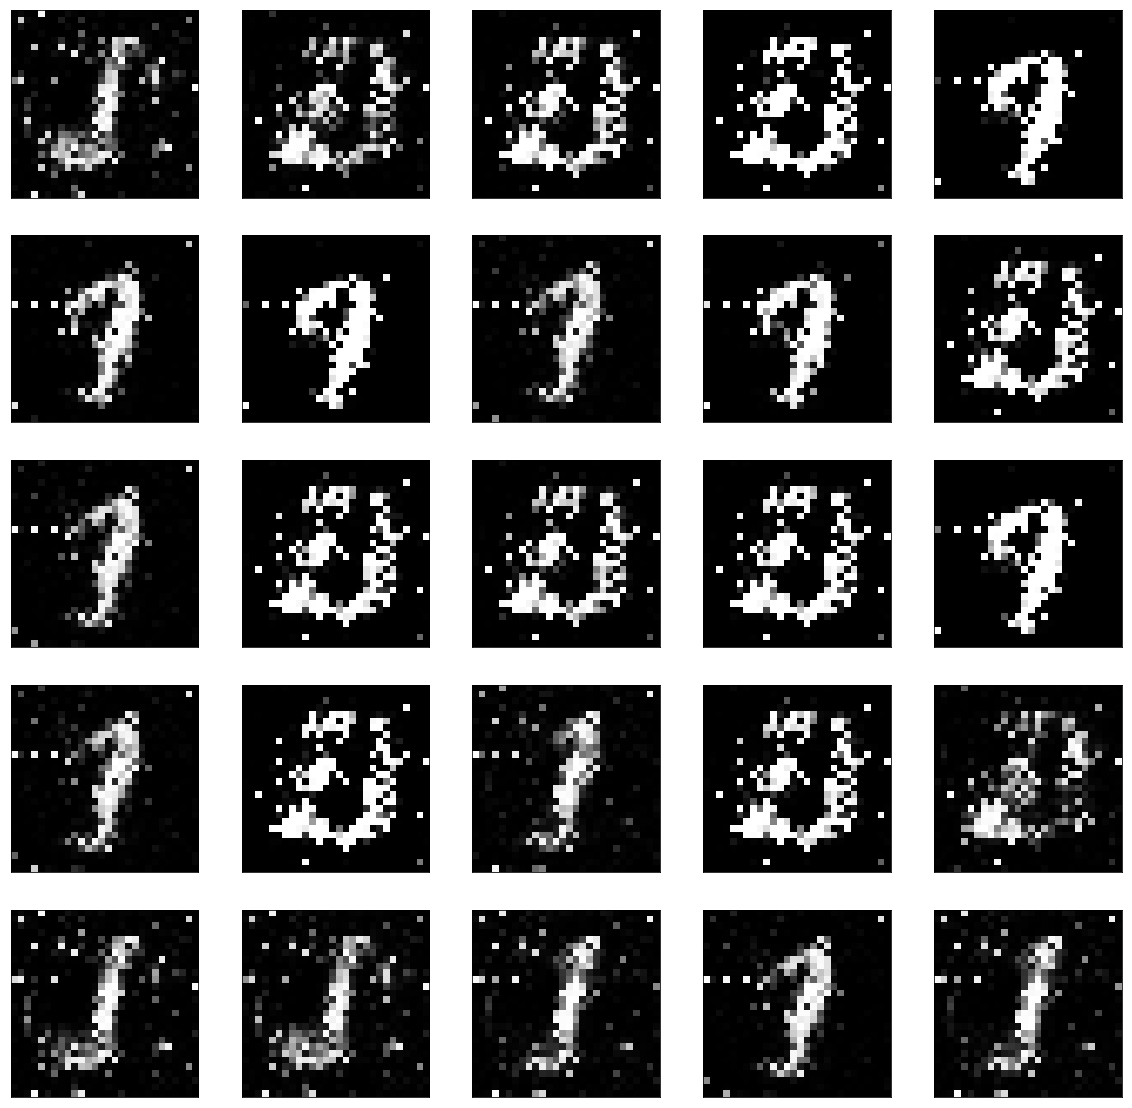

[Epoch 8/10] [Batch 97/938] [Generator loss: 3.437074] [Discriminator loss: 0.179143]
[Epoch 8/10] [Batch 98/938] [Generator loss: 2.035565] [Discriminator loss: 0.156729]
[Epoch 8/10] [Batch 99/938] [Generator loss: 2.780937] [Discriminator loss: 0.204950]
[Epoch 8/10] [Batch 100/938] [Generator loss: 1.497536] [Discriminator loss: 0.231549]
[Epoch 8/10] [Batch 101/938] [Generator loss: 3.116715] [Discriminator loss: 0.246253]
[Epoch 8/10] [Batch 102/938] [Generator loss: 0.855591] [Discriminator loss: 0.388779]
[Epoch 8/10] [Batch 103/938] [Generator loss: 6.318222] [Discriminator loss: 0.747737]
[Epoch 8/10] [Batch 104/938] [Generator loss: 0.826692] [Discriminator loss: 0.405337]
[Epoch 8/10] [Batch 105/938] [Generator loss: 4.742350] [Discriminator loss: 0.182726]
[Epoch 8/10] [Batch 106/938] [Generator loss: 3.591015] [Discriminator loss: 0.111175]
[Epoch 8/10] [Batch 107/938] [Generator loss: 2.287696] [Discriminator loss: 0.144391]
[Epoch 8/10] [Batch 108/938] [Generator loss: 

[Epoch 8/10] [Batch 205/938] [Generator loss: 2.558811] [Discriminator loss: 0.172071]
[Epoch 8/10] [Batch 206/938] [Generator loss: 1.381526] [Discriminator loss: 0.223762]
[Epoch 8/10] [Batch 207/938] [Generator loss: 3.629873] [Discriminator loss: 0.197151]
[Epoch 8/10] [Batch 208/938] [Generator loss: 1.676688] [Discriminator loss: 0.230364]
[Epoch 8/10] [Batch 209/938] [Generator loss: 1.725404] [Discriminator loss: 0.316265]
[Epoch 8/10] [Batch 210/938] [Generator loss: 1.369123] [Discriminator loss: 0.251645]
[Epoch 8/10] [Batch 211/938] [Generator loss: 3.498259] [Discriminator loss: 0.330187]
[Epoch 8/10] [Batch 212/938] [Generator loss: 0.794939] [Discriminator loss: 0.418295]
[Epoch 8/10] [Batch 213/938] [Generator loss: 5.281559] [Discriminator loss: 0.627552]
[Epoch 8/10] [Batch 214/938] [Generator loss: 0.814083] [Discriminator loss: 0.358278]
[Epoch 8/10] [Batch 215/938] [Generator loss: 4.406456] [Discriminator loss: 0.360518]
[Epoch 8/10] [Batch 216/938] [Generator los

[Epoch 8/10] [Batch 302/938] [Generator loss: 3.228452] [Discriminator loss: 0.157021]
[Epoch 8/10] [Batch 303/938] [Generator loss: 2.168972] [Discriminator loss: 0.213776]
[Epoch 8/10] [Batch 304/938] [Generator loss: 1.418165] [Discriminator loss: 0.219265]
[Epoch 8/10] [Batch 305/938] [Generator loss: 3.447520] [Discriminator loss: 0.182556]
[Epoch 8/10] [Batch 306/938] [Generator loss: 1.931921] [Discriminator loss: 0.229877]
[Epoch 8/10] [Batch 307/938] [Generator loss: 1.217830] [Discriminator loss: 0.376313]
[Epoch 8/10] [Batch 308/938] [Generator loss: 2.484251] [Discriminator loss: 0.179531]
[Epoch 8/10] [Batch 309/938] [Generator loss: 1.900447] [Discriminator loss: 0.203839]
[Epoch 8/10] [Batch 310/938] [Generator loss: 1.706729] [Discriminator loss: 0.233246]
[Epoch 8/10] [Batch 311/938] [Generator loss: 2.012345] [Discriminator loss: 0.182148]
[Epoch 8/10] [Batch 312/938] [Generator loss: 2.237387] [Discriminator loss: 0.239181]
[Epoch 8/10] [Batch 313/938] [Generator los

[Epoch 8/10] [Batch 397/938] [Generator loss: 2.051891] [Discriminator loss: 0.235016]
[Epoch 8/10] [Batch 398/938] [Generator loss: 1.298556] [Discriminator loss: 0.292889]
[Epoch 8/10] [Batch 399/938] [Generator loss: 3.990741] [Discriminator loss: 0.393456]
[Epoch 8/10] [Batch 400/938] [Generator loss: 0.976658] [Discriminator loss: 0.348843]
[Epoch 8/10] [Batch 401/938] [Generator loss: 4.185110] [Discriminator loss: 0.409755]
[Epoch 8/10] [Batch 402/938] [Generator loss: 1.517735] [Discriminator loss: 0.265053]
[Epoch 8/10] [Batch 403/938] [Generator loss: 2.108632] [Discriminator loss: 0.175321]
[Epoch 8/10] [Batch 404/938] [Generator loss: 2.292347] [Discriminator loss: 0.337681]
[Epoch 8/10] [Batch 405/938] [Generator loss: 0.566600] [Discriminator loss: 0.513724]
[Epoch 8/10] [Batch 406/938] [Generator loss: 8.041670] [Discriminator loss: 1.344093]
[Epoch 8/10] [Batch 407/938] [Generator loss: 2.004684] [Discriminator loss: 0.194897]
[Epoch 8/10] [Batch 408/938] [Generator los

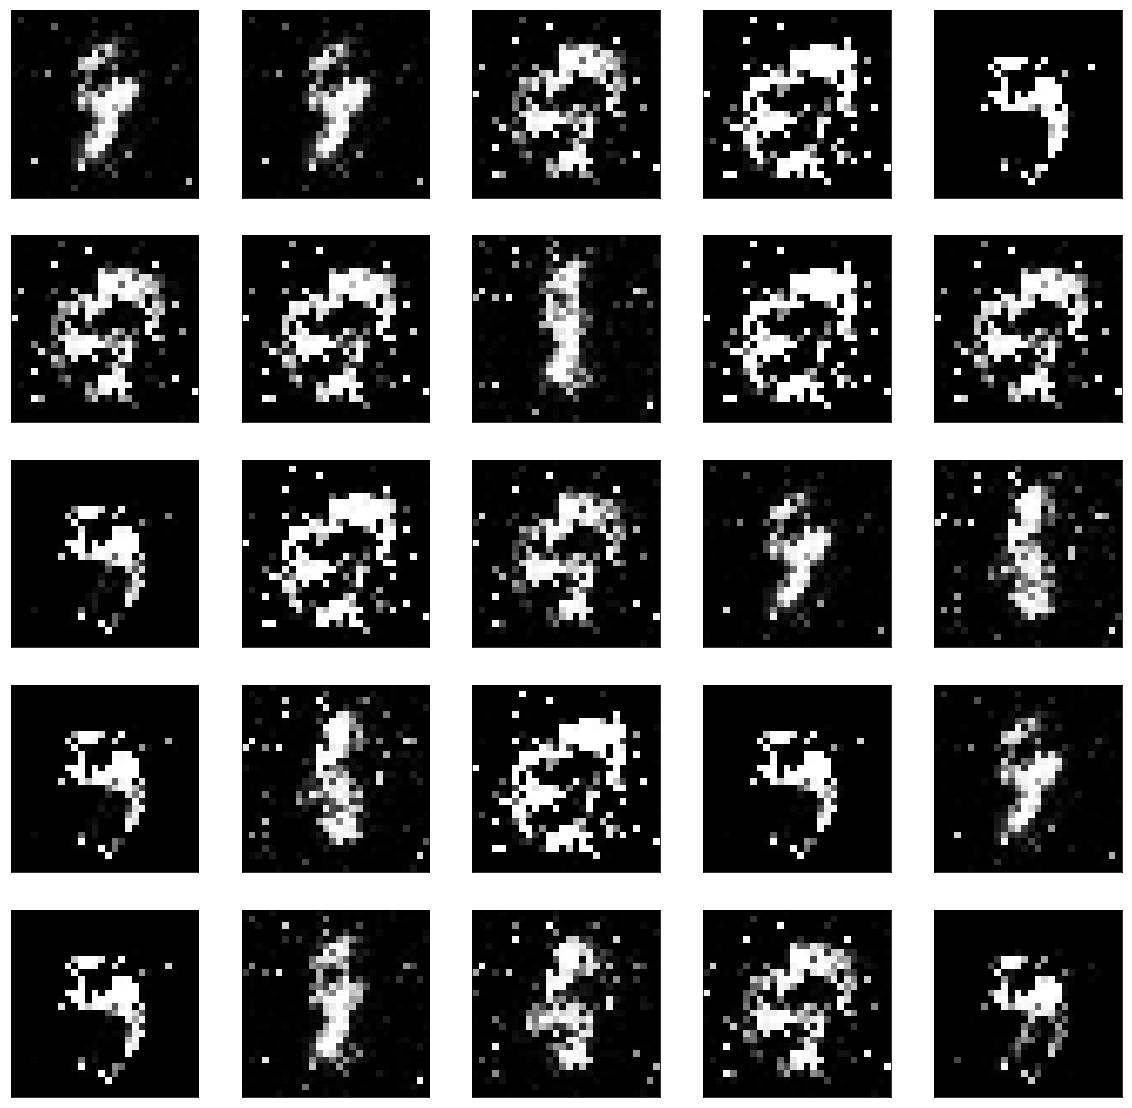

[Epoch 8/10] [Batch 497/938] [Generator loss: 2.305357] [Discriminator loss: 0.159278]
[Epoch 8/10] [Batch 498/938] [Generator loss: 2.496843] [Discriminator loss: 0.194085]
[Epoch 8/10] [Batch 499/938] [Generator loss: 1.751568] [Discriminator loss: 0.197416]
[Epoch 8/10] [Batch 500/938] [Generator loss: 2.311756] [Discriminator loss: 0.178749]
[Epoch 8/10] [Batch 501/938] [Generator loss: 2.147243] [Discriminator loss: 0.261084]
[Epoch 8/10] [Batch 502/938] [Generator loss: 1.235483] [Discriminator loss: 0.268746]
[Epoch 8/10] [Batch 503/938] [Generator loss: 3.637661] [Discriminator loss: 0.252762]
[Epoch 8/10] [Batch 504/938] [Generator loss: 1.834467] [Discriminator loss: 0.218574]
[Epoch 8/10] [Batch 505/938] [Generator loss: 1.642487] [Discriminator loss: 0.231441]
[Epoch 8/10] [Batch 506/938] [Generator loss: 2.825286] [Discriminator loss: 0.250840]
[Epoch 8/10] [Batch 507/938] [Generator loss: 1.338778] [Discriminator loss: 0.211573]
[Epoch 8/10] [Batch 508/938] [Generator los

[Epoch 8/10] [Batch 600/938] [Generator loss: 1.362494] [Discriminator loss: 0.264005]
[Epoch 8/10] [Batch 601/938] [Generator loss: 2.936520] [Discriminator loss: 0.390532]
[Epoch 8/10] [Batch 602/938] [Generator loss: 0.674821] [Discriminator loss: 0.435356]
[Epoch 8/10] [Batch 603/938] [Generator loss: 5.503535] [Discriminator loss: 0.786379]
[Epoch 8/10] [Batch 604/938] [Generator loss: 1.198112] [Discriminator loss: 0.408960]
[Epoch 8/10] [Batch 605/938] [Generator loss: 2.204320] [Discriminator loss: 0.204058]
[Epoch 8/10] [Batch 606/938] [Generator loss: 2.122660] [Discriminator loss: 0.169969]
[Epoch 8/10] [Batch 607/938] [Generator loss: 2.476090] [Discriminator loss: 0.129675]
[Epoch 8/10] [Batch 608/938] [Generator loss: 2.045379] [Discriminator loss: 0.197455]
[Epoch 8/10] [Batch 609/938] [Generator loss: 1.704215] [Discriminator loss: 0.193180]
[Epoch 8/10] [Batch 610/938] [Generator loss: 2.835544] [Discriminator loss: 0.249037]
[Epoch 8/10] [Batch 611/938] [Generator los

[Epoch 8/10] [Batch 697/938] [Generator loss: 1.670278] [Discriminator loss: 0.250905]
[Epoch 8/10] [Batch 698/938] [Generator loss: 0.756568] [Discriminator loss: 0.374689]
[Epoch 8/10] [Batch 699/938] [Generator loss: 5.583703] [Discriminator loss: 0.629926]
[Epoch 8/10] [Batch 700/938] [Generator loss: 2.098683] [Discriminator loss: 0.199103]
[Epoch 8/10] [Batch 701/938] [Generator loss: 0.815392] [Discriminator loss: 0.392437]
[Epoch 8/10] [Batch 702/938] [Generator loss: 5.367437] [Discriminator loss: 0.447535]
[Epoch 8/10] [Batch 703/938] [Generator loss: 3.144401] [Discriminator loss: 0.207808]
[Epoch 8/10] [Batch 704/938] [Generator loss: 0.835537] [Discriminator loss: 0.486054]
[Epoch 8/10] [Batch 705/938] [Generator loss: 4.636600] [Discriminator loss: 0.412782]
[Epoch 8/10] [Batch 706/938] [Generator loss: 2.493165] [Discriminator loss: 0.281264]
[Epoch 8/10] [Batch 707/938] [Generator loss: 0.684583] [Discriminator loss: 0.517645]
[Epoch 8/10] [Batch 708/938] [Generator los

[Epoch 8/10] [Batch 797/938] [Generator loss: 0.835234] [Discriminator loss: 0.412786]
[Epoch 8/10] [Batch 798/938] [Generator loss: 5.062201] [Discriminator loss: 0.669717]
[Epoch 8/10] [Batch 799/938] [Generator loss: 0.611321] [Discriminator loss: 0.509850]
[Epoch 8/10] [Batch 800/938] [Generator loss: 4.964983] [Discriminator loss: 0.504625]
[Epoch 8/10] [Batch 801/938] [Generator loss: 2.048254] [Discriminator loss: 0.168764]
[Epoch 8/10] [Batch 802/938] [Generator loss: 1.166108] [Discriminator loss: 0.264248]
[Epoch 8/10] [Batch 803/938] [Generator loss: 4.577332] [Discriminator loss: 0.393467]
[Epoch 8/10] [Batch 804/938] [Generator loss: 1.797763] [Discriminator loss: 0.158579]
[Epoch 8/10] [Batch 805/938] [Generator loss: 1.598794] [Discriminator loss: 0.180178]
[Epoch 8/10] [Batch 806/938] [Generator loss: 3.332867] [Discriminator loss: 0.263533]
[Epoch 8/10] [Batch 807/938] [Generator loss: 1.092373] [Discriminator loss: 0.305783]
[Epoch 8/10] [Batch 808/938] [Generator los

[Epoch 8/10] [Batch 893/938] [Generator loss: 0.998297] [Discriminator loss: 0.346143]
[Epoch 8/10] [Batch 894/938] [Generator loss: 4.504711] [Discriminator loss: 0.143882]
[Epoch 8/10] [Batch 895/938] [Generator loss: 4.317181] [Discriminator loss: 0.179946]
[Epoch 8/10] [Batch 896/938] [Generator loss: 2.180322] [Discriminator loss: 0.227739]


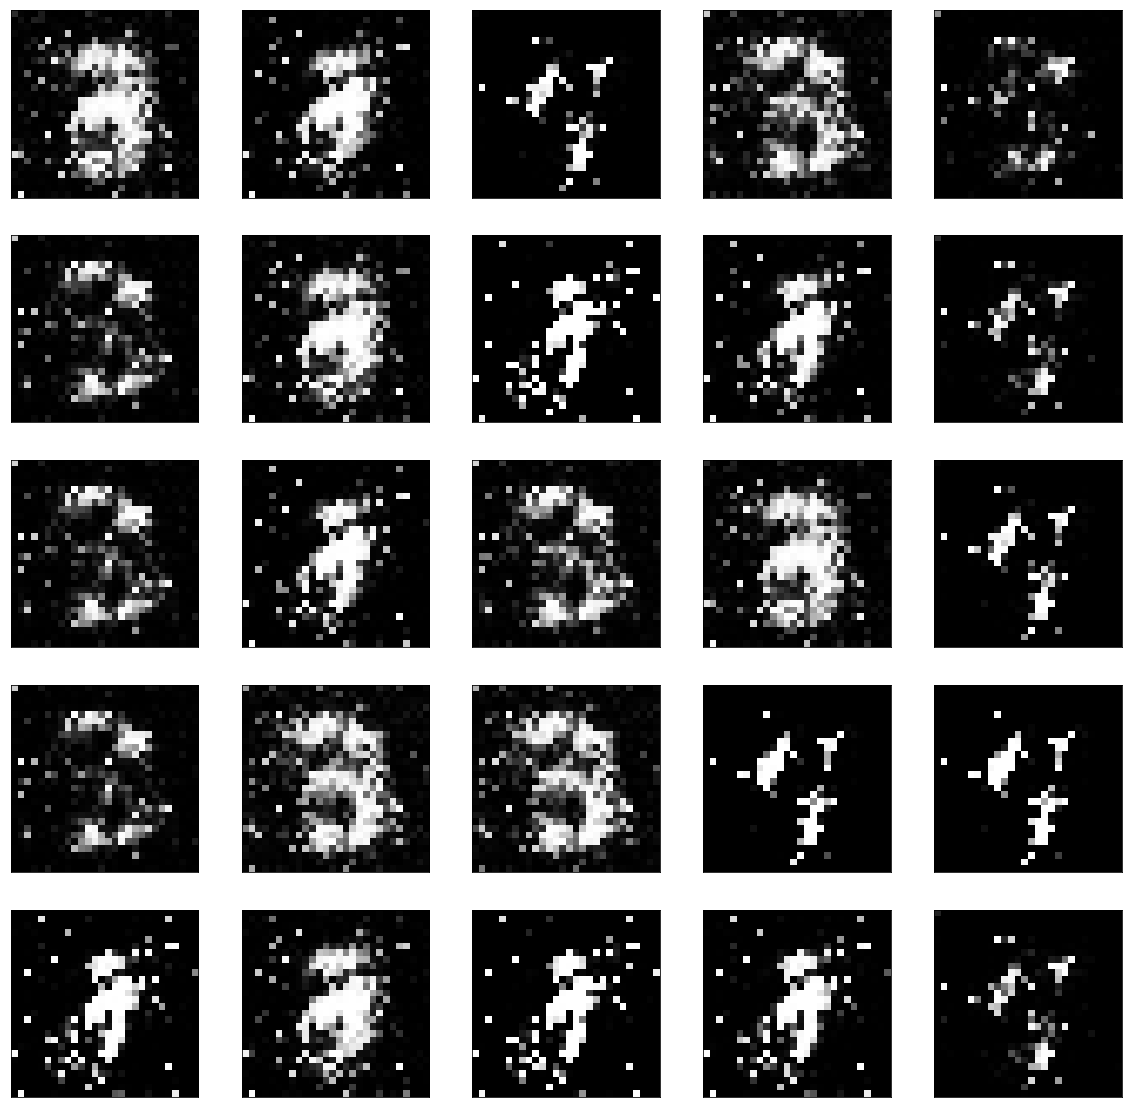

[Epoch 8/10] [Batch 897/938] [Generator loss: 1.609987] [Discriminator loss: 0.230051]
[Epoch 8/10] [Batch 898/938] [Generator loss: 3.480875] [Discriminator loss: 0.275891]
[Epoch 8/10] [Batch 899/938] [Generator loss: 1.618701] [Discriminator loss: 0.236078]
[Epoch 8/10] [Batch 900/938] [Generator loss: 1.769257] [Discriminator loss: 0.205959]
[Epoch 8/10] [Batch 901/938] [Generator loss: 3.272603] [Discriminator loss: 0.313630]
[Epoch 8/10] [Batch 902/938] [Generator loss: 1.232209] [Discriminator loss: 0.328411]
[Epoch 8/10] [Batch 903/938] [Generator loss: 2.888723] [Discriminator loss: 0.148206]
[Epoch 8/10] [Batch 904/938] [Generator loss: 2.915312] [Discriminator loss: 0.155612]
[Epoch 8/10] [Batch 905/938] [Generator loss: 2.041718] [Discriminator loss: 0.157383]
[Epoch 8/10] [Batch 906/938] [Generator loss: 1.921304] [Discriminator loss: 0.200985]
[Epoch 8/10] [Batch 907/938] [Generator loss: 2.114790] [Discriminator loss: 0.184567]
[Epoch 8/10] [Batch 908/938] [Generator los

[Epoch 9/10] [Batch 58/938] [Generator loss: 0.603747] [Discriminator loss: 0.479176]
[Epoch 9/10] [Batch 59/938] [Generator loss: 5.550421] [Discriminator loss: 0.743231]
[Epoch 9/10] [Batch 60/938] [Generator loss: 1.908484] [Discriminator loss: 0.154584]
[Epoch 9/10] [Batch 61/938] [Generator loss: 1.403953] [Discriminator loss: 0.236800]
[Epoch 9/10] [Batch 62/938] [Generator loss: 3.246310] [Discriminator loss: 0.225057]
[Epoch 9/10] [Batch 63/938] [Generator loss: 1.949226] [Discriminator loss: 0.212578]
[Epoch 9/10] [Batch 64/938] [Generator loss: 1.566413] [Discriminator loss: 0.210182]
[Epoch 9/10] [Batch 65/938] [Generator loss: 2.754602] [Discriminator loss: 0.226702]
[Epoch 9/10] [Batch 66/938] [Generator loss: 1.660068] [Discriminator loss: 0.216565]
[Epoch 9/10] [Batch 67/938] [Generator loss: 2.380970] [Discriminator loss: 0.160025]
[Epoch 9/10] [Batch 68/938] [Generator loss: 2.111913] [Discriminator loss: 0.127430]
[Epoch 9/10] [Batch 69/938] [Generator loss: 2.390226]

[Epoch 9/10] [Batch 163/938] [Generator loss: 3.165097] [Discriminator loss: 0.120629]
[Epoch 9/10] [Batch 164/938] [Generator loss: 2.559309] [Discriminator loss: 0.203484]
[Epoch 9/10] [Batch 165/938] [Generator loss: 1.031680] [Discriminator loss: 0.329303]
[Epoch 9/10] [Batch 166/938] [Generator loss: 3.504953] [Discriminator loss: 0.409596]
[Epoch 9/10] [Batch 167/938] [Generator loss: 1.142926] [Discriminator loss: 0.274822]
[Epoch 9/10] [Batch 168/938] [Generator loss: 3.278821] [Discriminator loss: 0.235159]
[Epoch 9/10] [Batch 169/938] [Generator loss: 2.020058] [Discriminator loss: 0.212746]
[Epoch 9/10] [Batch 170/938] [Generator loss: 1.260970] [Discriminator loss: 0.294548]
[Epoch 9/10] [Batch 171/938] [Generator loss: 3.188068] [Discriminator loss: 0.251036]
[Epoch 9/10] [Batch 172/938] [Generator loss: 1.802926] [Discriminator loss: 0.213657]
[Epoch 9/10] [Batch 173/938] [Generator loss: 1.903073] [Discriminator loss: 0.182174]
[Epoch 9/10] [Batch 174/938] [Generator los

[Epoch 9/10] [Batch 269/938] [Generator loss: 3.721159] [Discriminator loss: 0.269552]
[Epoch 9/10] [Batch 270/938] [Generator loss: 1.339797] [Discriminator loss: 0.209140]
[Epoch 9/10] [Batch 271/938] [Generator loss: 4.309260] [Discriminator loss: 0.245981]
[Epoch 9/10] [Batch 272/938] [Generator loss: 2.002159] [Discriminator loss: 0.166466]
[Epoch 9/10] [Batch 273/938] [Generator loss: 1.670167] [Discriminator loss: 0.169121]
[Epoch 9/10] [Batch 274/938] [Generator loss: 3.474001] [Discriminator loss: 0.190882]
[Epoch 9/10] [Batch 275/938] [Generator loss: 1.701764] [Discriminator loss: 0.194092]
[Epoch 9/10] [Batch 276/938] [Generator loss: 2.314361] [Discriminator loss: 0.308391]
[Epoch 9/10] [Batch 277/938] [Generator loss: 1.214206] [Discriminator loss: 0.320408]
[Epoch 9/10] [Batch 278/938] [Generator loss: 4.233045] [Discriminator loss: 0.343567]
[Epoch 9/10] [Batch 279/938] [Generator loss: 0.846286] [Discriminator loss: 0.365038]
[Epoch 9/10] [Batch 280/938] [Generator los

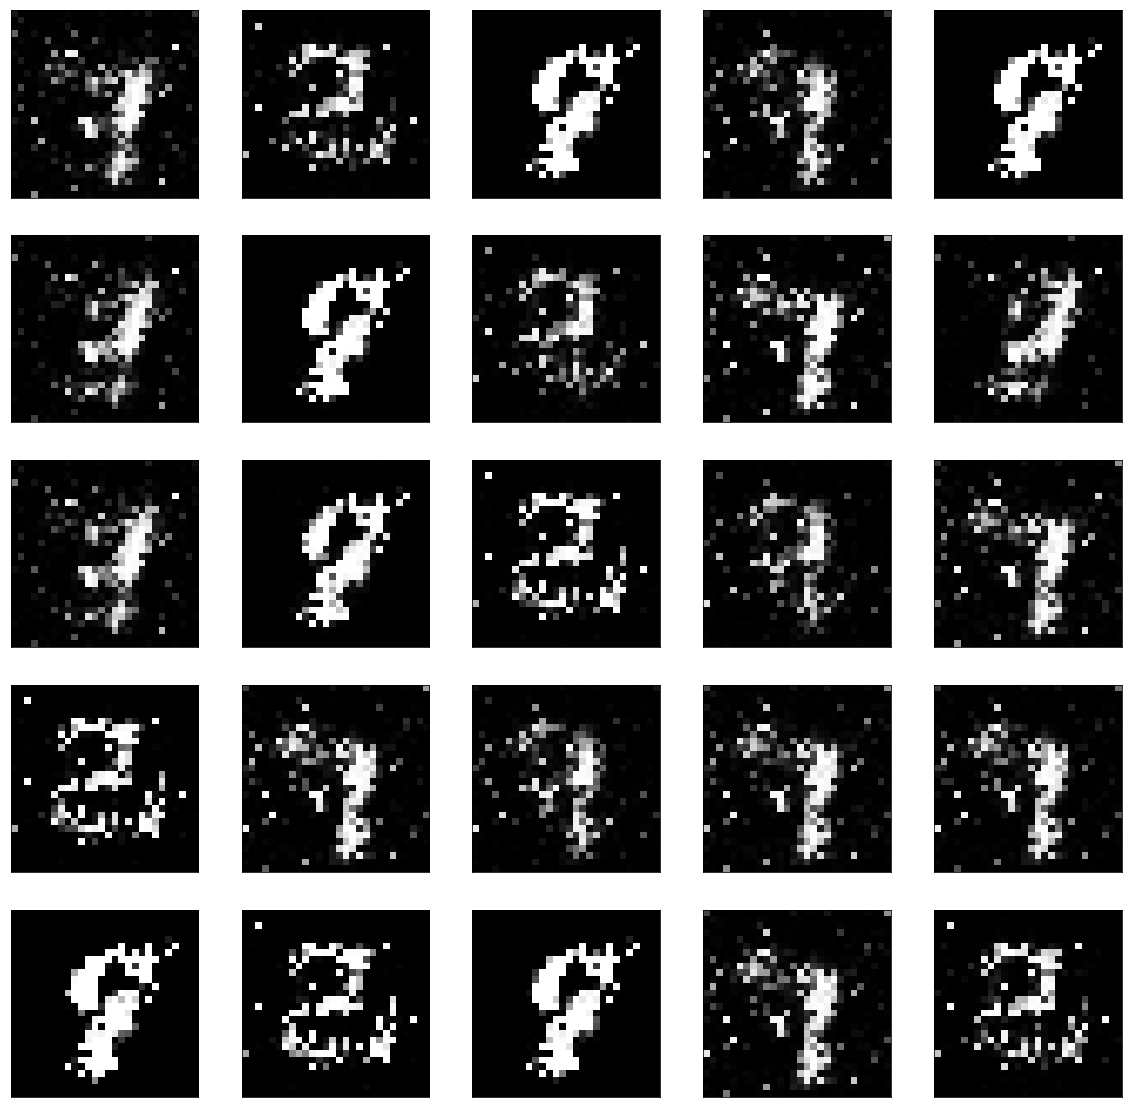

[Epoch 9/10] [Batch 359/938] [Generator loss: 1.970912] [Discriminator loss: 0.190127]
[Epoch 9/10] [Batch 360/938] [Generator loss: 2.051964] [Discriminator loss: 0.166244]
[Epoch 9/10] [Batch 361/938] [Generator loss: 2.111789] [Discriminator loss: 0.173446]
[Epoch 9/10] [Batch 362/938] [Generator loss: 2.194496] [Discriminator loss: 0.280700]
[Epoch 9/10] [Batch 363/938] [Generator loss: 0.622120] [Discriminator loss: 0.456332]
[Epoch 9/10] [Batch 364/938] [Generator loss: 6.831818] [Discriminator loss: 1.269349]
[Epoch 9/10] [Batch 365/938] [Generator loss: 0.866595] [Discriminator loss: 0.373178]
[Epoch 9/10] [Batch 366/938] [Generator loss: 3.424991] [Discriminator loss: 0.214487]
[Epoch 9/10] [Batch 367/938] [Generator loss: 2.206916] [Discriminator loss: 0.176372]
[Epoch 9/10] [Batch 368/938] [Generator loss: 1.752317] [Discriminator loss: 0.180403]
[Epoch 9/10] [Batch 369/938] [Generator loss: 2.833524] [Discriminator loss: 0.176113]
[Epoch 9/10] [Batch 370/938] [Generator los

[Epoch 9/10] [Batch 463/938] [Generator loss: 4.402165] [Discriminator loss: 0.412647]
[Epoch 9/10] [Batch 464/938] [Generator loss: 1.281311] [Discriminator loss: 0.279412]
[Epoch 9/10] [Batch 465/938] [Generator loss: 1.924459] [Discriminator loss: 0.206672]
[Epoch 9/10] [Batch 466/938] [Generator loss: 2.228828] [Discriminator loss: 0.234384]
[Epoch 9/10] [Batch 467/938] [Generator loss: 1.424908] [Discriminator loss: 0.250629]
[Epoch 9/10] [Batch 468/938] [Generator loss: 2.456616] [Discriminator loss: 0.234251]
[Epoch 9/10] [Batch 469/938] [Generator loss: 1.397393] [Discriminator loss: 0.241863]
[Epoch 9/10] [Batch 470/938] [Generator loss: 3.197510] [Discriminator loss: 0.340932]
[Epoch 9/10] [Batch 471/938] [Generator loss: 0.852473] [Discriminator loss: 0.367668]
[Epoch 9/10] [Batch 472/938] [Generator loss: 4.676382] [Discriminator loss: 0.586513]
[Epoch 9/10] [Batch 473/938] [Generator loss: 0.872685] [Discriminator loss: 0.352547]
[Epoch 9/10] [Batch 474/938] [Generator los

[Epoch 9/10] [Batch 558/938] [Generator loss: 1.066328] [Discriminator loss: 0.408889]
[Epoch 9/10] [Batch 559/938] [Generator loss: 4.152809] [Discriminator loss: 0.178895]
[Epoch 9/10] [Batch 560/938] [Generator loss: 3.477940] [Discriminator loss: 0.173881]
[Epoch 9/10] [Batch 561/938] [Generator loss: 1.457860] [Discriminator loss: 0.197014]
[Epoch 9/10] [Batch 562/938] [Generator loss: 3.223979] [Discriminator loss: 0.156093]
[Epoch 9/10] [Batch 563/938] [Generator loss: 2.466786] [Discriminator loss: 0.216766]
[Epoch 9/10] [Batch 564/938] [Generator loss: 1.418938] [Discriminator loss: 0.194567]
[Epoch 9/10] [Batch 565/938] [Generator loss: 2.938293] [Discriminator loss: 0.155895]
[Epoch 9/10] [Batch 566/938] [Generator loss: 2.453151] [Discriminator loss: 0.349206]
[Epoch 9/10] [Batch 567/938] [Generator loss: 0.586374] [Discriminator loss: 0.453408]
[Epoch 9/10] [Batch 568/938] [Generator loss: 6.521733] [Discriminator loss: 0.719068]
[Epoch 9/10] [Batch 569/938] [Generator los

[Epoch 9/10] [Batch 663/938] [Generator loss: 5.278688] [Discriminator loss: 0.305285]
[Epoch 9/10] [Batch 664/938] [Generator loss: 3.765548] [Discriminator loss: 0.173955]
[Epoch 9/10] [Batch 665/938] [Generator loss: 2.871537] [Discriminator loss: 0.157436]
[Epoch 9/10] [Batch 666/938] [Generator loss: 3.657348] [Discriminator loss: 0.105462]
[Epoch 9/10] [Batch 667/938] [Generator loss: 2.799551] [Discriminator loss: 0.106738]
[Epoch 9/10] [Batch 668/938] [Generator loss: 1.882825] [Discriminator loss: 0.163716]
[Epoch 9/10] [Batch 669/938] [Generator loss: 2.959437] [Discriminator loss: 0.129595]
[Epoch 9/10] [Batch 670/938] [Generator loss: 2.806437] [Discriminator loss: 0.228228]
[Epoch 9/10] [Batch 671/938] [Generator loss: 1.187606] [Discriminator loss: 0.298080]
[Epoch 9/10] [Batch 672/938] [Generator loss: 4.600244] [Discriminator loss: 0.262447]
[Epoch 9/10] [Batch 673/938] [Generator loss: 2.529329] [Discriminator loss: 0.172093]
[Epoch 9/10] [Batch 674/938] [Generator los

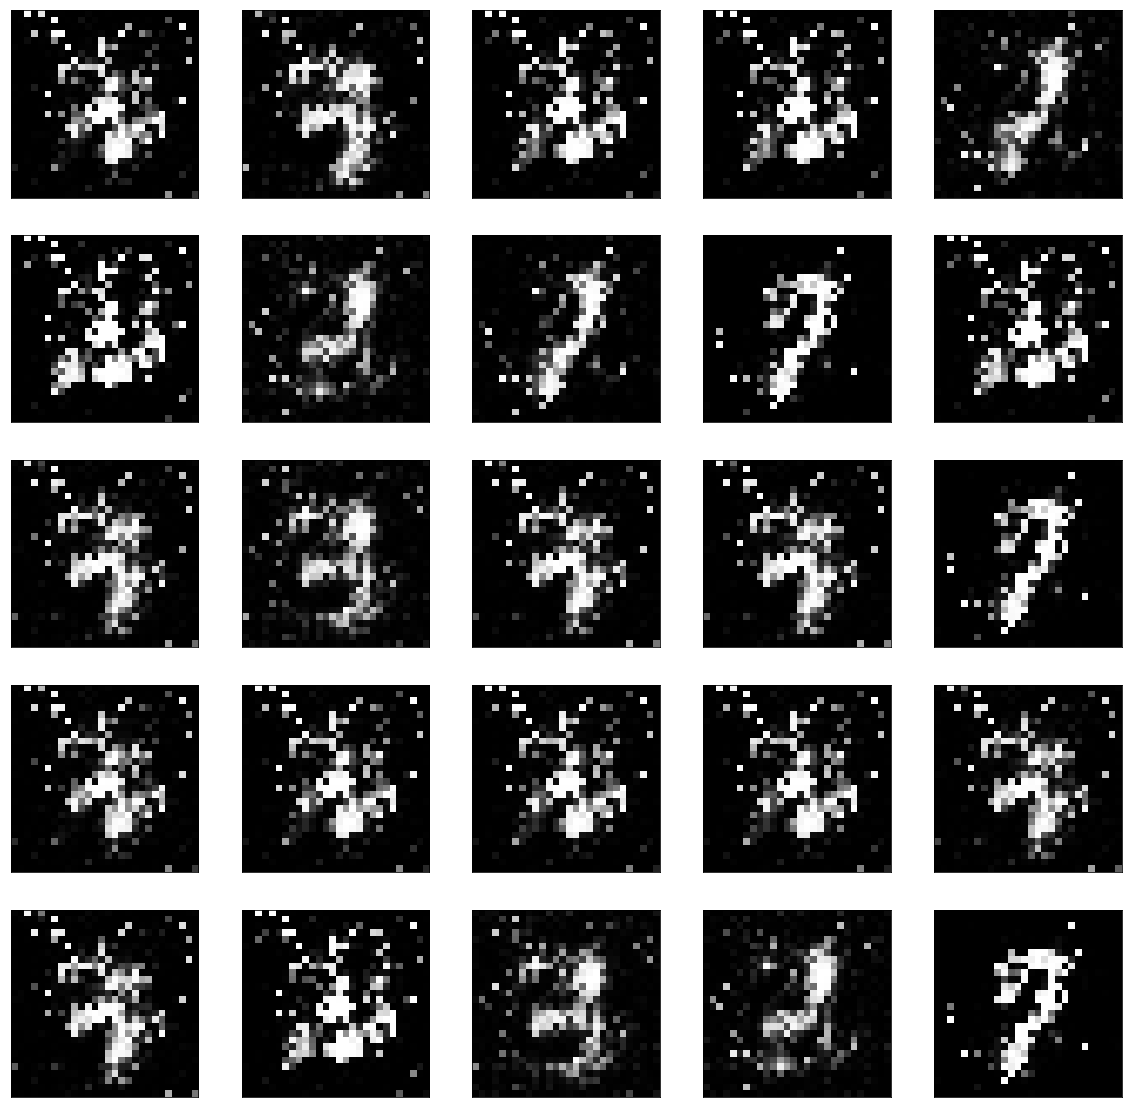

[Epoch 9/10] [Batch 759/938] [Generator loss: 1.083652] [Discriminator loss: 0.338499]
[Epoch 9/10] [Batch 760/938] [Generator loss: 4.089545] [Discriminator loss: 0.383477]
[Epoch 9/10] [Batch 761/938] [Generator loss: 1.015704] [Discriminator loss: 0.365940]
[Epoch 9/10] [Batch 762/938] [Generator loss: 4.571334] [Discriminator loss: 0.274717]
[Epoch 9/10] [Batch 763/938] [Generator loss: 2.533812] [Discriminator loss: 0.178208]
[Epoch 9/10] [Batch 764/938] [Generator loss: 2.331039] [Discriminator loss: 0.180993]
[Epoch 9/10] [Batch 765/938] [Generator loss: 2.472806] [Discriminator loss: 0.116070]
[Epoch 9/10] [Batch 766/938] [Generator loss: 2.420859] [Discriminator loss: 0.167072]
[Epoch 9/10] [Batch 767/938] [Generator loss: 2.132238] [Discriminator loss: 0.172244]
[Epoch 9/10] [Batch 768/938] [Generator loss: 2.411005] [Discriminator loss: 0.237635]
[Epoch 9/10] [Batch 769/938] [Generator loss: 1.226449] [Discriminator loss: 0.274788]
[Epoch 9/10] [Batch 770/938] [Generator los

[Epoch 9/10] [Batch 858/938] [Generator loss: 2.193187] [Discriminator loss: 0.196828]
[Epoch 9/10] [Batch 859/938] [Generator loss: 2.154745] [Discriminator loss: 0.145482]
[Epoch 9/10] [Batch 860/938] [Generator loss: 2.601894] [Discriminator loss: 0.264158]
[Epoch 9/10] [Batch 861/938] [Generator loss: 0.913977] [Discriminator loss: 0.354932]
[Epoch 9/10] [Batch 862/938] [Generator loss: 5.555721] [Discriminator loss: 0.666736]
[Epoch 9/10] [Batch 863/938] [Generator loss: 1.951272] [Discriminator loss: 0.199449]
[Epoch 9/10] [Batch 864/938] [Generator loss: 1.599114] [Discriminator loss: 0.198602]
[Epoch 9/10] [Batch 865/938] [Generator loss: 3.520356] [Discriminator loss: 0.130090]
[Epoch 9/10] [Batch 866/938] [Generator loss: 2.814118] [Discriminator loss: 0.233503]
[Epoch 9/10] [Batch 867/938] [Generator loss: 0.953571] [Discriminator loss: 0.356778]
[Epoch 9/10] [Batch 868/938] [Generator loss: 4.955173] [Discriminator loss: 0.311476]
[Epoch 9/10] [Batch 869/938] [Generator los

In [20]:
g_loss_to_display = []
d_loss_to_display = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        # configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ----------------
        # Train Generator
        # ----------------
        optimizer_G.zero_grad()
        
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # generate a batch of images
        gen_imgs = generator(z)
        
        # loss measures the generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        
        optimizer_G.step()
        
        # -------------------
        # Train Discriminator
        # -------------------
        
        optimizer_D.zero_grad()
        
        # measure the discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [Generator loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), g_loss.item(), d_loss.item())
        )
        
        # save losses for plotting later
        g_loss_to_display.append(g_loss.item())
        d_loss_to_display.append(d_loss.item())
        
        batches_done = epoch * len(data_loader) + i
        
        if batches_done % sample_interval == 0:
            gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))
            
            # display 25 generated images in one batch and save it
            imshow(gen_imgs_to_display)
            save_image(gen_imgs.data[:25], "images/gan/%d.png" % batches_done, nrow=5, normalize=True)

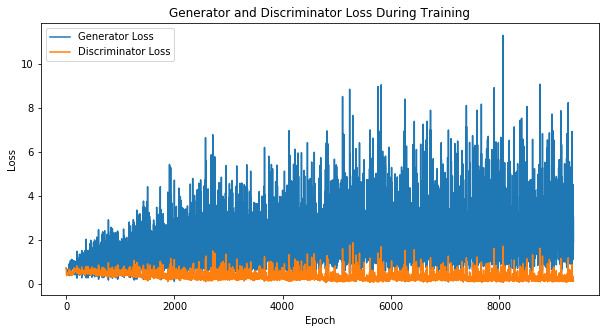

In [23]:
# plot g_loss and d_loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label='Generator Loss')
plt.plot(d_loss_to_display, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./images/dcgan/final_loss.png')
plt.show()

## Final GAN Images

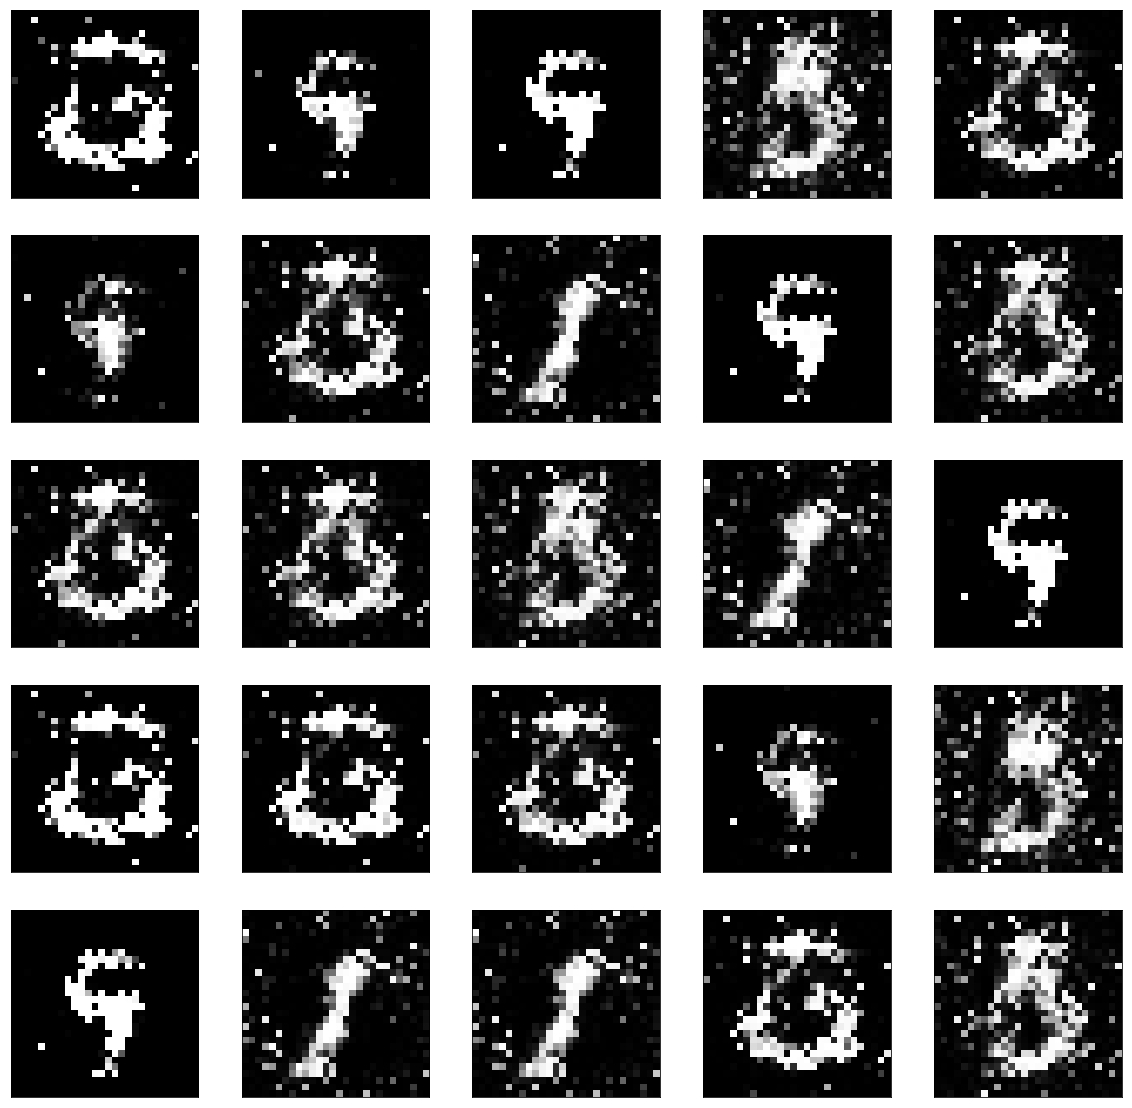

In [22]:
# obtain one batch of test images
dataiter = iter(data_loader)
imgs, _ = dataiter.next()

# sample noise as generator input
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

# generate a batch of images
gen_imgs = generator(z)
gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))

# show and save these final images
imshow(gen_imgs_to_display)

<hr/>